## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from pathlib import Path
from typing import Literal
import networkx as nx
import pandas as pd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from convergence.plotting import plot_faverage_parcelation, add_area_labels
from convergence.figures import plot_boxplot_rois, add_pvalue_bracket, plot_cbar
from convergence.operations import interpolate_alignment_series, unpack_scores
from numpy import sqrt, diag
from numpy.random import choice
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Change font to arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42

output = Path("figures_rsa")
output.mkdir(exist_ok=True, parents=True)

## Functions

In [2]:
data_folder = Path("data/data_rsa")
hcp_filename = Path("data") / "hcp3.csv"
models_filename = Path("data") / "models-info.csv"
pvalues_filename = Path("stats") / "rsa_pvalues_subject_language_vision.parquet"

visual_cortex = ["V1", "V2", "V3", "V4"]
ventral_cluster = ["VMV1", "VMV2", "VMV3", "PHA1", "PHA2", "PHA3"]
dorsal_cluster = ["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"]

def model_modality(model_name: str):
    return "vision" if model_name.endswith("-cls") else "language"

def load_filename(modality="cross_subject", shift=0, joined=True):

    if modality == "cross_subject":
        filename = f"rsa_subject_subject_alignment_shift_{shift}_{'joined' if joined else 'separated'}.parquet"
    elif modality == 'models':
        filename = f"rsa_subject_model_alignment_{'joined' if joined else 'separated'}.parquet"
    
    return pd.read_parquet(data_folder / filename)

def process_intersubject_rois(df, top=10):
    # Load cross subject data
    df = df.rename(columns={"similarity": "score"})
    df = df.query("score < 1 and score > -1 and roi_x == roi_y and subject_i != subject_j").copy()
    df = df.groupby(["roi_x", "subject_i"]).aggregate({"score": "mean"}).reset_index()
    df = df.rename(columns={"roi_x": "roi", "subject_i": "subject"})

    # HCP
    hcp = pd.read_csv(hcp_filename)
    hcp.name = hcp.name.replace({"H": "Hipp"})
    hcp = hcp[["roi", "name", "roi_order", "area_color", "area_id", "area"]]

    # Get areas with highest intersubject alignment
    df_top = df.groupby("roi").aggregate({"score": "mean"}).reset_index()
    df_top = df_top.merge(hcp[["roi", "name", "area_id", "area"]], on="roi")
    df_top = df_top.groupby(["area", "area_id"]).aggregate({"score": "mean"}).reset_index().sort_values("score", ascending=False)
    selected_areas = df_top.head(top).sort_values("area_id").area_id.tolist()

    df = df.merge(hcp[["roi", "name", "area_id", "area", "roi_order", "area_color"]], on="roi")
    df = df.sort_values(["area_id", "roi_order"]).reset_index(drop=True)


    df_g_filtered = df.query("area_id in @selected_areas").copy()# and roi in @very_significant_rois").copy()
    df_g_filtered = df_g_filtered.sort_values(["area_id", "roi_order"]).reset_index(drop=True)

    return df_g_filtered


# Power-law model
def power_law(x, a, b, c):
    return a * x**b + c

# Power-law model
def power_law_zero(x, a, b):
    return a * x**b



def add_cluster(data):
    data['cluster'] = data['name'].apply(lambda x: 'Visual Cortex' if x in visual_cortex else 'Ventral Cluster' if x in ventral_cluster else 'Dorsal Cluster' if x in dorsal_cluster else 'Other')
    return data


def power_law_zero(x, a, b):
    return a * x**b

# Function to fit, bootstrap CI, and compute pseudo-R²
def fit_powerlaw_with_bootstrap(x, y, n_boot=1000, p0=[1, 0.5, 0], n_points=200):
    # Ensure numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Fit original model
    params, _ = curve_fit(power_law, x, y, p0=p0, maxfev=5000)
    y_pred = power_law(x, *params)
    print(params)

    # Compute pseudo-R²
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - ss_res / ss_tot

    # Define x values for smooth curve
    x_fit = np.linspace(min(x), max(x), n_points)
    y_fit = power_law(x_fit, *params)

    # Bootstrap confidence intervals
    bootstrap_preds = []
    for _ in range(n_boot):
        indices = choice(range(len(x)), size=len(x), replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        try:
            popt, _ = curve_fit(power_law, x_sample, y_sample, p0=p0, maxfev=5000)
            y_boot = power_law(x_fit, *popt)
            bootstrap_preds.append(y_boot)
        except RuntimeError:
            continue  # skip failed fits

    bootstrap_preds = np.array(bootstrap_preds)
    y_lower, y_upper = np.percentile(bootstrap_preds, [2.5, 97.5], axis=0)

    return x_fit, y_fit, y_lower, y_upper, r_squared

# Adjusted function for fitting with bootstrap and pseudo-R²
def fit_powerlaw_zero_with_bootstrap(x, y, n_boot=1000, p0=[1, 0.5], n_points=200):
    x = np.asarray(x)
    y = np.asarray(y)

    # Fit the simplified model
    params, _ = curve_fit(power_law_zero, x, y, p0=p0, maxfev=5000)
    y_pred = power_law_zero(x, *params)

    # Compute pseudo-R²
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - ss_res / ss_tot

    # Generate fitted curve
    x_fit = np.linspace(min(x), max(x), n_points)
    y_fit = power_law_zero(x_fit, *params)

    # Bootstrap confidence intervals
    bootstrap_preds = []
    for _ in range(n_boot):
        indices = choice(range(len(x)), size=len(x), replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        try:
            popt, _ = curve_fit(power_law_zero, x_sample, y_sample, p0=p0, maxfev=5000)
            y_boot = power_law_zero(x_fit, *popt)
            bootstrap_preds.append(y_boot)
        except RuntimeError:
            continue

    bootstrap_preds = np.array(bootstrap_preds)
    y_lower, y_upper = np.percentile(bootstrap_preds, [2.5, 97.5], axis=0)

    return x_fit, y_fit, y_lower, y_upper, r_squared, params

def plot_comparison(data, x, y, ax, palette, hue="area"):

    # Marker style
    style = {
        'Ventral Cluster': 's', # Square
        'Visual Cortex': '^', # Triangle
        'Dorsal Cluster': 'D',
        'Other': 'o' # Normal Dot
    }
    sns.scatterplot(
        data=data.query("not top_area"),
        x=x,
        y=y,
        color="white",
        ax=ax,
        edgecolor=(0.24, 0.24, 0.24),
        zorder=-5,
        alpha=0.8,
    )

    sns.scatterplot(
        data=data.query("top_area"),
        x=x,
        y=y,
        hue=hue,
        palette=palette,
        ax=ax,
        #s=100,
        edgecolor=(0.24, 0.24, 0.24),
        #linewidth=0.5,
        legend=False,
        style="cluster",
        markers=style,
    )


    sns.despine(ax=ax)
    return ax

def proccess_alignment(group_subject=True, joined=True):
    models_info = pd.read_csv(models_filename)
    models_info = models_info[["model_name", "modality"]].rename(columns={"model_name": "model"})
    df_models = load_filename("models", joined=joined)
    df_models = df_models.rename(columns={"similarity": "score"})
    df_models = df_models.query("score < 1 and score > -1")  # Not needed. No one is out of bounds
    df_models["max_layer"] = df_models.groupby(["model"], observed=True).layer.transform("max")
    df_models["depth"] = df_models["layer"] / df_models["max_layer"]
    df_models["abs_score"] = df_models["score"].abs()
    df_models = df_models.sort_values("abs_score", ascending=False).drop_duplicates(
        ["roi", "model", "subject", "session"], keep="first"
    )  # Get the best score for each roi, model, subject, session

    df_models = (
        df_models.groupby(["roi", "model", "subject"], observed=True)
        .aggregate({"score": "mean", "depth": "mean"})
        .reset_index()
    )
    df_models = df_models.merge(models_info, on="model")

    if group_subject:
        df_models = (
            df_models.groupby(["roi", "modality"])
            .aggregate({"score": "mean", "depth": "mean"})
            .reset_index()
        )
    else:
        df_models = (
            df_models.groupby(["roi", "modality", "subject"])
            .aggregate({"score": "mean", "depth": "mean"})
            .reset_index()
        )
    df_models_language = df_models.query("modality == 'language'")
    df_models_vision = df_models.query("modality == 'vision'")

    df_intersubject = load_filename("cross_subject", shift=1, joined=joined)
    df_intersubject = process_intersubject_rois(df_intersubject, top=100)
    groups = ["roi"] if group_subject else ["roi", "subject"]
    df_intersubject = df_intersubject.groupby(groups).score.mean().reset_index()
    df_intersubject = df_intersubject.rename(columns={"score": "intersubject_rsa"})

    df_models_language = df_models_language.rename(
        columns={"score": "language_rsa", "depth": "language_depth"}
    )
    df_models_language = df_models_language[groups + ["language_rsa", "language_depth"]]
    df_models_vision = df_models_vision.rename(
        columns={"score": "vision_rsa", "depth": "vision_depth"}
    )
    df_models_vision = df_models_vision[groups + ["vision_rsa", "vision_depth"]]
    df_comparison = df_intersubject.merge(df_models_language, on=groups).merge(
        df_models_vision, on=groups
    )

    p_values = pd.read_parquet(pvalues_filename)
    p_values_intersubject = p_values.query("comparison == 'intersubject'")
    p_values_intersubject = p_values_intersubject[
        ["roi", "pvalue_fdr_bh", "null_mean", "null_std", "apa_star"]
    ].rename(
        columns={
            "pvalue_fdr_bh": "intersubject_p_value",
            "null_mean": "intersubject_null_mean",
            "null_std": "intersubject_null_std",
            "apa_star": "intersubject_apa_star",
        }
    )
    df_comparison = df_comparison.merge(p_values_intersubject, on="roi", how='left')

    hcp = pd.read_csv(hcp_filename)
    hcp = hcp[["roi", "name" , "area_color", "area_id", "area", "mne_name", "roi_order"]]
    df_comparison = df_comparison.merge(hcp, on="roi", how='left')

    df_pvalues_vision = p_values.query("comparison == 'vision'")[
        ["roi", "pvalue_fdr_bh", "null_mean", "null_std", "apa_star"]
    ].rename(
        columns={
            "pvalue_fdr_bh": "vision_p_value",
            "null_mean": "vision_null_mean",
            "null_std": "vision_null_std",
            "apa_star": "vision_apa_star",
        }
    )
    df_pvalues_language = p_values.query("comparison == 'language'")[
        ["roi", "pvalue_fdr_bh", "null_mean", "null_std", "apa_star"]
    ].rename(
        columns={
            "pvalue_fdr_bh": "language_p_value",
            "null_mean": "language_null_mean",
            "null_std": "language_null_std",
            "apa_star": "language_apa_star",
        }
    )
    df_comparison = df_comparison.merge(df_pvalues_vision, on="roi", how='left')
    df_comparison = df_comparison.merge(df_pvalues_language, on="roi", how='left')

    return df_comparison


def plot_connection(
    start,
    end,
    ax,
    color="black",
    alpha=1,
    linewidth=1,
    zorder=0,
    direction: Literal["->", "<-", "-"] = "-",
    arrow_size=10
):
    if direction == "-":
        ax.plot(
            [start[0], end[0]],
            [start[1], end[1]],
            color=color,
            alpha=alpha,
            linewidth=linewidth,
            zorder=zorder,
        )
    else:
        # Reverse if direction is "<-"
        if direction == "<-":
            start, end = end, start
            direction = "->"

        ax.annotate(
            "",
            xy=end,
            xytext=start,
            arrowprops=dict(
                arrowstyle=direction,
                color=color,
                alpha=alpha,
                linewidth=linewidth,
                mutation_scale=arrow_size,
                zorder=1000,
            ),
            zorder=zorder,
        )


 
def efficient_iterative_max_spanning_trees(original_graph_nx, num_trees, similarity_attr='similarity'):
    # Create a working graph with 'cost' for MST and keep original similarity
    working_graph = nx.Graph()
    working_graph.add_nodes_from(original_graph_nx.nodes())
    for u, v, data in original_graph_nx.edges(data=True):
        similarity = data.get(similarity_attr, 0.0) # Get similarity, default to 0
        cost = 1 - similarity #abs(similarity)
        working_graph.add_edge(u, v, cost=cost, original_similarity=similarity)

    final_backbone_graph = nx.Graph()
    final_backbone_graph.add_nodes_from(original_graph_nx.nodes())

    for i in range(num_trees):
        if working_graph.number_of_edges() == 0:
            # print(f"No more edges in working graph at iteration {i+1}.")
            break

        current_mst_edges = []
        # Handle potentially disconnected graph by finding MST for each component
        if not nx.is_connected(working_graph): # This check can be slow on very large graphs
            # print(f"Graph is disconnected in iteration {i+1}. Processing components.")
            for component_nodes in list(nx.connected_components(working_graph)): # list() for safe iteration if modifying
                subgraph = working_graph.subgraph(component_nodes)
                if subgraph.number_of_edges() > 0:
                    component_mst = nx.minimum_spanning_tree(subgraph, weight='cost', algorithm='kruskal')
                    current_mst_edges.extend(component_mst.edges(data=True))
        elif working_graph.number_of_edges() > 0:
            mst = nx.minimum_spanning_tree(working_graph, weight='cost', algorithm='kruskal')
            current_mst_edges = list(mst.edges(data=True))

        if not current_mst_edges:
            # print(f"No MST found in iteration {i+1}. Stopping.")
            break

        added_new_edge_in_iteration = False
        edges_to_penalize = []
        for u, v, mst_edge_data in current_mst_edges:
            if not final_backbone_graph.has_edge(u, v):
                # Retrieve original similarity stored in the working_graph edge
                original_sim = working_graph[u][v]['original_similarity']
                final_backbone_graph.add_edge(u, v, **{similarity_attr: original_sim, 'iteration_added': i+1})
                added_new_edge_in_iteration = True

            # Store edges whose weights need to be updated in the working_graph
            edges_to_penalize.append((u,v))

        # Penalize edges in the working_graph
        for u,v in edges_to_penalize:
            if working_graph.has_edge(u,v): # Ensure edge still exists
                working_graph[u][v]['cost'] = float('inf')
                

        if not added_new_edge_in_iteration and i > 0: # No new edges added, and not the first tree
            # print(f"No new unique edges added in iteration {i+1}. Stopping.")
            break

    return final_backbone_graph

In [3]:
p_values = pd.read_parquet(pvalues_filename)
p_values

roi   name    comparison  observed     null_mean  null_std  pvalue  \
0      1     V1  intersubject  0.194511  9.465456e-06  0.003569  0.0001   
1      2    MST  intersubject  0.210775  6.518135e-06  0.002293  0.0001   
2      3     V6  intersubject  0.012278 -3.537752e-06  0.001275  0.0001   
3      4     V2  intersubject  0.177940  9.280093e-07  0.003676  0.0001   
4      5     V3  intersubject  0.125448  2.677682e-05  0.003430  0.0001   
..   ...    ...           ...       ...           ...       ...     ...   
535  176  STSva        vision  0.024621  2.512274e-04  0.001060  0.0001   
536  177   TE1m        vision  0.011111  2.393079e-04  0.001132  0.0001   
537  178     PI        vision  0.004509  1.442655e-04  0.000591  0.0001   
538  179  a32pr        vision  0.011757  2.211569e-04  0.001015  0.0001   
539  180    p24        vision  0.009282  2.528628e-04  0.001063  0.0001   

     pvalue_fdr_bh apa_star        mne_name  
0         0.000161      ***     L_V1_ROI-lh  
1         0.000161      ***    L_MST_ROI-lh  
2         0.000161      ***     L_V6_ROI-lh  
3         0.000161      ***     L_V2_ROI-lh  
4         0.000161      ***     L_V3_ROI-lh  
..             ...      ...             ...  
535       0.000103      ***  L_STSva_ROI-lh  
536       0.000103      ***   L_TE1m_ROI-lh  
537       0.000103      ***     L_PI_ROI-lh  
538       0.000103      ***  L_a32pr_ROI-lh  
539       0.000103      ***    L_p24_ROI-lh  

[540 rows x 10 columns]

## Inter-subject alignment ROI boxplots

### Top Areas

roi   name    comparison  observed     null_mean  null_std  pvalue  \
0     1     V1  intersubject  0.194511  9.465456e-06  0.003569  0.0001   
1     4     V2  intersubject  0.177940  9.280093e-07  0.003676  0.0001   
2     5     V3  intersubject  0.125448  2.677682e-05  0.003430  0.0001   
3     6     V4  intersubject  0.118667  7.420851e-06  0.003267  0.0001   
4    22    PIT  intersubject  0.057734  1.464770e-05  0.002425  0.0001   
..  ...    ...           ...       ...           ...       ...     ...   
67   31   POS1  intersubject  0.048667  1.147126e-05  0.001139  0.0001   
68   15   POS2  intersubject  0.007620 -1.450991e-07  0.001000  0.0001   
69  121   ProS  intersubject  0.029495  6.984284e-06  0.001118  0.0001   
70   14    RSC  intersubject  0.005762  1.575081e-06  0.000604  0.0001   
71   33  v23ab  intersubject  0.004363 -1.265275e-06  0.000891  0.0001   

    pvalue_fdr_bh apa_star        mne_name  
0        0.000161      ***     L_V1_ROI-lh  
1        0.000161      ***     L_V2_ROI-lh  
2        0.000161      ***     L_V3_ROI-lh  
3        0.000161      ***     L_V4_ROI-lh  
4        0.000161      ***    L_PIT_ROI-lh  
..            ...      ...             ...  
67       0.000161      ***   L_POS1_ROI-lh  
68       0.000161      ***   L_POS2_ROI-lh  
69       0.000161      ***   L_ProS_ROI-lh  
70       0.000161      ***    L_RSC_ROI-lh  
71       0.000161      ***  L_v23ab_ROI-lh  

[72 rows x 10 columns]

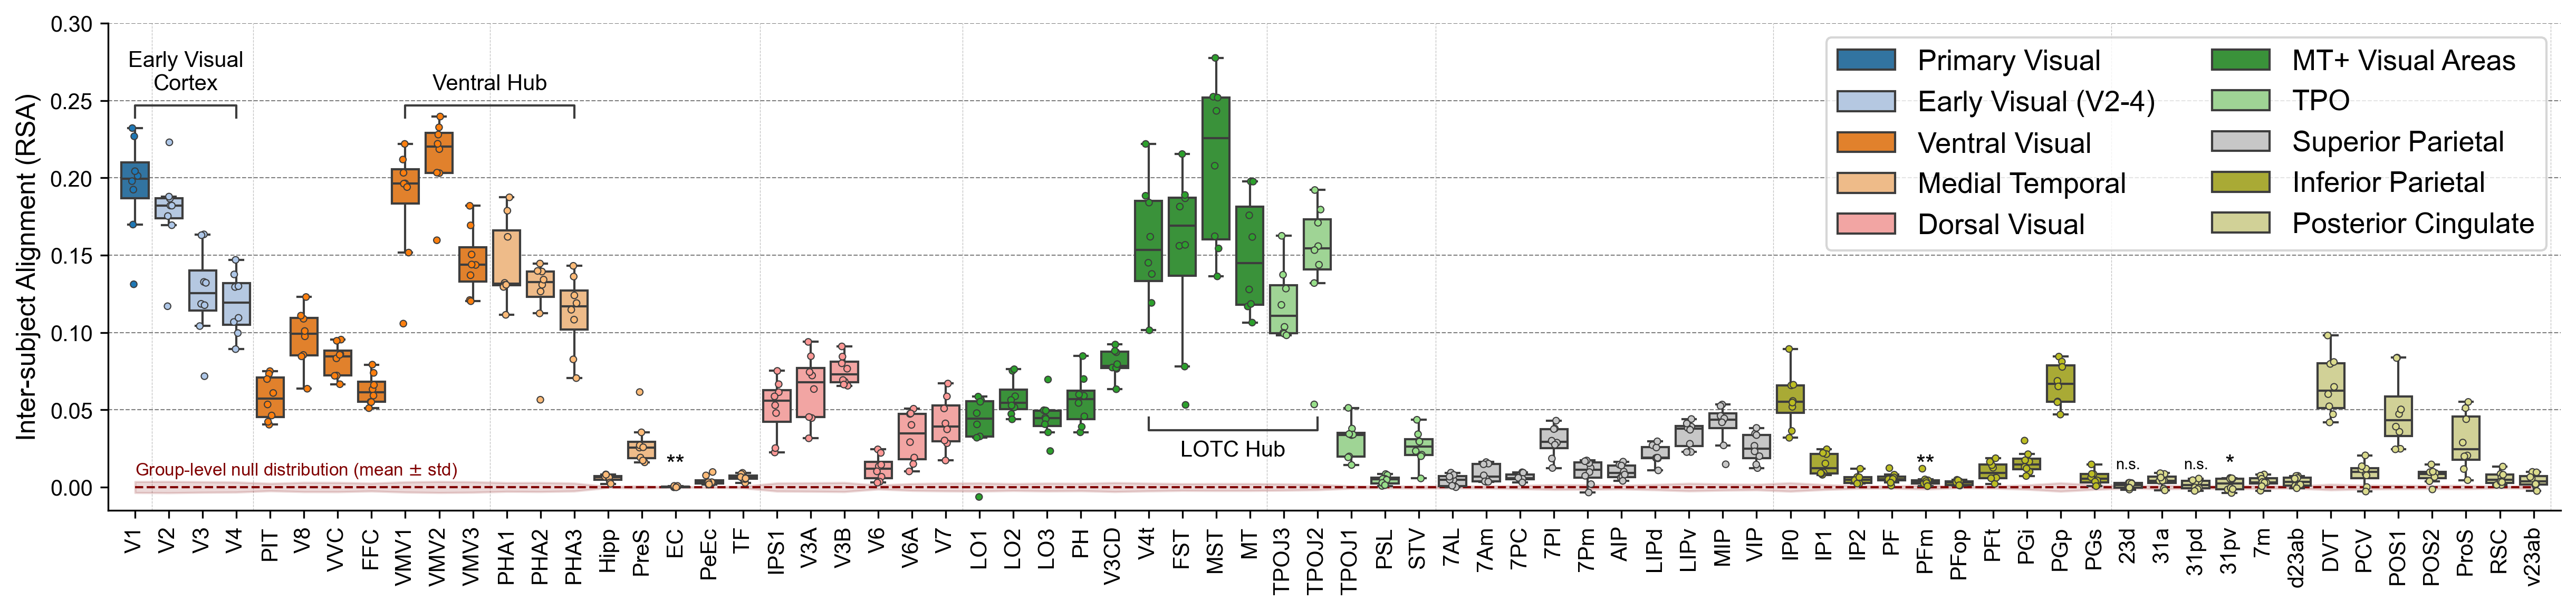

In [4]:
df = load_filename("cross_subject", shift=1, joined=True)
df_g = process_intersubject_rois(df, top=10)
order = df_g.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").drop_duplicates("name").name.tolist()
order_roi = df_g.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.tolist()
hue_order = df_g.sort_values("area_id").drop_duplicates("area_id").area.tolist()
palette = df_g.sort_values("area_id").drop_duplicates("area_id").area_color.tolist()

fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)


# Sort by order
df_subject_pvalues = pd.read_parquet(pvalues_filename).query("comparison == 'intersubject'")
df_subject_pvalues.name = df_subject_pvalues.name.replace("H", "Hipp")
df_subject_pvalues = df_subject_pvalues.set_index("roi")
#
df_subject_pvalues = df_subject_pvalues.loc[order_roi].reset_index()
display(df_subject_pvalues)

# The df_subject_pvalues is sorted in the same order that boxplots.
# Plot the mean line given by null_mean column of df_subject_pvalues
null_std = df_subject_pvalues.null_std.values
null_mean = df_subject_pvalues.null_mean.values
ax.fill_between(np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15)
ax.plot(np.arange(len(order)), df_subject_pvalues.null_mean.values, color="maroon", linestyle="--", linewidth=1)

plot_boxplot_rois(
    df_g,
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=10,
    legend_fontsize=13,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.3
)
ax.set_ylabel(r"Inter-subject Alignment (RSA)", fontsize=12)


add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.25 - 0.011, y_text=0.268 - 0.011, height=0.008, text="Early Visual\nCortex")
add_pvalue_bracket(ax=ax, x1=8, x2=13, y=0.25 - 0.011, y_text=0.268 - 0.011, height=0.008, text="Ventral Hub")
#add_pvalue_bracket(ax=ax, x1=30, x2=35, y=0.29-0.011, y_text=0.29-0.011+0.018, height=0.011, text="LOTC Hub")
add_pvalue_bracket(ax=ax, x1=30, x2=35, y=0.045, y_text=0.02, height=-0.008, text="LOTC Hub")



# Plot the area mean +- std filled as a continuous in the same order. INdexes as x


# Set yaxis (RSA) in decimal format not percentage
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.set_ylim(-0.015, 0.30)
ax.set_xlim(-0.8, 71.8)

# Set text at 0, 0 with Null Distribution (mean +- std) in maroon
#ax.text(0.5, 0.02, "Null Distribution (mean ± std)", color="maroon", fontsize=10, ha="left")
# Write using latex
ax.text(0, 0.008, r"Group-level null distribution (mean $\pm$ std)", color="maroon", fontsize=8, ha="left")

# Add p-values
apa_significance = df_subject_pvalues.apa_star.values

for i, (p, name) in enumerate(zip(apa_significance, order)):
    if p != "***":
        if p == "n.s.":
            ax.text(i, 0.012, p, fontsize=7, ha="center")
        else:
            ax.text(i, 0.01, p, fontsize=11, ha="center")

fig.savefig(output / "rsa_intersubject_boxplot_selected_shift_1.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [5]:
df_group_8 = pd.read_parquet("/Users/pablomm/Desktop/derivatives/rsa_subject_group_alignment_joined_1.parquet")

df_8 = load_filename("cross_subject", shift=1, joined=False)
df_group_8 = df_group_8.query("roi_x==roi_y").groupby(["roi_x", "subject_i"]).similarity.mean().reset_index().rename(columns={"similarity": "similarity_group"}).merge(
df_8.query("roi_x == roi_y and subject_i == 8").groupby("roi_x").similarity.mean().reset_index(), on="roi_x", how="left"
)
df_group_8[df_group_8["similarity_group"] > df_group_8.similarity].sort_values("similarity_group", ascending=False)



roi_x  subject_i  similarity_group  similarity
12        2          5          0.279494    0.098790
1274    160          3          0.248940    0.188615
8         2          1          0.248354    0.098790
9         2          2          0.244985    0.098790
11        2          4          0.244435    0.098790
...     ...        ...               ...         ...
1359    170          8         -0.000341   -0.001002
207      26          8         -0.000392   -0.000691
200      26          1         -0.000444   -0.000691
1295    162          8         -0.000609   -0.001068
1294    162          7         -0.001000   -0.001068

[1089 rows x 4 columns]

### Boxplots all areas

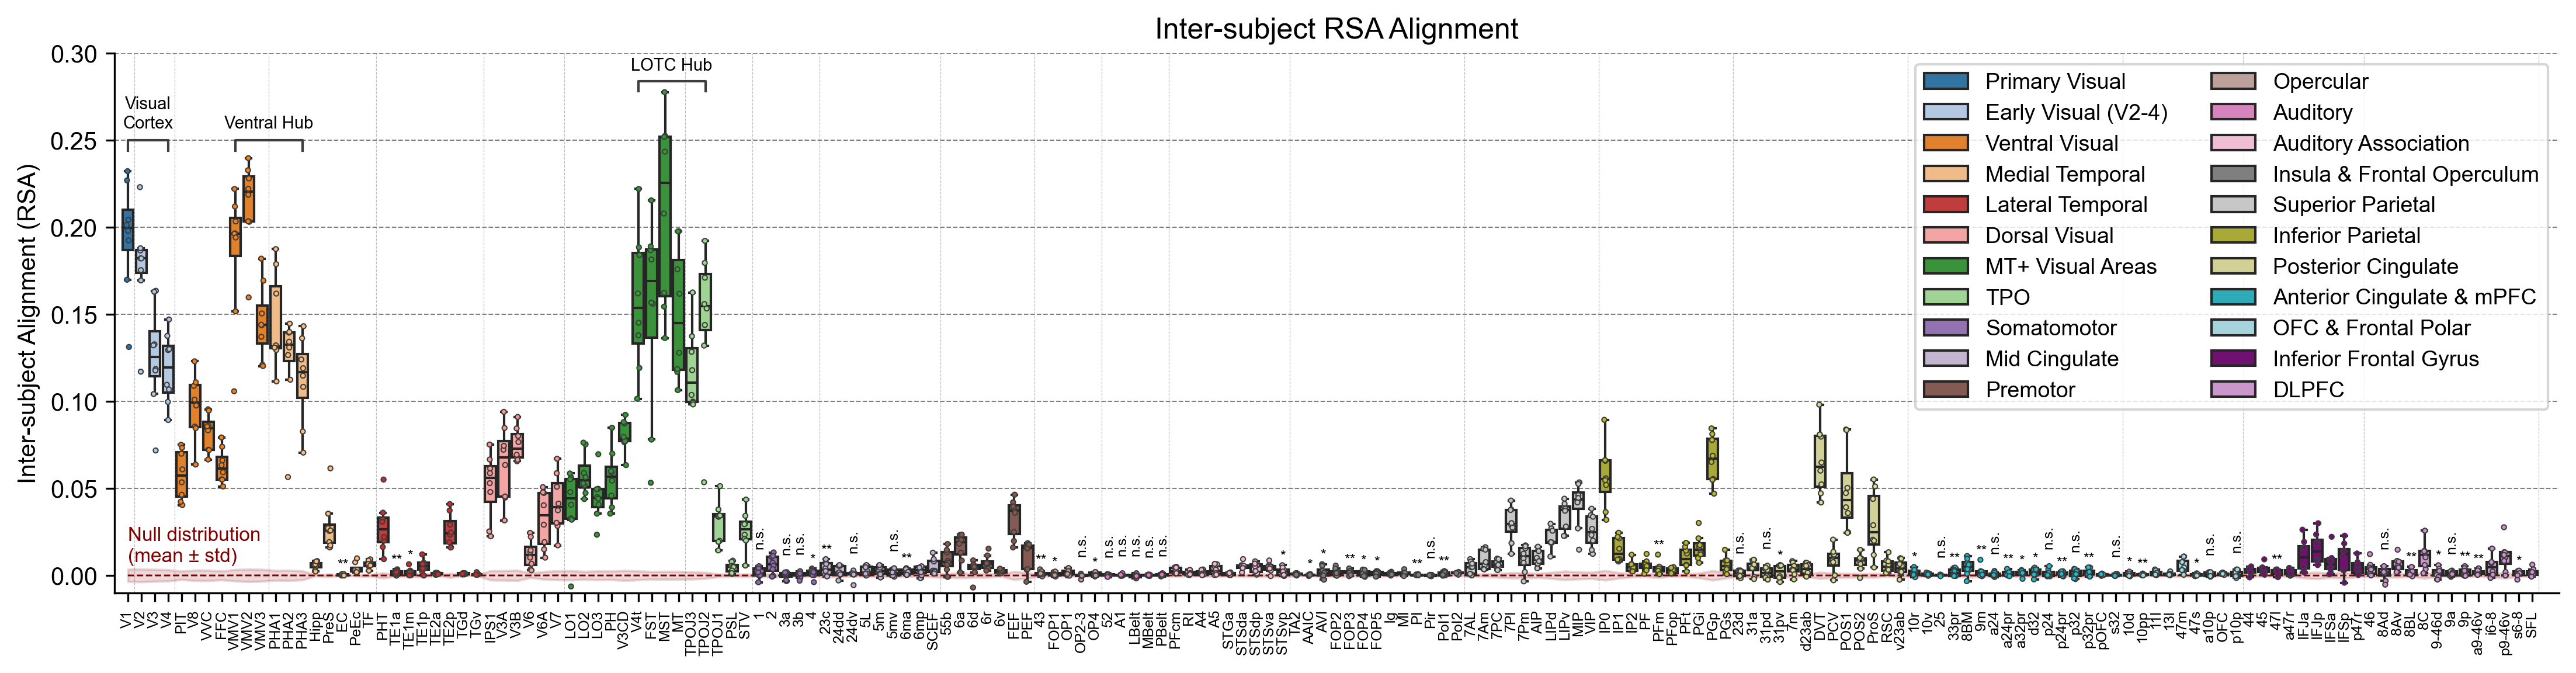

In [8]:
df = load_filename("cross_subject", shift=1, joined=True)
df_g = process_intersubject_rois(df, top=100)
order = df_g.sort_values(["area_id", "roi_order"]).drop_duplicates("name").name.unique()
order_roi = df_g.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.unique()
hue_order = list(df_g.sort_values("area_id").drop_duplicates("area_id").area.tolist())
palette = list(df_g.sort_values("area_id").drop_duplicates("area_id").area_color.tolist())
models_info = pd.read_csv(models_filename)

# Sort by order
df_subject_pvalues = pd.read_parquet(pvalues_filename).query("comparison == 'intersubject'")
df_subject_pvalues.name = df_subject_pvalues.name.replace("H", "Hipp")
df_subject_pvalues = df_subject_pvalues.set_index("roi")
#
df_subject_pvalues = df_subject_pvalues.loc[order_roi].reset_index()


fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=300)

null_mean = df_subject_pvalues.null_mean.values
null_std = df_subject_pvalues.null_std.values

ax.fill_between(np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15)
ax.plot(np.arange(len(order)), df_subject_pvalues.null_mean.values, color="maroon", linestyle="--", linewidth=0.7)

plot_boxplot_rois(
    df_g,
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=6,
    legend_fontsize=9,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.3,
    strip_size=2,
)
ax.set_ylabel("Inter-subject Alignment (RSA)")
ax.text(0, 0.008, "Null distribution\n(mean ± std)", color="maroon", fontsize=8, ha="left")

# Set yaxis (RSA) in decimal format not percentage
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.set_title("Inter-subject RSA Alignment")

apa_significance = df_subject_pvalues.apa_star.values
max_observed_values = df_g.groupby("name").aggregate({"score": "max"}).loc[order].score.values

for i, (p, name, max_observed) in enumerate(zip(apa_significance, order, max_observed_values)):
    if p != "***":
        if p == "n.s.":
            ax.text(i, max_observed + 0.01, p, fontsize=6, ha="center", rotation=90, va="bottom")
        else:
            ax.text(i, max_observed + 0.005, p, fontsize=6, ha="center", rotation=0, va="center")


add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.25 - 0.006, y_text=0.268 - 0.011, height=0.006, text="Visual\nCortex", fontsize=7)
add_pvalue_bracket(ax=ax, x1=8, x2=13, y=0.25 - 0.006 , y_text=0.268 - 0.011, height=0.006, text="Ventral Hub", fontsize=7)
add_pvalue_bracket(ax=ax, x1=38, x2=43, y=0.29-0.006-0.006, y_text=0.29-0.011+0.018-0.007, height=0.006, text="LOTC Hub", fontsize=7)


fig.savefig(output / "rsa_intersubject_boxplot_all_shift_1.pdf", bbox_inches="tight", dpi=300, transparent=True)

### Model boxplot all areas

n.s. FOP2 0.020840881
** FOP3 0.015836036
n.s. Ig 0.0044762315


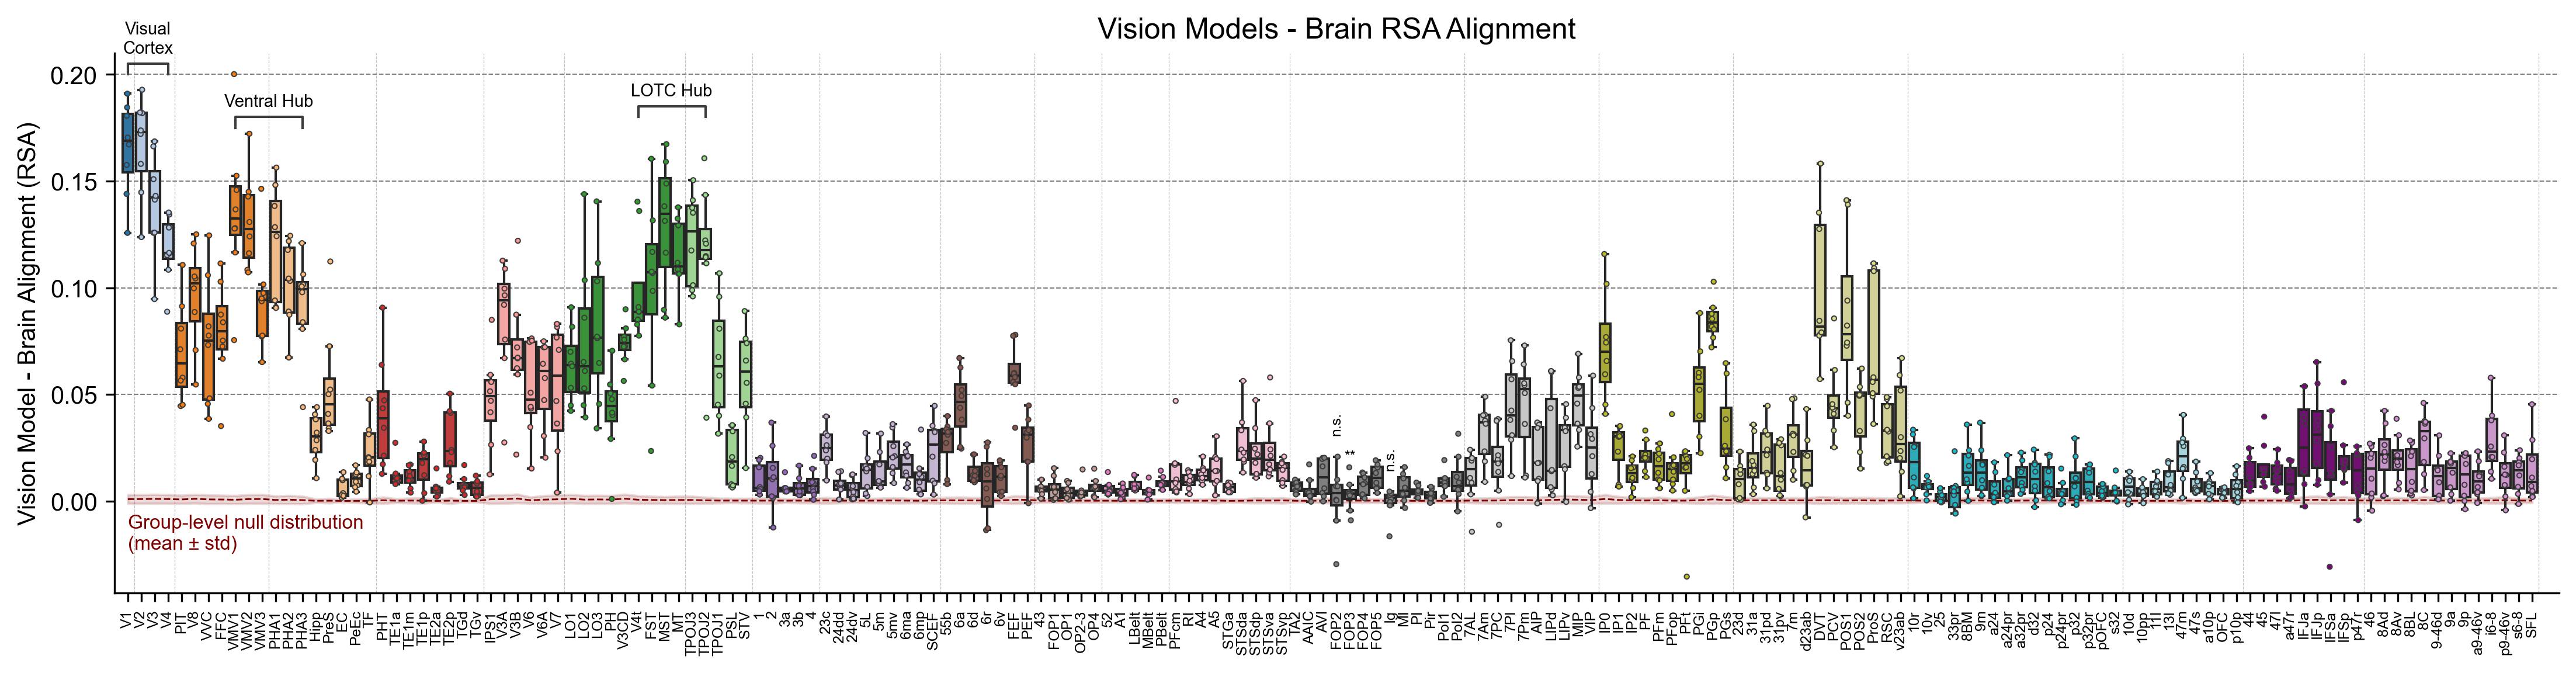

In [9]:
df_comparison_subjects = proccess_alignment(group_subject=False)
df_comparison_subjects.name = df_comparison_subjects.name.replace("H", "Hipp")
df_comparison_subjects = df_comparison_subjects.sort_values(["area_id", "roi_order"]).reset_index(drop=True)
order = df_comparison_subjects.sort_values(["area_id", "roi_order"]).drop_duplicates("name").name.unique()
order_roi = df_comparison_subjects.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.unique()
hue_order = list(df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area.tolist())
palette = list(df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area_color.tolist())
models_info = pd.read_csv(models_filename)


fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=300)

null_mean = df_comparison_subjects.drop_duplicates("roi").vision_null_mean.values
null_std = df_comparison_subjects.drop_duplicates("roi").vision_null_std.values

#

ax.fill_between(np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15)
ax.plot(np.arange(len(order)), null_mean, color="maroon", linestyle="--", linewidth=0.7)

plot_boxplot_rois(
    df_comparison_subjects.rename(columns={"vision_rsa": "score"}),
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=6,
    legend_fontsize=9,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.23,
    strip_size=2,
)
ax.set_ylabel("Vision Model - Brain Alignment (RSA)")
ax.text(0, -0.006, "Group-level null distribution\n(mean ± std)", color="maroon", fontsize=8, ha="left", va="top")

# # Set yaxis (RSA) in decimal format not percentage
# ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
# ax.set_title("Inter-subject RSA Alignment")


apa_significance = df_comparison_subjects.drop_duplicates("roi").vision_apa_star
max_observed_values = df_comparison_subjects.groupby("name").aggregate({"vision_rsa": "max"}).loc[order].vision_rsa.values

for i, (p, name, max_observed) in enumerate(zip(apa_significance, order, max_observed_values)):
    if p != "***":
        print(p, name, max_observed)
        if p == "n.s.":
            ax.text(i, max_observed + 0.01, p, fontsize=6, ha="center", rotation=90, va="bottom")
        else:
            ax.text(i, max_observed + 0.005, p, fontsize=6, ha="center", rotation=0, va="center")


add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.20, y_text=0.21, height=0.005, text="Visual\nCortex", fontsize=7)
add_pvalue_bracket(ax=ax, x1=8, x2=13, y=0.175, y_text=0.185, height=0.005, text="Ventral Hub", fontsize=7)
add_pvalue_bracket(ax=ax, x1=38, x2=43, y=0.18, y_text=0.19, height=0.005, text="LOTC Hub", fontsize=7)
ax.set_title("Vision Models - Brain RSA Alignment")
# Set decimal format
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.set_ylim(-0.043, 0.21)
fig.savefig(output / "rsa_vision_boxplot_all.pdf", bbox_inches="tight", dpi=300, transparent=True)
# Clear legend

ax.get_legend().remove()
fig.savefig(output / "rsa_vision_boxplot_all_no_legend.pdf", bbox_inches="tight", dpi=300, transparent=True)

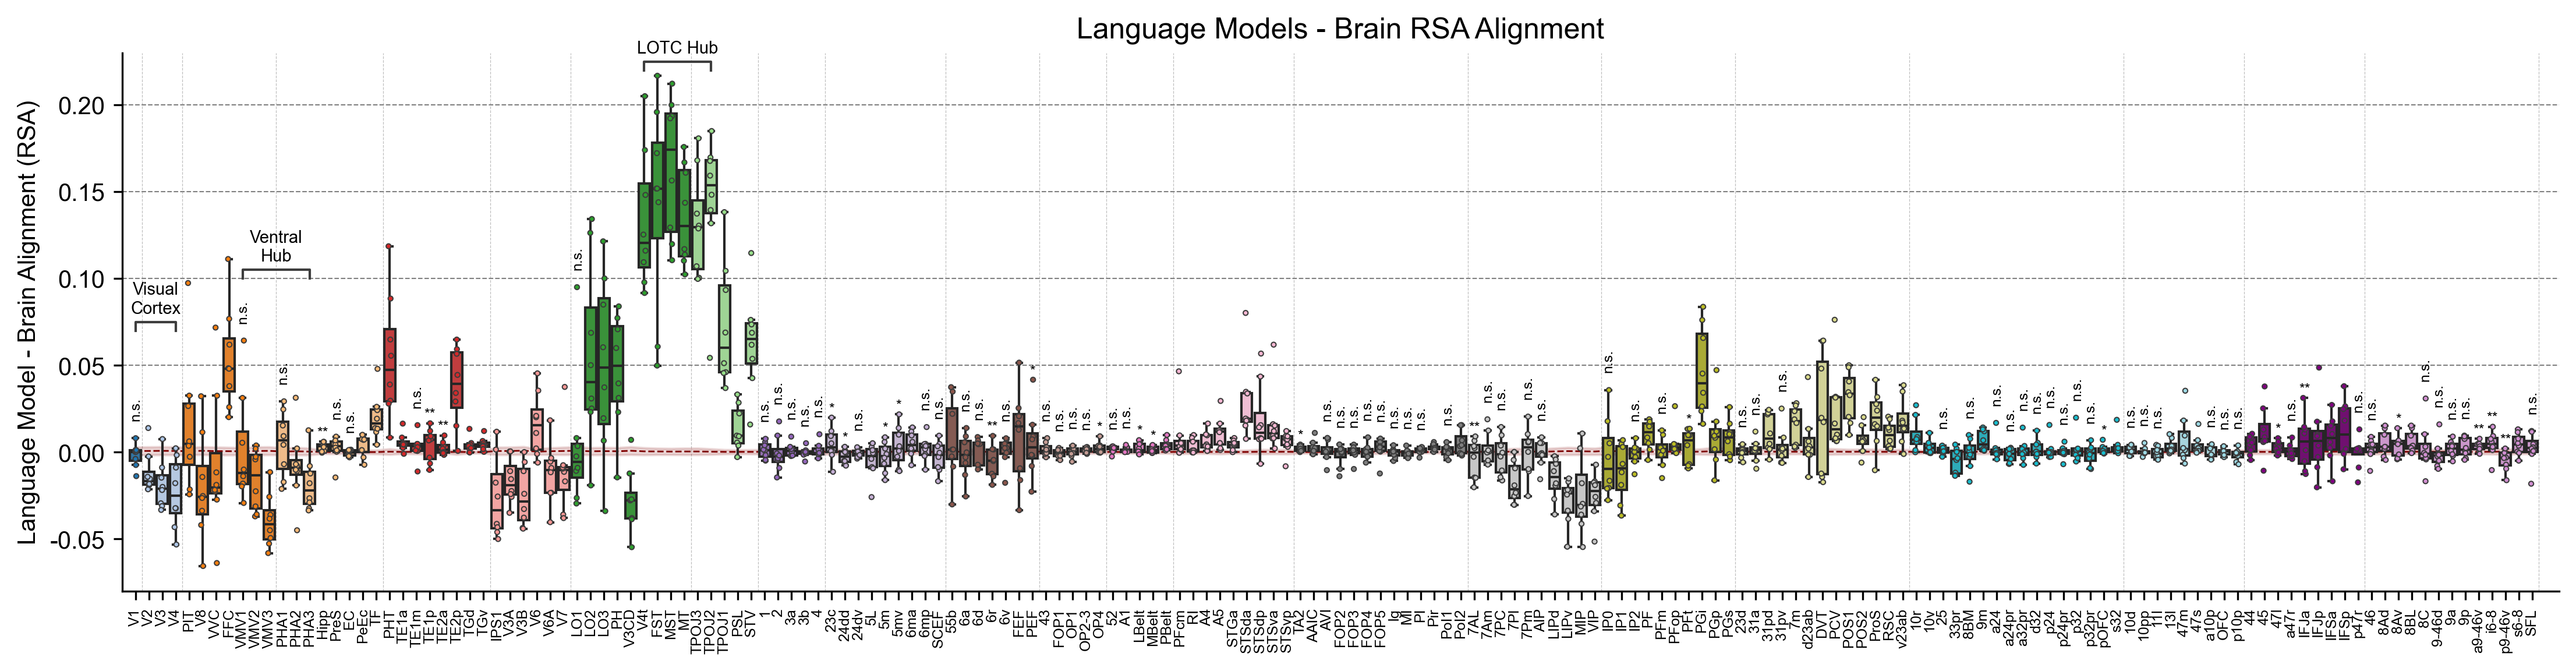

In [10]:
df_comparison_subjects = proccess_alignment(group_subject=False)
df_comparison_subjects.name = df_comparison_subjects.name.replace("H", "Hipp")
df_comparison_subjects = df_comparison_subjects.sort_values(["area_id", "roi_order"]).reset_index(drop=True)
order = df_comparison_subjects.sort_values(["area_id", "roi_order"]).drop_duplicates("name").name.unique()
order_roi = df_comparison_subjects.sort_values(["area_id", "roi_order"]).drop_duplicates("roi").roi.unique()
hue_order = list(df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area.tolist())
palette = list(df_comparison_subjects.sort_values("area_id").drop_duplicates("area_id").area_color.tolist())
models_info = pd.read_csv(models_filename)


fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=300)

null_mean = df_comparison_subjects.drop_duplicates("roi").language_null_mean.values
null_std = df_comparison_subjects.drop_duplicates("roi").language_null_std.values

#

ax.fill_between(np.arange(len(order)), null_mean - null_std, null_mean + null_std, color="maroon", alpha=0.15)
ax.plot(np.arange(len(order)), null_mean, color="maroon", linestyle="--", linewidth=0.7)

plot_boxplot_rois(
    df_comparison_subjects.rename(columns={"language_rsa": "score"}),
    ax,
    order,
    hue_order,
    palette,
    title="",
    legend=True,
    fontsize=6,
    legend_fontsize=9,
    legend_kwargs={"bbox_to_anchor": (1, 1), "title": ""},
    vmax=0.23,
    strip_size=2,
)
ax.set_ylabel("Language Model - Brain Alignment (RSA)")
# ax.text(0, 0.008, "Null distribution\n(mean ± std)", color="maroon", fontsize=8, ha="left")

# # Set yaxis (RSA) in decimal format not percentage
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
# ax.set_title("Inter-subject RSA Alignment")


apa_significance = df_comparison_subjects.drop_duplicates("roi").language_apa_star
max_observed_values = df_comparison_subjects.groupby("name").aggregate({"language_rsa": "max"}).loc[order].language_rsa.values

for i, (p, name, max_observed) in enumerate(zip(apa_significance, order, max_observed_values)):
    if p != "***":
        #print(p, name, max_observed)
        if p == "n.s.":
            ax.text(i, max_observed + 0.01, p, fontsize=6, ha="center", rotation=90, va="bottom")
        else:
            ax.text(i, max_observed + 0.005, p, fontsize=6, ha="center", rotation=0, va="center")


add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.07, y_text=0.08, height=0.005, text="Visual\nCortex", fontsize=7)
add_pvalue_bracket(ax=ax, x1=8, x2=13, y=0.1, y_text=0.11, height=0.005, text="Ventral\nHub", fontsize=7)
add_pvalue_bracket(ax=ax, x1=38, x2=43, y=0.22, y_text=0.23, height=0.005, text="LOTC Hub", fontsize=7)

ax.set_ylim(-0.08, 0.23)

ax.set_title("Language Models - Brain RSA Alignment")
fig.savefig(output / "rsa_language_boxplot_all.pdf", bbox_inches="tight", dpi=300, transparent=True)
# # Clear legend
ax.get_legend().remove()
fig.savefig(output / "rsa_language_boxplot_all_no_legend.pdf", bbox_inches="tight", dpi=300, transparent=True)

## Faverage Intersubject

In [3]:
visual_cortex = ["V1", "V2", "V3", "V4"]
ventral_cluster = ["VMV1", "VMV2", "VMV3", "PHA1", "PHA2", "PHA3"]
dorsal_cluster = ["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"]
visual_cortex_color = "gray"
ventral_cluster_color = "#3d3d3d"
dorsal_cluster_color = "#2ca02c"


df_comparison_subjects = proccess_alignment(group_subject=True, joined=False)


hcp_annotated = pd.read_csv(hcp_filename)
hcp_annotated.loc[hcp_annotated.name.isin(ventral_cluster), "area_id"] = -1
hcp_annotated.loc[hcp_annotated.name.isin(ventral_cluster), "area_color"] = ventral_cluster_color
hcp_annotated.loc[hcp_annotated.name.isin(dorsal_cluster), "area_id"] = -2
hcp_annotated.loc[hcp_annotated.name.isin(dorsal_cluster), "area_color"] = dorsal_cluster_color
hcp_annotated.loc[hcp_annotated.name.isin(visual_cortex), "area_id"] = -3

df = df_comparison_subjects.drop(columns=["name", "mne_name"]).merge(hcp_annotated[["roi", "name", "mne_name"]], on="roi")


modalities = {
    'language': {
        'column': 'language_rsa',
        'pvalue_column': 'language_p_value',
        'vmax': 0.15
    },
    'vision': {
        'column': 'vision_rsa',
        'pvalue_column': 'vision_p_value',
        'vmax': 0.15
    },
    'intersubject': {
        'column': 'intersubject_rsa',
        'pvalue_column': 'intersubject_p_value',
        'vmax': 0.2
    }
}

for modality in modalities.keys():
    params = modalities[modality]
    pvalue_column = params['pvalue_column']
    vmax = params['vmax']

    column = params['column']
    significant = df_comparison_subjects.query(f"{pvalue_column} < 0.05").name.tolist()
    df_modality = df.query(f"name in @significant")
    for hemisphere in ["lh", "rh"]:
        brain = plot_faverage_parcelation(df_modality, cmap="RdBu_r", 
                                        value_column=column,
                                        normalize=(-vmax, vmax), 
                                        default_value=None, 
                                        default_color="lightgray",
                                        hemisphere=hemisphere,
                                        size=(2*800, 2*600))
        for view in ["lateral", "medial", "ventral", "caudal"]:
            brain.show_view(view)
            brain.save_image(output / f"rsa_{modality}_{hemisphere}_{view}_{vmax:.2f}.png", mode="rgba")

        add_area_labels(brain, hcp_annotated, area_ids=[-1, -2, -3], hemispheres=[hemisphere])

        for view in ["lateral", "medial", "ventral", "caudal"]:
            brain.show_view(view)
            brain.save_image(output / f"rsa_{modality}_{hemisphere}_{view}_{vmax:.2f}_annot.png", mode="rgba")
        
        brain.close()


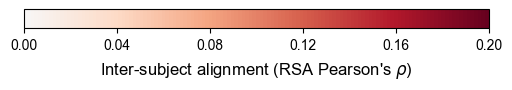

In [208]:
eps = 0.00000001
vmax = 0.20
fig_cbar, ax_cbar = plot_cbar(cmap="RdBu_r", title=r"Inter-subject alignment (RSA Pearson's $\rho$)", vmin=-vmax-eps, vmax=vmax+eps, locator=0.04, horizontal=True, rotation=0, labelpad=5, figsize = (6, 0.25), percent=False)
ax_cbar.set_xlim(0, vmax+eps)
fig_cbar.savefig(output / f"colorbar_intersubject_{vmax:.2f}_BuRd.pdf", bbox_inches="tight", dpi=300, transparent=True)



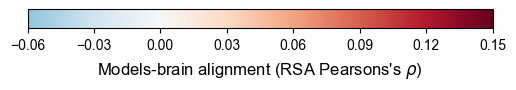

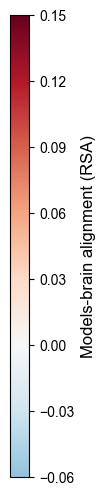

In [ ]:
vmax = 0.15
fig_cbar, ax_cbar = plot_cbar(cmap="RdBu_r", title=r"Models-brain alignment (RSA Pearsons's $\rho$)", vmin=-vmax-eps, vmax=vmax+eps, locator=0.03, horizontal=True, rotation=0, labelpad=5, figsize = (6, 0.25), percent=False)
ax_cbar.set_xlim(-0.06, vmax)
fig_cbar.savefig(output / f"colorbar_model_{vmax:.2f}_BuRd.pdf", bbox_inches="tight", dpi=300, transparent=True)


fig_cbar, ax_cbar = plot_cbar(cmap="RdBu_r", title=r"Models-brain alignment (RSA)", 
                              vmin=-vmax-eps, 
                              vmax=vmax+eps, locator=0.03, horizontal=False, 
                              rotation=90, 
                              labelpad=5, 
                              figsize = (0.25, 6), percent=False)
ax_cbar.set_ylim(-0.06, vmax)
fig_cbar.savefig(output / f"colorbar_model_{vmax:.2f}_BuRd_horizontal.pdf", bbox_inches="tight", dpi=300, transparent=True)



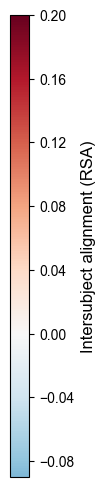

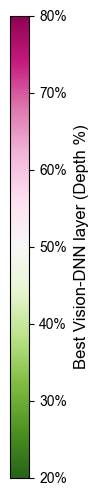

In [20]:
vmax = 0.2
eps = 0

fig_cbar, ax_cbar = plot_cbar(cmap="RdBu_r", title=r"Intersubject alignment (RSA)", 
                              vmin=-vmax-eps, 
                              vmax=vmax+eps, locator=0.04, horizontal=False, 
                              rotation=90, 
                              labelpad=5, 
                              figsize = (0.25, 6), percent=False)
ax_cbar.set_ylim(-0.09, vmax)
fig_cbar.savefig(output / f"colorbar_{vmax:.2f}_BuRd_.pdf", bbox_inches="tight", transparent=True)


fig_cbar, ax_cbar = plot_cbar(cmap="PiYG_r", title=r"Best Vision-DNN layer (Depth %)", 
                              vmin=0.2,
                              vmax=0.8, locator=.1 , horizontal=False, 
                              rotation=90, 
                              labelpad=5, 
                              figsize = (0.25, 6), percent=True)

fig_cbar.savefig(output / f"colorbar_vision_dnn_depth.pdf", bbox_inches="tight", transparent=True)


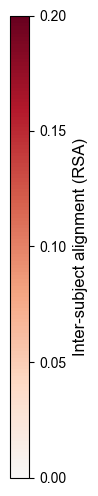

In [562]:
vmax = 0.2


fig_cbar, ax_cbar = plot_cbar(cmap="RdBu_r", title=r"Inter-subject alignment (RSA)", 
                              vmin=-vmax, 
                              vmax=vmax, locator=0.05, horizontal=False, 
                              rotation=90, 
                              labelpad=5, 
                              figsize = (0.25, 6), percent=False)
ax_cbar.set_ylim(0, vmax)
fig_cbar.savefig(output / f"colorbar_model_{vmax:.2f}_BuRd_horizontal.pdf", bbox_inches="tight", dpi=300, transparent=True)



## Model Brain comparison

In [645]:
df_comparison = proccess_alignment(group_subject=True)


[0.32938506 0.53550566]
Vision Models - Brain Pseudo-R²: 0.922 N Boostrap samples: 10000


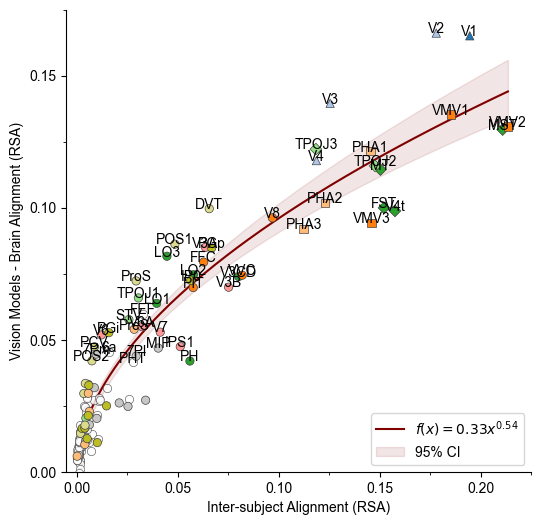

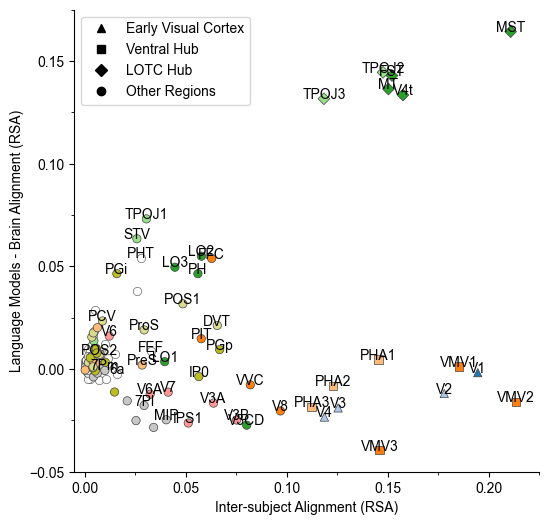

In [671]:

n_boot = 10000

top_areas = process_intersubject_rois(load_filename("cross_subject", shift=1, joined=True), top=10).area.unique()
palette = df_comparison[["area", "area_color"]].drop_duplicates().set_index("area").to_dict()["area_color"]
data = df_comparison.query("intersubject_p_value < 0.05").copy()
data = add_cluster(data)
data["top_area"] = data["area"].apply(lambda x: x in top_areas)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6))

# Adjust vision power-law

plot_comparison(data=data, x="intersubject_rsa", y="vision_rsa", ax=ax1, palette=palette)

x_fit, y_fit, y_lower, y_upper, r2, params = fit_powerlaw_zero_with_bootstrap(data["intersubject_rsa"], data["vision_rsa"], n_boot=n_boot)
print(params)
ax1.plot(x_fit, y_fit, color='maroon', label=f'$f(x)={params[0]:.2f}x^{{{params[1]:.2f}}}$', zorder=-10)
ax1.fill_between(x_fit, y_lower, y_upper, color='maroon', alpha=0.1, label='95% CI', zorder=-20)
ax1.legend(loc='lower right')
print(f"Vision Models - Brain Pseudo-R²: {r2:.3f} N Boostrap samples: {n_boot}")
#ax1.plot(np.linspace(0, 0.2, 100), np.sqrt(np.linspace(0, 0.2, 100)), color="black", linestyle="--", linewidth=0.5, zorder=-100)


#data_filtered = data#.query("p_value_fdr_bh_language < 0.05")
plot_comparison(data=data, x="intersubject_rsa", y="language_rsa", ax=ax2, palette=palette)
# xlim = ax2.get_xlim()
# Plot a gray area for regions where is is significant and language is not (intersubject_rsa > 0.05 and language_rsa < 0.05)
# x = [0.05 - 0.20] y = [0, 0.05]
#ax2.fill_between([0.05, 0.20], 0, 0.05, color="gray", alpha=0.2, zorder=-10)
# x_fit, y_fit, y_lower, y_upper, r2 = fit_powerlaw_with_bootstrap(data_filtered["intersubject_rsa"], data_filtered["language_rsa"], n_boot=n_boot)
# ax2.plot(x_fit, y_fit, color='maroon', label='Power-law fit', zorder=-10)
# ax2.fill_between(x_fit, y_lower, y_upper, color='maroon', alpha=0.1, label='95% CI', zorder=-20)
# print(f"Language Models - Brain Pseudo-R²: {r2:.3f} N Boostrap samples: {n_boot}")


# Add text with roi names in both scatters for those rois with model-brain alignment or intersubject-alignment  > 0.04

for i, row in data.iterrows():
    if row["vision_rsa"] > 0.04 or row["intersubject_rsa"] > 0.04 or row["language_rsa"] > 0.04:
        ax1.text(row["intersubject_rsa"], row["vision_rsa"], row["name"], ha="center", )
        ax2.text(row["intersubject_rsa"], row["language_rsa"], row["name"], ha="center")

ax1.set_xlabel("Inter-subject Alignment (RSA)")
ax1.set_ylabel("Vision Models - Brain Alignment (RSA)")
ax2.set_xlabel("Inter-subject Alignment (RSA)")
ax2.set_ylabel("Language Models - Brain Alignment (RSA)")
triangle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',  label='Early Visual Cortex')
square   = mlines.Line2D([], [], color='black', marker='s', linestyle='None',  label='Ventral Hub')
diamond  = mlines.Line2D([], [], color='black', marker='D', linestyle='None',  label='LOTC Hub')
circle  = mlines.Line2D([], [], color='black', marker='o', linestyle='None',  label='Other Regions')
legend_handles = [triangle, square, diamond, circle]
ax2.legend(handles=legend_handles, title="")
ax1.set_ylim(0, 0.175)
ax2.set_ylim(-0.05, 0.175)
ax1.set_xlim(-0.005, 0.225)
ax2.set_xlim(-0.005, 0.225)

#ax1.hlines(0, -0.1, 0.3, color=(0.24, 0.24, 0.24), linestyle="--", linewidth=0.5, zorder=-100)
#ax2.hlines(0, -0.1, 0.3, color=(0.24, 0.24, 0.24), linestyle="--", linewidth=0.5, zorder=-100)

# Add a major tick every 0.05
# Add a minor tick every 0.025
for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.025))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.025))
#ax1.set_title("Vision Models - Brain Alignment")
#ax2.set_title("Language Models - Brain Alignment")

fig1.savefig(output / "rsa_models_vision_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)
fig2.savefig(output / "rsa_models_language_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)




In [669]:
df = pd.read_parquet("/Users/pablomm/Desktop/derivatives/rsa_subject_group_alignment_joined_1.parquet")
df = df.query("roi_x == roi_y").groupby("roi_x").similarity.mean().reset_index()
df

roi_x  similarity
0        1    0.199703
1        2    0.208294
2        3    0.012981
3        4    0.184311
4        5    0.132386
..     ...         ...
175    176    0.004710
176    177    0.001554
177    178    0.000433
178    179    0.000898
179    180    0.001037

[180 rows x 2 columns]

cluster                  comparison     t_stat       p_value  \
0    Visual Cortex  vision_rsa vs language_rsa  19.039129  2.744085e-07   
1  Ventral Cluster  vision_rsa vs language_rsa  19.994274  1.958745e-07   
2   Dorsal Cluster  vision_rsa vs language_rsa  -8.678705  5.400182e-05   

   mean_diff   p_corrected apa_star  
0   0.161150  8.232255e-07      ***  
1   0.125294  5.876235e-07      ***  
2  -0.028736  1.620054e-04      ***

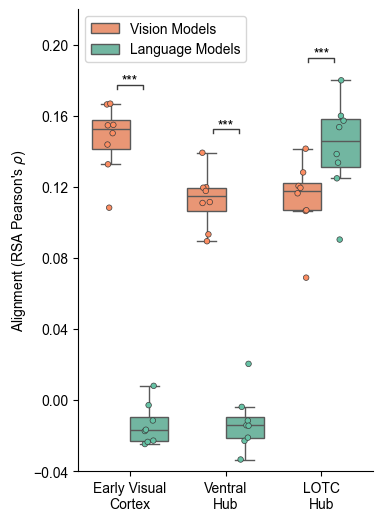

In [35]:
#df_comparison_subjects = proccess_alignment(group_subject=False)
#df_comparison_subjects = add_cluster(df_comparison_subjects)
df_comparison_subjects_grouped = df_comparison_subjects.groupby(["subject", "cluster"]).aggregate({"intersubject_rsa": "mean", "vision_rsa": "mean", "language_rsa": "mean"}).reset_index()
df_comparison_subjects_test = df_comparison_subjects_grouped.query("cluster != 'Other'").copy()
# Boxplot
fig, ax = plt.subplots(1, 1, figsize=(3.8, 6))
#fig, ax = plt.subplots(1, 1, figsize=(8, 3))

order = ["Visual\nCortex", "Ventral\nHub", "Dorsal\nHub"]
df_comparison_subjects_grouped.cluster = df_comparison_subjects_grouped.cluster.str.replace(" ", "\n").str.replace("Cluster", "Hub")
hue_names = {
    "intersubject_rsa": "Inter-subject",
    "vision_rsa": "Vision Models",
    "language_rsa": "Language Models"
}
#hue_order = ["Inter-subject", "Vision Models", "Language Models"]
hue_order = [ "Vision Models", "Language Models"]
#hue_order = ["Vision", "Language"]
df_comparison_subjects_grouped = df_comparison_subjects_grouped.rename(columns=hue_names)
df_comparison_subjects_grouped = df_comparison_subjects_grouped.melt(id_vars=["subject", "cluster"], var_name="modality", value_name="score").copy()
df_comparison_subjects_grouped
from cmap import Colormap

cm = Colormap('colorbrewer:Set2_3').to_matplotlib()([0.5, 0, 1])
cm = list(list(c) for c in cm)[:2]
sns.boxplot(data=df_comparison_subjects_grouped,
            x="cluster", y="score", hue="modality", ax=ax, order=order,
            hue_order=hue_order,
            palette=cm, showfliers=False, # width=0.5,
)
# Plot individual points with jitter
sns.stripplot(data=df_comparison_subjects_grouped, x="cluster", y="score", hue="modality", ax=ax, order=order,
            hue_order=hue_order, palette=cm, 
            dodge=True, alpha=1, linewidth=0.5, size=4, jitter=True, edgecolor=(0.24, 0.24, 0.24), zorder=100, legend=False)

ax.set_xlabel("")
ax.set_ylabel(r"Alignment (RSA Pearson's $\rho$)")
# Remove title from legend
ax.legend(title="", loc='upper left')#, bbox_to_anchor=(0, 0.3))

# xticks from each 0.05
ax.set_yticks(np.arange(-0.04, 0.21, 0.04))

sns.despine(ax=ax)

import pandas as pd
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel

# Define dataframe
df_comparison_subjects_test

# Define comparisons explicitly
comparisons = [
    ("Visual Cortex", "vision_rsa", "language_rsa"),
    ("Ventral Cluster", "vision_rsa", "language_rsa"),
    ("Dorsal Cluster", "vision_rsa", "language_rsa"),
    #("Dorsal Cluster", "language_rsa", "intersubject_rsa"),
    #("Visual Cortex", "vision_rsa", "intersubject_rsa"),
]

results = []
for cluster, cond1, cond2 in comparisons:
    subset = df_comparison_subjects_test.query("cluster == @cluster")
    t_stat, p_value = ttest_rel(subset[cond1], subset[cond2])

    results.append({
        "cluster": cluster,
        "comparison": f"{cond1} vs {cond2}",
        "t_stat": t_stat,
        "p_value": p_value,
        "mean_diff": subset[cond1].mean() - subset[cond2].mean(),
    })

# Convert to dataframe
results_df = pd.DataFrame(results)

# Correct p-values (FDR correction)
results_df["p_corrected"] = multipletests(results_df["p_value"], method="bonferroni")[1]#.round(5)
results_df["apa_star"] = results_df["p_corrected"].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'n.s.')))


# Show results
display(results_df)
ax.set_ylim(-0.040, 0.22)
width = 0.135
add_pvalue_bracket(ax=ax, x1=-width, x2=width, y=0.175, height=0.0025, text='***')
add_pvalue_bracket(ax=ax, x1=1-width, x2=1+width, y=0.15, height=0.0025, text='***')
add_pvalue_bracket(ax=ax, x1=2-width, x2=2 + width, y=0.19, height=0.0025, text='***')

ax.set_xticks([0, 1,2])
ax.set_xticklabels(["Early Visual\nCortex", "Ventral\nHub", "LOTC\nHub"])
#add_pvalue_bracket(ax=ax, x1=-width, x2=0, y=0.185, height=0.0025, text='n.s.')
fig.savefig(output / "rsa_modality_boxplot_comparison.pdf", bbox_inches="tight", transparent=True)
#fig.savefig(output / "rsa_modality_boxplot_comparison_widder.pdf", bbox_inches="tight", dpi=300, transparent=True)

## Hemisphere comparison

In [37]:
df_comparison_separated_subjects = proccess_alignment(group_subject=False, joined=False)

df_comparison_separated_subjects_lh = df_comparison_separated_subjects[["roi", "subject", "intersubject_rsa", "language_rsa", "vision_rsa", "intersubject_p_value"]].query("roi<=180").copy()
df_comparison_separated_subjects_rh = df_comparison_separated_subjects[["roi", "subject", "intersubject_rsa", "language_rsa", "vision_rsa", "intersubject_p_value"]].query("roi>180").copy()
df_comparison_separated_subjects_rh = df_comparison_separated_subjects_rh.rename(columns={"intersubject_rsa": "intersubject_rsa_rh", "language_rsa": "language_rsa_rh", "vision_rsa": "vision_rsa_rh"})
df_comparison_separated_subjects_rh = df_comparison_separated_subjects_rh.drop(columns="intersubject_p_value")
df_comparison_separated_subjects_rh.roi = df_comparison_separated_subjects_rh.roi - 180
df_comparison_separated_subjects_lh = df_comparison_separated_subjects_lh.rename(columns={"intersubject_rsa": "intersubject_rsa_lh", "language_rsa": "language_rsa_lh", "vision_rsa": "vision_rsa_lh"})
df_comparison_separated_hemispheres_subjects = df_comparison_separated_subjects_lh.merge(df_comparison_separated_subjects_rh, on=["roi", "subject"])
df_comparison_separated_hemispheres_subjects

# Functions for paired t-tests
def paired_ttest(group, col_lh, col_rh):
    t_stat, p_val = ttest_rel(group[col_lh], group[col_rh])
    return pd.Series({f't_stat_{col_lh[:-3]}': t_stat, f'p_value_{col_lh[:-3]}': p_val})

# Perform groupby and apply t-tests separately
results_intersubject = df_comparison_separated_hemispheres_subjects.groupby('roi').apply(
    paired_ttest, 'intersubject_rsa_lh', 'intersubject_rsa_rh', include_groups=False)

results_vision = df_comparison_separated_hemispheres_subjects.groupby('roi').apply(
    paired_ttest, 'vision_rsa_lh', 'vision_rsa_rh', include_groups=False)

results_language = df_comparison_separated_hemispheres_subjects.groupby('roi').apply(
    paired_ttest, 'language_rsa_lh', 'language_rsa_rh', include_groups=False)

# Merge all results into a single dataframe
results_df = pd.concat([results_intersubject, results_vision, results_language], axis=1).reset_index()
results_df
# # Correct for multiple comparisons (FDR) for each modality separately
for p_value_modality in ['p_value_intersubject_rsa', 'p_value_vision_rsa', 'p_value_language_rsa']:
    corrected = multipletests(results_df[p_value_modality], method='fdr_bh')[1]
    results_df[f'corrected_{p_value_modality}'] = corrected


results_df

roi  t_stat_intersubject_rsa  p_value_intersubject_rsa  \
0      1                 3.386236                  0.011659   
1      2                -2.978682                  0.020553   
2      3                -0.732282                  0.487784   
3      4                 4.306593                  0.003538   
4      5                 4.114241                  0.004492   
..   ...                      ...                       ...   
175  176                -3.039053                  0.018872   
176  177                -2.251232                  0.059091   
177  178                -2.043688                  0.080275   
178  179                -0.847237                  0.424879   
179  180                -1.140497                  0.291593   

     t_stat_vision_rsa  p_value_vision_rsa  t_stat_language_rsa  \
0             2.454404            0.043823            -1.040413   
1            -1.114396            0.301903            -1.293093   
2            -0.501618            0.631325            -0.197528   
3             1.769171            0.120182             1.023360   
4             1.788731            0.116794            -1.639653   
..                 ...                 ...                  ...   
175          -0.866885            0.414730            -1.489436   
176          -0.524199            0.616324             0.147413   
177          -1.673123            0.138219            -0.961645   
178          -1.114226            0.301972             0.126136   
179           0.370136            0.722227             0.651545   

     p_value_language_rsa  corrected_p_value_intersubject_rsa  \
0                0.332744                            0.072594   
1                0.237016                            0.087387   
2                0.849027                            0.622704   
3                0.340196                            0.035379   
4                0.145085                            0.038076   
..                    ...                                 ...   
175              0.179985                            0.087387   
176              0.886962                            0.180736   
177              0.368261                            0.212677   
178              0.903171                            0.578600   
179              0.535492                            0.437389   

     corrected_p_value_vision_rsa  corrected_p_value_language_rsa  
0                        0.315528                        0.750276  
1                        0.574642                        0.670103  
2                        0.800271                        0.931859  
3                        0.464087                        0.750276  
4                        0.464087                        0.609694  
..                            ...                             ...  
175                      0.644242                        0.639705  
176                      0.786797                        0.939136  
177                      0.492168                        0.750276  
178                      0.574642                        0.939715  
179                      0.850563                        0.774202  

[180 rows x 10 columns]

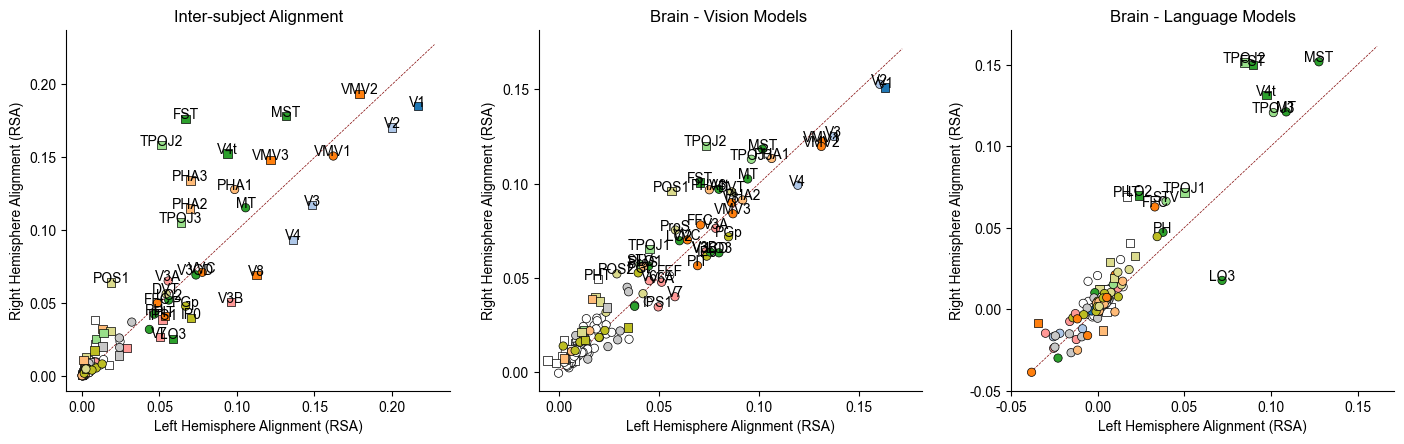

In [38]:
df_comparison_separated = proccess_alignment(group_subject=True, joined=False)

df_comparison_separated_lh = df_comparison_separated[["roi", "intersubject_rsa", "language_rsa", "vision_rsa", "intersubject_p_value"]].query("roi<=180").copy()
df_comparison_separated_rh = df_comparison_separated[["roi", "intersubject_rsa", "language_rsa", "vision_rsa", "intersubject_p_value"]].query("roi>180").copy()
df_comparison_separated_rh = df_comparison_separated_rh.rename(columns={"intersubject_rsa": "intersubject_rsa_rh", "language_rsa": "language_rsa_rh", "vision_rsa": "vision_rsa_rh"})
df_comparison_separated_rh = df_comparison_separated_rh.drop(columns="intersubject_p_value")
df_comparison_separated_rh.roi = df_comparison_separated_rh.roi - 180
df_comparison_separated_lh = df_comparison_separated_lh.rename(columns={"intersubject_rsa": "intersubject_rsa_lh", "language_rsa": "language_rsa_lh", "vision_rsa": "vision_rsa_lh"})
df_comparison_separated_hemispheres = df_comparison_separated_lh.merge(df_comparison_separated_rh, on="roi")
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "mne_name", "area", "area_color"]]
df_comparison_separated_hemispheres = df_comparison_separated_hemispheres.merge(hcp, on="roi")
df_comparison_separated_hemispheres = df_comparison_separated_hemispheres.query("intersubject_p_value < 0.05").copy()

area_order = df_comparison_separated_hemispheres.sort_values("area").drop_duplicates("area").area.tolist()
palette = df_comparison_separated_hemispheres.sort_values("area").drop_duplicates("area").area_color.tolist()
whites = ["white"] * len(palette)
top_areas = process_intersubject_rois(load_filename("cross_subject", shift=1, joined=True), top=10).area.unique()

s = 4.8
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*s, s))


level = 0.05
df_comparison_separated_hemispheres["intersubject_significant"] = (results_df["p_value_intersubject_rsa"] < level).map({True: "Significant", False: "Not Significant"})
df_comparison_separated_hemispheres["vision_significant"] = (results_df["p_value_vision_rsa"] < level).map({True: "Significant", False: "Not Significant"})
df_comparison_separated_hemispheres["language_significant"] = (results_df["p_value_language_rsa"] < level).map({True: "Significant", False: "Not Significant"})

style_order = {"Significant": "s", "Not Significant": "o"}


sns.scatterplot(data=df_comparison_separated_hemispheres.query("area not in @top_areas"), x="intersubject_rsa_lh", y="intersubject_rsa_rh", hue="area", palette=whites, ax=ax1, legend=False, edgecolor="black", linewidth=0.5, hue_order=area_order, style="intersubject_significant", markers=style_order)
sns.scatterplot(data=df_comparison_separated_hemispheres.query("area in @top_areas"), x="intersubject_rsa_lh", y="intersubject_rsa_rh", hue="area", palette=palette, ax=ax1, legend=False, edgecolor="black", linewidth=0.5, hue_order=area_order, style="intersubject_significant", markers=style_order)

sns.scatterplot(data=df_comparison_separated_hemispheres.query("area not in @top_areas"), x="vision_rsa_lh", y="vision_rsa_rh", hue="area", palette=whites, legend=False, ax=ax2, edgecolor="black", linewidth=0.5, hue_order=area_order, style="vision_significant", markers=style_order)
sns.scatterplot(data=df_comparison_separated_hemispheres.query("area in @top_areas"), x="vision_rsa_lh", y="vision_rsa_rh", hue="area", palette=palette, legend=False, ax=ax2, edgecolor="black", linewidth=0.5, hue_order=area_order, style="vision_significant", markers=style_order)


sns.scatterplot(data=df_comparison_separated_hemispheres.query("area not in @top_areas"), x="language_rsa_lh", y="language_rsa_rh", hue="area", palette=whites, legend=False, ax=ax3, edgecolor="black", linewidth=0.5, hue_order=area_order, style="language_significant", markers=style_order)
sns.scatterplot(data=df_comparison_separated_hemispheres.query("area in @top_areas"), x="language_rsa_lh", y="language_rsa_rh", hue="area", palette=palette, legend=False, ax=ax3, edgecolor="black", linewidth=0.5, hue_order=area_order, style="language_significant", markers=style_order)

p_values = ["", "corrected_p_value_vision_rsa", "corrected_p_value_language_rsa"]

for i, ax in enumerate([ax1, ax2, ax3]):
    # Get xlim and y lim and set the same (from 0 to max of both)
    eps = 0.01
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    max_value = max(xlim[1], ylim[1])
    if i < 2:
        ax.set_xlim(0-eps, max_value+eps)
        ax.set_ylim(0-eps, max_value+eps)
        ax.plot([0, max_value], [0, max_value], color="maroon", linestyle="--", linewidth=0.5, zorder=-100)
    else:
        ax.set_xlim(-0.04-eps, max_value+eps)
        ax.set_ylim(-0.04-eps, max_value+eps)
        ax.plot([-0.04, max_value], [-0.04, max_value], color="maroon", linestyle="--", linewidth=0.5, zorder=-100)
    sns.despine(ax=ax)
    
    ax.set_xlabel("Left Hemisphere Alignment (RSA)")
    ax.set_ylabel("Right Hemisphere Alignment (RSA)")
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))

ax1.set_title("Inter-subject Alignment")
ax2.set_title("Brain - Vision Models ")
ax3.set_title("Brain - Language Models")

# Add text in scatters as labels of dots if intersubject_rsa_lh > 0.05 or intersubject_rsa_rh > 0.05 (same vision and language)
for ax, modality in zip([ax1, ax2, ax3], ["intersubject_rsa", "vision_rsa", "language_rsa"]):
    for i, row in df_comparison_separated_hemispheres.iterrows():
        if row[f"{modality}_lh"] > 0.045 or row[f"{modality}_rh"] > 0.045:
            ax.text(row[f"{modality}_lh"], row[f"{modality}_rh"], row["name"], ha="center")

# Add pad between subplots
plt.tight_layout(pad=2.0)

# Save as svg
# fig.savefig(output / "rsa_hemispheres_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)




In [39]:
# Spearman corr
from scipy.stats import spearmanr
print(spearmanr(df_comparison_separated_hemispheres.intersubject_rsa_lh, df_comparison_separated_hemispheres.intersubject_rsa_rh))
print(spearmanr(df_comparison_separated_hemispheres.vision_rsa_lh, df_comparison_separated_hemispheres.vision_rsa_rh))
print(spearmanr(df_comparison_separated_hemispheres.language_rsa_lh, df_comparison_separated_hemispheres.language_rsa_rh))


SignificanceResult(statistic=np.float64(0.9304355645966546), pvalue=np.float64(1.82078606819449e-69))
SignificanceResult(statistic=np.float64(0.9237808470655362), pvalue=np.float64(1.667472350783365e-66))
SignificanceResult(statistic=np.float64(0.8222576423818059), pvalue=np.float64(8.82685559483811e-40))


(np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

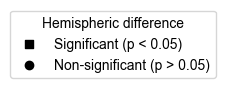

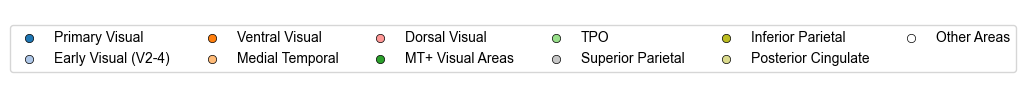

In [40]:
# Create a legend with black scatter one o and other squared with Significant and non-significant and title t(7) paired t-test
fig, ax = plt.subplots(figsize=(2, 1))
ax.scatter([], [], marker='s', color='black', label='Significant (p < 0.05)')
ax.scatter([], [], marker='o', color='black', label='Non-significant (p > 0.05)')
ax.legend(title='Hemispheric difference', loc='center')
ax.axis('off')  # Hide the axes
fig.tight_layout()
fig.savefig(output / "legend_significant.pdf", bbox_inches="tight", dpi=300, transparent=True)


# top_areas
hcp = pd.read_csv(hcp_filename)
areas = hcp.query("area in @top_areas").drop_duplicates("area").sort_values("area_id")[["area", "area_color"]].set_index("area").to_dict()["area_color"]

# Make a legend with the top areas as scatter
fig, ax = plt.subplots(figsize=(2, 1))
for area, color in areas.items():
    ax.scatter([], [], marker='o', color=color, label=area, linewidths=0.5, edgecolor="black")
    
# Add other areas white
ax.scatter([], [], marker='o', color='white', label="Other Areas", linewidths=0.5, edgecolor="black")

ax.legend(title='', loc='center', ncol=6)
ax.axis('off')  # Hide the axes

#fig.savefig(output / "legend_areas_top.pdf", bbox_inches="tight", dpi=300, transparent=True)


cluster                                  comparison     t_stat  \
0  Visual Cortex  intersubject_rsa_lh vs intersubject_rsa_rh   6.337774   
1    Ventral Hub  intersubject_rsa_lh vs intersubject_rsa_rh  -6.509373   
2     Dorsal Hub  intersubject_rsa_lh vs intersubject_rsa_rh -10.006456   
3  Visual Cortex              vision_rsa_lh vs vision_rsa_rh   2.590001   
4    Ventral Hub              vision_rsa_lh vs vision_rsa_rh  -0.083793   
5     Dorsal Hub              vision_rsa_lh vs vision_rsa_rh  -3.557691   
6     Dorsal Hub          language_rsa_lh vs language_rsa_rh  -5.398607   

    p_value  mean_diff  p_corrected apa_significance      modality  
0  0.000390   0.033805      0.00091              ***  intersubject  
1  0.000331  -0.028160      0.00091              ***  intersubject  
2  0.000021  -0.062219      0.00015              ***  intersubject  
3  0.035945   0.013143      0.04194                *        vision  
4  0.935567  -0.000663      0.93557             n.s.        vision  
5  0.009248  -0.022442      0.01295                *        vision  
6  0.001010  -0.035936      0.00177               **      language

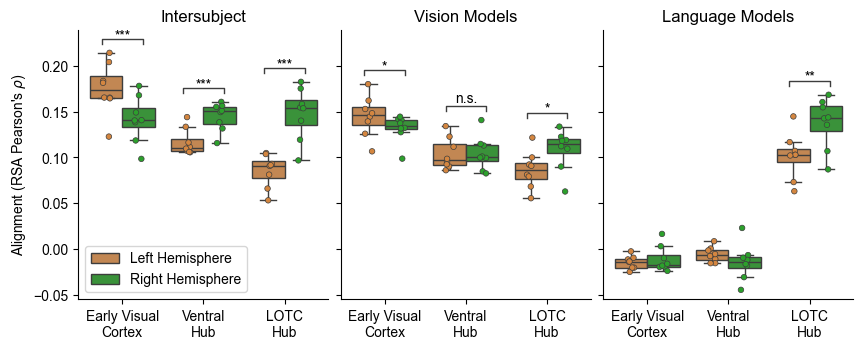

In [44]:
hcp = pd.read_csv(hcp_filename)

df_hemispheres_clusters = add_cluster(df_comparison_separated_hemispheres_subjects.merge(hcp[["roi", "name", "mne_name", "area", "area_color"]], on="roi"))

df_hemispheres_clusters.cluster = df_hemispheres_clusters.cluster.str.replace("Cluster", "Hub")
df_hemispheres_clusters = df_hemispheres_clusters.query("cluster != 'Other'").copy()
df_hemispheres_clusters = df_hemispheres_clusters.groupby(["cluster", "subject"]).aggregate({
    'language_rsa_lh': 'mean',
    'language_rsa_rh': 'mean',
    'vision_rsa_lh': 'mean',
    'vision_rsa_rh': 'mean',
    'intersubject_rsa_lh': 'mean',
    'intersubject_rsa_rh': 'mean',
}).reset_index()

# Unpivot the dataframe. Index: cluster and subject. Columns: modality. Values: score
df_hemispheres_clusters = df_hemispheres_clusters.melt(id_vars=["cluster", "subject"], var_name="modality", value_name="score").copy()
# Add hemisphere (last split _ of modality)
# Add modality (First split _ of modality)
df_hemispheres_clusters["hemisphere"] = df_hemispheres_clusters.modality.str.split("_").str[-1].replace({"lh": "Left Hemisphere", "rh": "Right Hemisphere"})
df_hemispheres_clusters["modality"] = df_hemispheres_clusters.modality.str.split("_").str[0]


# 3 subplots. hue is hemisphere, x is cluster, y is score, cols is modality
# Reduce the horizontal spacing for joining the plots
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, gridspec_kw={'wspace': 0.05})
# Set order of clusters
order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
# Set order of modalities
modality_order = ["intersubject", "vision", "language"]
# Set order of hemispheres
hemisphere_order = ["Left Hemisphere", "Right Hemisphere"]

# Set palette
palette = ["#D48640", "#2ca02c"]



# Perform all pairwise t-tests for each cluster
# Define comparisons explicitly
comparions = [
    ("Visual Cortex", "intersubject_rsa_lh", "intersubject_rsa_rh"),
    ("Ventral Hub", "intersubject_rsa_lh", "intersubject_rsa_rh"),
    ("Dorsal Hub", "intersubject_rsa_lh", "intersubject_rsa_rh"),
    ("Visual Cortex", "vision_rsa_lh", "vision_rsa_rh"),
    ("Ventral Hub", "vision_rsa_lh", "vision_rsa_rh"),
    ("Dorsal Hub", "vision_rsa_lh", "vision_rsa_rh"),
    #("Visual Cortex", "language_rsa_lh", "language_rsa_rh"),
    #("Ventral Hub", "language_rsa_lh", "language_rsa_rh"),
    ("Dorsal Hub", "language_rsa_lh", "language_rsa_rh")
]
results = []
for cluster, cond1, cond2 in comparions:
    modality = cond1.split("_")[0]
    subset = df_hemispheres_clusters.query("cluster == @cluster and modality == @modality")
    left_subset = subset.query("hemisphere == 'Left Hemisphere'")
    right_subset = subset.query("hemisphere == 'Right Hemisphere'")
    t_stat, p_value = ttest_rel(left_subset["score"], right_subset["score"])
    mean_diff = left_subset["score"].mean() - right_subset["score"].mean()


    results.append({
        "cluster": cluster,
        "comparison": f"{cond1} vs {cond2}",
        "t_stat": t_stat,
        "p_value": p_value,
        "mean_diff": mean_diff,
    })

# Convert to dataframe
results_df_cluster = pd.DataFrame(results)

# Corrected p-values (FDR correction)
results_df_cluster["p_corrected"] = multipletests(results_df_cluster["p_value"], method="fdr_bh")[1].round(5)
results_df_cluster["apa_significance"] = results_df_cluster["p_corrected"].apply(lambda x: "*" * int(-np.log10(x)) if x < 0.05 else "n.s.")
results_df_cluster["modality"] = results_df_cluster["comparison"].str.split("_").str[0]



for i, (ax, modality) in enumerate(zip(axes, modality_order)):
    sns.boxplot(data=df_hemispheres_clusters.query("modality == @modality"), x="cluster", y="score", hue="hemisphere", ax=ax, order=order, hue_order=hemisphere_order, palette=palette, legend=i==0, showfliers=False)
    # Plot individual points with jitter
    sns.stripplot(data=df_hemispheres_clusters.query("modality == @modality"), 
                  x="cluster", y="score", hue="hemisphere", ax=ax, order=order,
                    hue_order=hemisphere_order, palette=palette,  
                    dodge=True, alpha=1, linewidth=0.5, size=4, jitter=True, edgecolor=(0.24, 0.24, 0.24), zorder=100, legend=False)
    ax.set_xlabel("")
    ax.set_ylim(-0.055, 0.24)
    sns.despine(ax=ax)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["Early Visual\nCortex", "Ventral\nHub", "LOTC\nHub"])

    # Add p-value brackets
    for j, cluster in enumerate(order):
        # Get the p-value for the current cluster and modality
        p_value = results_df_cluster.query("cluster == @cluster and modality == @modality")["p_corrected"]
        if not p_value.empty:
            max_value = df_hemispheres_clusters.query("modality == @modality and cluster == @cluster")["score"].max()
            text = results_df_cluster.query("cluster == @cluster and modality == @modality")["apa_significance"].values[0]
            margin = 0.02 if text == "n.s." else 0.015
            # Add the p-value bracket
            add_pvalue_bracket(ax=ax, x1=j-0.25, x2=j+0.25, y=max_value + 0.01, height=0.005, text=text, y_text=max_value + margin)
        
        
    

    if i == 0:
        ax.set_ylabel(r"Alignment (RSA Pearson's $\rho$)")
        ax.set_title("Intersubject")
        # Remove legend title
        ax.legend(title="", loc='lower left')
   
    else:
        ax.set_ylabel("")
        ax.set_title(modality.capitalize() + " Models")
        
        #ax.set_yticks([])
        
   
fig.savefig(output / "rsa_hemispheres_clusters_boxplot.pdf", bbox_inches="tight", dpi=300, transparent=True)
    

results_df_cluster

In [61]:
!pip freeze |grep -E "torch"

pytorch-lightning==2.4.0
pytorch-metric-learning==2.7.0
torch==2.5.1
torch-audiomentations==0.11.1
torch_pitch_shift==1.2.5
torchaudio==2.5.1
torchmetrics==1.6.0
torchvision==0.20.1


In [56]:
# Print python version
import sys
print(sys.version)

3.10.3 (main, May  1 2022, 15:09:17) [Clang 13.1.6 (clang-1316.0.21.2.3)]


## Left vs Right alignment

In [79]:
df = load_filename(modality="cross_subject", shift=1, joined=False)
df_joined = load_filename(modality="cross_subject", shift=1, joined=True)
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "area"]]

df_left = df.query("subject_i != subject_j and (roi_x == roi_y) and roi_x <= 180").groupby(["roi_x"]).similarity.mean().reset_index()
df_left = df_left.rename(columns={"roi_x": "roi_lh", "similarity": "similarity_lh"})
df_right = df.query("subject_i != subject_j and (roi_x == roi_y) and roi_x > 180").groupby(["roi_x"]).similarity.mean().reset_index()
df_right = df_right.rename(columns={"roi_x": "roi_rh", "similarity": "similarity_rh"})


df_comp = df.query("subject_i != subject_j and (roi_x + 180 == roi_y)")
df_comp = df_comp.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
df_comp = df_comp.rename(columns={"roi_x": "roi_lh", "similarity": "similarity_comp", "roi_y": "roi_rh"})
df_hemispheres = df_comp.merge(df_left, on="roi_lh").merge(df_right, on="roi_rh")

df_hemispheres = df_hemispheres.sort_values("similarity_comp", ascending=False).reset_index(drop=True)

df_joined = df_joined.query("roi_x == roi_y and subject_i != subject_j").groupby(["roi_x"]).similarity.mean().reset_index()
df_joined = df_joined.rename(columns={"roi_x": "roi_lh", "similarity": "similarity_joined"})

df_hemispheres = df_hemispheres.merge(df_joined)
df_hemispheres = df_hemispheres.merge(hcp, left_on="roi_lh", right_on="roi").drop(columns=["roi"])
df_hemispheres = df_hemispheres.rename(columns={"roi_lh": "roi"}).drop(columns=["roi_rh"])
df_hemispheres = df_hemispheres[["roi", "name", "similarity_lh", "similarity_rh", "similarity_comp", "similarity_joined", "area"]]
df_hemispheres


roi   name  similarity_lh  similarity_rh  similarity_comp  \
0    160   VMV2       0.179035       0.193493         0.179450   
1    153   VMV1       0.162132       0.150945         0.152725   
2      2    MST       0.131582       0.178245         0.151619   
3      1     V1       0.216566       0.185160         0.150955   
4      4     V2       0.200117       0.170510         0.132089   
..   ...    ...            ...            ...              ...   
175  112   AAIC       0.000395       0.000143         0.000105   
176  102  OP2-3      -0.000420       0.000623         0.000102   
177  174  LBelt       0.000020       0.000036         0.000033   
178  164     25       0.000081       0.000154         0.000014   
179   41   24dv       0.000312       0.000979        -0.000031   

     similarity_joined                        area  
0             0.213400              Ventral Visual  
1             0.185176              Ventral Visual  
2             0.210775            MT+ Visual Areas  
3             0.194511              Primary Visual  
4             0.177940         Early Visual (V2-4)  
..                 ...                         ...  
175           0.000275  Insula & Frontal Operculum  
176          -0.000172                   Opercular  
177          -0.000232                    Auditory  
178           0.000110   Anterior Cingulate & mPFC  
179           0.000378               Mid Cingulate  

[180 rows x 7 columns]

In [72]:
# Compute correlation and p-value of similarity_comp vs similarity_joined
from scipy.stats import pearsonr
corr, p_value = pearsonr(df_hemispheres["similarity_comp"], df_hemispheres["similarity_joined"])
print(f"Correlation: {corr:.3f}, p-value: {p_value:.3f}")

Correlation: 0.992, p-value: 0.000


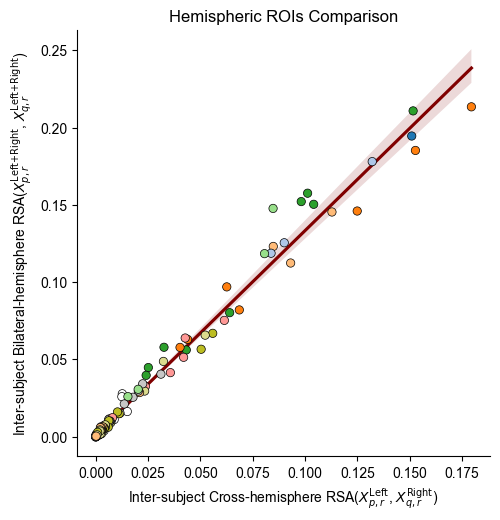

In [127]:


g = sns.lmplot(data=df_hemispheres, x="similarity_comp", y="similarity_joined", scatter=False, line_kws={"color": "maroon", "zorder": -100})
ax = g.ax
sns.scatterplot(data=df_hemispheres.query("area not in @top_areas"), x="similarity_comp", y="similarity_joined", palette=whites, hue="area", legend=False, hue_order=area_order, edgecolor="black", linewidth=0.5, ax=ax)
g = sns.scatterplot(data=df_hemispheres.query("area in @top_areas"), x="similarity_comp", y="similarity_joined", palette=palette, hue="area", legend=False, hue_order=area_order, edgecolor="black", linewidth=0.5, ax=ax)

ax.set_xlabel("Inter-subject Cross-hemisphere RSA($X_{p,r}^{\\text{Left}}$, $X_{q,r}^{\\text{Right}}$)")
ax.set_ylabel("Inter-subject Bilateral-hemisphere RSA($X_{p,r}^{\\text{Left+Right}}$, $X_{q,r}^{\\text{Left+Right}}$)")
ax.set_title("Hemispheric ROIs Comparison")
g.figure.savefig(output / "rsa_hemispheres_cross_subject_comparison.pdf", bbox_inches="tight", transparent=True)

## Modality comparison

[0.27506733 0.44149609]
Vision Models - Brain Pseudo-R²: 0.937 N Boostrap samples: 10000


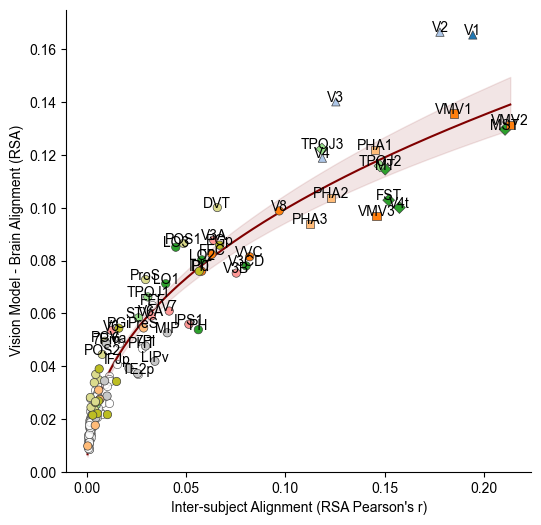

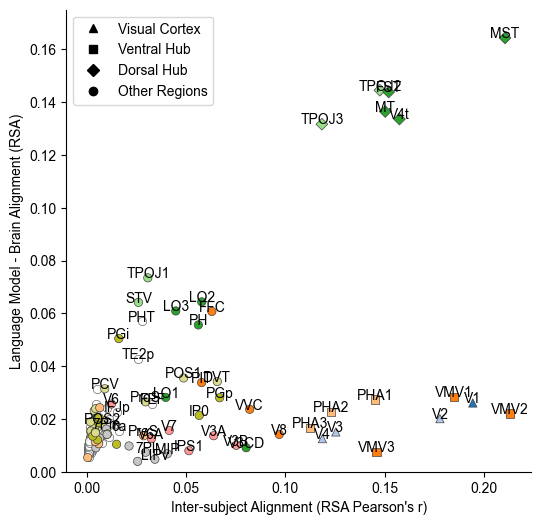

In [ ]:

n_boot = 10000

top_areas = process_intersubject_rois(load_filename("cross_subject", shift=1, joined=True), top=10).area.unique()
palette = df_comparison[["area", "area_color"]].drop_duplicates().set_index("area").to_dict()["area_color"]
data = df_comparison.query("intersubject_p_value < 0.05").copy()
data = add_cluster(data)
data["top_area"] = data["area"].apply(lambda x: x in top_areas)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6))

# Adjust vision power-law

plot_comparison(data=data, x="intersubject_rsa", y="vision_rsa", ax=ax1, palette=palette)

x_fit, y_fit, y_lower, y_upper, r2, params = fit_powerlaw_zero_with_bootstrap(data["intersubject_rsa"], data["vision_rsa"], n_boot=n_boot)
print(params)
ax1.plot(x_fit, y_fit, color='maroon', label='Power-law fit', zorder=-10)
ax1.fill_between(x_fit, y_lower, y_upper, color='maroon', alpha=0.1, label='95% CI', zorder=-20)
print(f"Vision Models - Brain Pseudo-R²: {r2:.3f} N Boostrap samples: {n_boot}")


#data_filtered = data#.query("p_value_fdr_bh_language < 0.05")
plot_comparison(data=data, x="intersubject_rsa", y="language_rsa", ax=ax2, palette=palette)
# xlim = ax2.get_xlim()
# Plot a gray area for regions where is is significant and language is not (intersubject_rsa > 0.05 and language_rsa < 0.05)
# x = [0.05 - 0.20] y = [0, 0.05]
#ax2.fill_between([0.05, 0.20], 0, 0.05, color="gray", alpha=0.2, zorder=-10)
# x_fit, y_fit, y_lower, y_upper, r2 = fit_powerlaw_with_bootstrap(data_filtered["intersubject_rsa"], data_filtered["language_rsa"], n_boot=n_boot)
# ax2.plot(x_fit, y_fit, color='maroon', label='Power-law fit', zorder=-10)
# ax2.fill_between(x_fit, y_lower, y_upper, color='maroon', alpha=0.1, label='95% CI', zorder=-20)
# print(f"Language Models - Brain Pseudo-R²: {r2:.3f} N Boostrap samples: {n_boot}")


# Add text with roi names in both scatters for those rois with model-brain alignment or intersubject-alignment  > 0.04

for i, row in data.iterrows():
    if row["vision_rsa"] > 0.04 or row["intersubject_rsa"] > 0.04 or row["language_rsa"] > 0.04:
        ax1.text(row["intersubject_rsa"], row["vision_rsa"], row["name"], ha="center", fontsize=10)
        ax2.text(row["intersubject_rsa"], row["language_rsa"], row["name"], ha="center", fontsize=10)

ax1.set_xlabel("Inter-subject Alignment (RSA Pearson's r)")
ax1.set_ylabel("Vision Model - Brain Alignment (RSA)")
ax2.set_xlabel("Inter-subject Alignment (RSA Pearson's r)")
ax2.set_ylabel("Language Model - Brain Alignment (RSA)")
triangle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',  label='Visual Cortex')
square   = mlines.Line2D([], [], color='black', marker='s', linestyle='None',  label='Ventral Hub')
diamond  = mlines.Line2D([], [], color='black', marker='D', linestyle='None',  label='Dorsal Hub')
circle  = mlines.Line2D([], [], color='black', marker='o', linestyle='None',  label='Other Regions')
legend_handles = [triangle, square, diamond, circle]
ax2.legend(handles=legend_handles, title="", loc='upper left')
ax1.set_ylim(0, 0.175)
ax2.set_ylim(0, 0.175)
#ax1.set_title("Vision Models - Brain Alignment")
#ax2.set_title("Language Models - Brain Alignment")

fig1.savefig(output / "rsa_models_vision_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)
fig2.savefig(output / "rsa_models_language_comparison.svg", bbox_inches="tight", dpi=300, transparent=True)




## Model - Brain Series

Text(0.5, 1.0, 'Language Models - Brain Alignment')

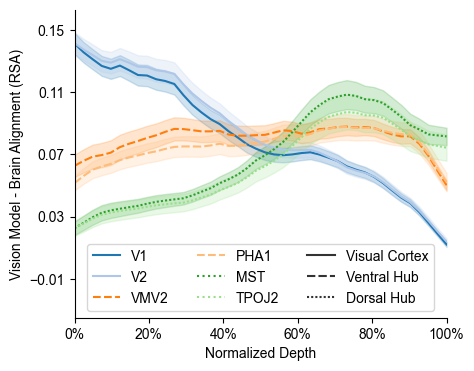

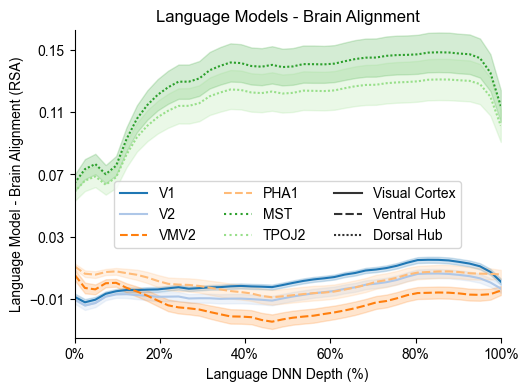

In [11]:
hcp = pd.read_csv(hcp_filename)
df_model_info = pd.read_csv(models_filename)
selected_rois = ["V1", "V2", "V3", "V4", "V8", "PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3", "FFC", "VVC", "V4t", "FST", "MST", "MT", "TPOJ3", "TPOJ2"]
roi_list= hcp[hcp.name.isin(selected_rois)].roi.unique()
df = load_filename(modality="models", joined=True)
df = df.query("roi in @roi_list and similarity < 1 and similarity > -1")
df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
df_g = df_g.rename(columns={"similarity": "score"})
df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
df_interpolated = unpack_scores(df_interpolated)
df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
df_interpolated = df_interpolated.groupby(["subject", "roi", "modality", "layer"]).score.mean().reset_index()
df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
df_interpolated_all = df_interpolated.copy()


hue_order = ["V1", "V2", "VMV2",  "PHA1", "MST", "TPOJ2",]
style_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
df_interpolated_selected = df_interpolated.query("name in @hue_order").copy()

palette = df_interpolated_selected[["name", "area_color"]].drop_duplicates().set_index("name").to_dict()["area_color"]
add_cluster(df_interpolated_selected)
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Cluster", "Hub")

fig, ax = plt.subplots(1, 1, figsize=(4*(6/5), 4))
#fig2, ax2 = plt.subplots(1, 1, figsize=(4*(6/5), 4))
fig2, ax2 = plt.subplots(1, 1, figsize=(5.5, 4))
sns.lineplot(data=df_interpolated_selected.query("modality=='vision'"),
             x="depth", y="score", hue="name", hue_order=hue_order, errorbar='se', ax=ax, style="cluster", palette=palette, style_order=style_order)


# 3 column legend and remove both titles (seaborn adds titles as "name" and "cluster" as entries)

handles, labels = ax.get_legend_handles_labels() # Remove first and 6th entry
handles = handles[1:7] + handles[8:]
labels = labels[1:7] + labels[8:]

# Make handles 2,3 dashed
handles[2].set_linestyle("--")
handles[3].set_linestyle("--")
# Make handles 4,5 dotted
handles[4].set_linestyle(":")
handles[5].set_linestyle("dotted")

ax.set_xlim(0, 1)
sns.despine(ax=ax)


sns.lineplot(data=df_interpolated_selected.query("modality=='language'"),
             x="depth", y="score", hue="name", hue_order=hue_order, errorbar='se', ax=ax2, style="cluster", palette=palette, legend=True, style_order=style_order)

sns.despine(ax=ax2)
ax2.set_ylim(-0.035, 0.163)
ax.set_ylim(-0.035, 0.163)
ax2.set_xlim(0, 1)
ax.legend(handles=handles, labels=labels, title="", ncol=3, loc='lower center')
#ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.04, offset=-0.01))
ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.04, offset=-0.01))
ax.set_ylabel("Vision Model - Brain Alignment (RSA)")
ax2.set_ylabel("Language Model - Brain Alignment (RSA)")

ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax2.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))




ax.set_xlabel("Normalized Depth")
ax2.set_xlabel("Language DNN Depth (%)")


handles, labels = ax2.get_legend_handles_labels() # Remove first and 6th entry
handles = handles[1:7] + handles[8:]
labels = labels[1:7] + labels[8:]

# Make handles 2,3 dashed
handles[2].set_linestyle("--")
handles[3].set_linestyle("--")
# Make handles 4,5 dotted
handles[4].set_linestyle(":")
handles[5].set_linestyle("dotted")
ax2.legend(handles=handles, labels=labels, title="", ncol=3, loc='center', bbox_to_anchor=(0.5, 0.4))
ax2.set_title("Language Models - Brain Alignment")

#fig.savefig(output / "rsa_models_vision_depth.pdf", bbox_inches="tight", dpi=300, transparent=True)
#fig2.savefig(output / "rsa_models_language_depth.pdf", bbox_inches="tight", dpi=300, transparent=True)



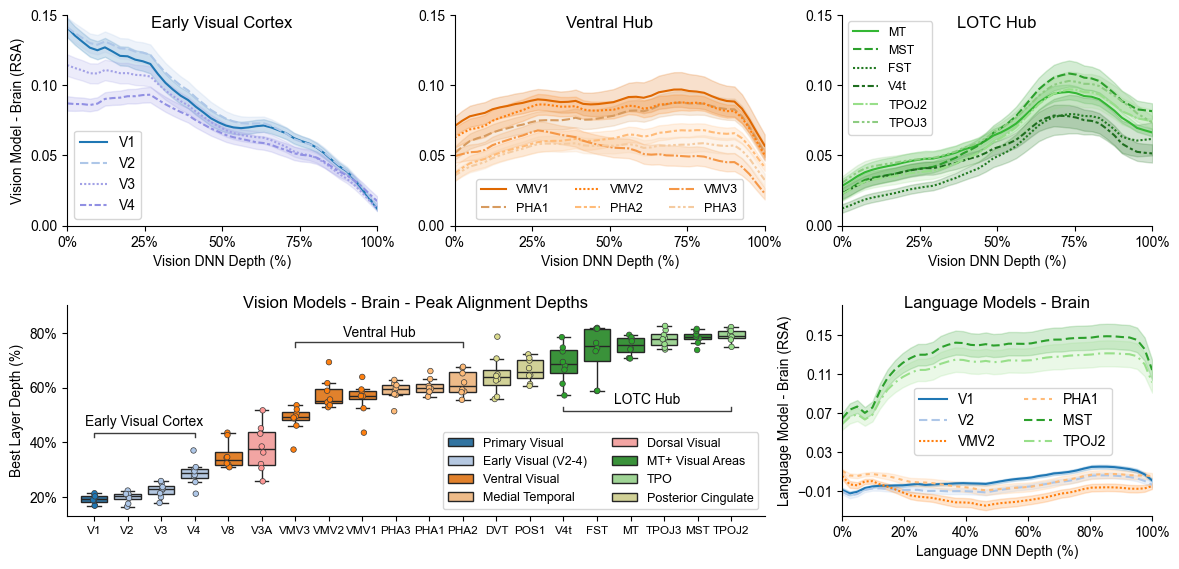

In [23]:
layout = [
    ['A', 'B', 'C'],
    ['D', 'D', 'E'],
]

# Create the figure and axes all at once from the mosaic increase heigh spacing margin
fig, axes_dict = plt.subplot_mosaic(layout, figsize=(14, 6.5), gridspec_kw={"hspace": 0.38, "wspace": 0.25})

ax1 = axes_dict['A']
ax2 = axes_dict['B']
ax3 = axes_dict['C']

palette_evc = {
    "V1": "#1f77b4",
    "V2": "#aec7e8",
    "V3": "#a2a1e6",
    "V4": "#9190e3",
}
palette_ventral = {
    "VMV1": "#df6801",
    "VMV2": "#ff7f0e",
    "VMV3": "#f59746",
    "PHA1": "#d79b5f",
    "PHA2": "#ffbb78",
    "PHA3": "#f5cba0",
}

palette_lotc = {
    "MT": "#34B734",
    "MST": "#2ca02c",
    "FST": "#217921",
    "V4t": "#1F6E1F",
    "TPOJ2": "#98df8a",
    "TPOJ3": "#8dcc81",
}


sns.lineplot(data=df_interpolated_all.query("modality=='vision' and name in ['V1', 'V2', 'V3', 'V4']"),
             x="depth", y="score", hue="name", hue_order=["V1", "V2", "V3", "V4"], errorbar='se', ax=ax1, palette=palette_evc, style="name", style_order=["V1", "V2", "V3", "V4"])


sns.lineplot(data=df_interpolated_all.query("modality=='vision' and name in ['VMV1', 'VMV2', 'VMV3', 'PHA1', 'PHA2', 'PHA3']"),
             x="depth", y="score", hue="name", hue_order=["VMV1",  "PHA1", "VMV2",  "PHA2", "VMV3", "PHA3"], errorbar='se', ax=ax2, palette=palette_ventral, style="name", style_order=["VMV1",  "PHA1", "VMV2",  "PHA2", "VMV3", "PHA3"])


sns.lineplot(data=df_interpolated_all.query("modality=='vision' and name in ['MT', 'MST', 'FST', 'V4t', 'TPOJ2', 'TPOJ3']"),
             x="depth", y="score", hue="name", hue_order=["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"], errorbar='se', ax=ax3, style="name", palette=palette_lotc, style_order=["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"])

for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.15)
    sns.despine(ax=ax)
    if i == 0:
        ax.set_ylabel("Vision Model - Brain (RSA)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Vision DNN Depth (%)")
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    # Reduce title
    # For the 0 put as 0.0
    #ax.set_yticks([0, 0.05, 0.1, 0.15])
    #ax.set_yticklabels([".00", ".05", ".10", ".15"])
    
    # Remove legend title
    n_col = 1 if i != 1 else 2
    ax.legend(title="", ncol=n_col)
# Reduce the space between the titles and the axes
ax1.set_title("Early Visual Cortex", y=0.9)
ax2.set_title("Ventral Hub", y=0.9)
ax3.set_title("LOTC Hub", y=0.9)
# Set ax2 legend to bottom center
ax2.legend(title="", ncol=3, loc='lower center', fontsize=9)
ax1.legend(title="", ncol=1, loc='lower left')
ax3.legend(title="", ncol=1, loc='best', fontsize=9)

ax = axes_dict['D']

#df_comparison_subjects = proccess_alignment(group_subject=False)
#df_comparison = proccess_alignment(group_subject=True)
top_n = 20
top_rois = df_comparison.sort_values("intersubject_rsa", ascending=False).head(top_n).name.tolist()
top_rois = df_comparison.sort_values("vision_rsa", ascending=False).head(top_n).name.tolist()
#x_order = df_comparison.query("name in @top_rois").sort_values("intersubject_rsa", ascending=False).sort_values("vision_depth").name.tolist()

# Sort by quantile 25
x_order = df_comparison_subjects.query("name in @top_rois").groupby("name").vision_depth.quantile().sort_values().index.tolist()

palette = df_comparison[["area", "area_color"]].drop_duplicates().set_index("area").to_dict()["area_color"]
hue_order = df_comparison.query("name in @top_rois").sort_values("area_id").drop_duplicates("area_id").area.tolist()

#fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
#fig, ax = plt.subplots(1, 1, figsize=(9.5, 3.2), dpi=300)
sns.boxplot(data=df_comparison_subjects.query("name in @top_rois"), 
            x="name", y="vision_depth", 
        ax=ax, order=x_order, hue="area", palette=palette, hue_order=hue_order, showfliers=False)

# Add points with jitter
sns.stripplot(data=df_comparison_subjects.query("name in @top_rois"),
             x="name", y="vision_depth",
             ax=ax, order=x_order, hue="area", palette=palette, hue_order=hue_order,
             dodge=False, jitter=0.05, s=4, linewidth=0.5, edgecolor=(0.24, 0.24, 0.24), alpha=1, marker='o', zorder=100, legend=False)

ax.set_xticks(np.arange(len(x_order)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8.5)
sns.despine(ax=ax)
# Remove legend title
ax.legend(title="", ncol=2, loc='lower right', fontsize=9)#, bbox_to_anchor=(0.95, 0.0))
ax.set_xlabel("")
ax.set_ylabel("Best Layer Depth (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

ax.set_ylim(None, 0.9)
ax.set_xlim(-0.8, len(x_order))
add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.42, height=0.015, text="Early Visual Cortex", y_text=0.46)
add_pvalue_bracket(ax=ax, x1=6, x2=11, y=0.75, height=0.015, text="Ventral Hub", y_text=0.785)
add_pvalue_bracket(ax=ax, x1=14, x2=19, y=0.53, height=-0.015, text="LOTC Hub", y_text=0.54)

#fig.savefig(output / "vision_depth_boxplot_poster.pdf", bbox_inches="tight", dpi=300, transparent=True)



#fig.savefig(output / "rsa_models_vision_depth_hubs_curves.pdf", bbox_inches="tight", dpi=300, transparent=True)


hcp = pd.read_csv(hcp_filename)
df_model_info = pd.read_csv(models_filename)
selected_rois = ["V1", "V2", "V3", "V4", "V8", "PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3", "FFC", "VVC", "V4t", "FST", "MST", "MT", "TPOJ3", "TPOJ2"]
roi_list= hcp[hcp.name.isin(selected_rois)].roi.unique()
# df = load_filename(modality="models", joined=True)
#df = df.query("roi in @roi_list and similarity < 1 and similarity > -1")
# df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
# df_g = df_g.rename(columns={"similarity": "score"})
# df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
# df_interpolated = unpack_scores(df_interpolated)
# df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
# df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
# df_interpolated = df_interpolated.groupby(["subject", "roi", "modality", "layer"]).score.mean().reset_index()
# df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
# df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
# df_interpolated_all = df_interpolated.copy()


hue_order = ["V1", "V2", "VMV2",  "PHA1", "MST", "TPOJ2",]
style_order = ["Visual Cortex", "Ventral Hub", "LOTC Hub"]
df_interpolated_selected = df_interpolated.query("name in @hue_order").copy()
palette = df_interpolated_selected[["name", "area_color"]].drop_duplicates().set_index("name").to_dict()["area_color"]
add_cluster(df_interpolated_selected)
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Cluster", "Hub")
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Dorsal", "LOTC")

ax2 = axes_dict['E']

sns.lineplot(data=df_interpolated_selected.query("modality=='language'"),
             x="depth", y="score", hue="name", hue_order=hue_order, 
             errorbar='se', ax=ax2, style="name", palette=palette, legend=True,
             dashes={
                 # Solid line
                 "V1": (None, None), 
                 # Dashed line (--)
                 "V2": (4, 2), 
                 # Dotted line (:)
                 "VMV2": (1, 1), 
                 # Dashed line (--)
                 "PHA1": (2, 2),
                 # Dashed line with longer strokes (--)
                 "MST": (4, 2), 
                 # Dash-dot line (-.-)
                 "TPOJ2": (5, 2, 1, 2)
             }
             )
            

sns.despine(ax=ax2)
ax2.set_ylim(-0.035, 0.18)
ax2.set_xlim(0, 1)
ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.04, offset=-0.01))
ax2.set_ylabel("Language Model - Brain (RSA)")
ax2.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax2.set_xlabel("Language DNN Depth (%)")


handles, labels = ax2.get_legend_handles_labels() # Remove first and 6th entry
#handles = handles[1:7] #+ handles[8:]
#labels = labels[1:7] #+ labels[8:]

# Make handles 2,3 dashed
#handles[2].set_linestyle("--")
#handles[3].set_linestyle("--")
# Make handles 4,5 dotted
#handles[4].set_linestyle(":")
#handles[5].set_linestyle("dotted")
ax2.legend(handles=handles, labels=labels, title="", ncol=2, loc='center', bbox_to_anchor=(0.55, 0.45))
ax2.set_title("Language Models - Brain", y=0.95)
ax.set_title("Vision Models - Brain - Peak Alignment Depths", y=0.95)

# Save the figure
fig.savefig(output / "rsa_models_vision_language_depth_hubs_curves.pdf", bbox_inches="tight", dpi=300, transparent=True)

['Visual Cortex', 'Ventral Hub', 'LOTC Hub']


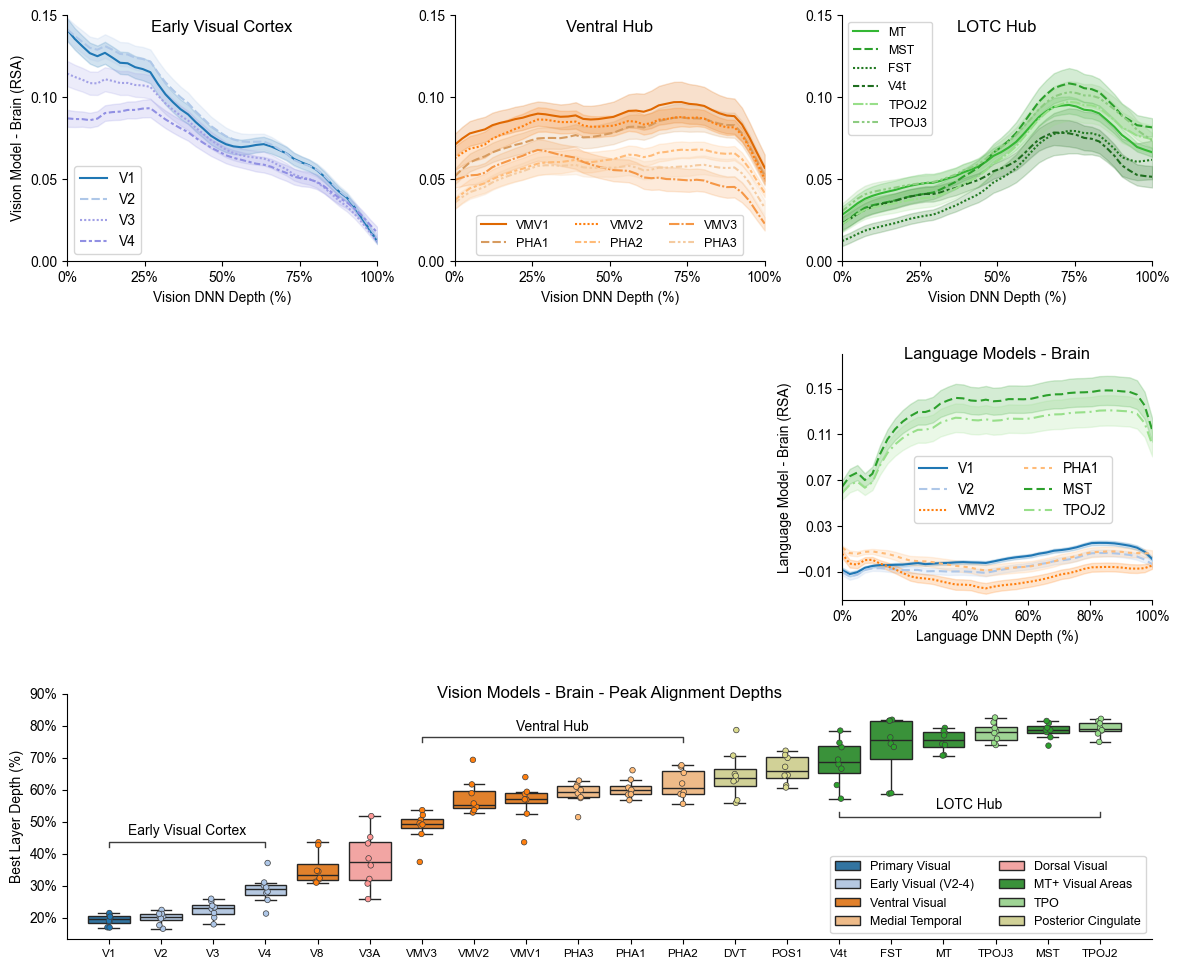

In [25]:
layout = [
    ['A', 'B', 'C'],
    ['F', 'F', 'E'],
    ['D', 'D', 'D'],
]

# Create the figure and axes all at once from the mosaic increase heigh spacing margin
fig, axes_dict = plt.subplot_mosaic(layout, figsize=(14, 12), gridspec_kw={"hspace": 0.38, "wspace": 0.25})

ax1 = axes_dict['A']
ax2 = axes_dict['B']
ax3 = axes_dict['C']
ax_f = axes_dict['F']
ax_f.axis('off')

palette_evc = {
    "V1": "#1f77b4",
    "V2": "#aec7e8",
    "V3": "#a2a1e6",
    "V4": "#9190e3",
}
palette_ventral = {
    "VMV1": "#df6801",
    "VMV2": "#ff7f0e",
    "VMV3": "#f59746",
    "PHA1": "#d79b5f",
    "PHA2": "#ffbb78",
    "PHA3": "#f5cba0",
}

palette_lotc = {
    "MT": "#34B734",
    "MST": "#2ca02c",
    "FST": "#217921",
    "V4t": "#1F6E1F",
    "TPOJ2": "#98df8a",
    "TPOJ3": "#8dcc81",
}


sns.lineplot(data=df_interpolated_all.query("modality=='vision' and name in ['V1', 'V2', 'V3', 'V4']"),
             x="depth", y="score", hue="name", hue_order=["V1", "V2", "V3", "V4"], errorbar='se', ax=ax1, palette=palette_evc, style="name", style_order=["V1", "V2", "V3", "V4"])


sns.lineplot(data=df_interpolated_all.query("modality=='vision' and name in ['VMV1', 'VMV2', 'VMV3', 'PHA1', 'PHA2', 'PHA3']"),
             x="depth", y="score", hue="name", hue_order=["VMV1",  "PHA1", "VMV2",  "PHA2", "VMV3", "PHA3"], errorbar='se', ax=ax2, palette=palette_ventral, style="name", style_order=["VMV1",  "PHA1", "VMV2",  "PHA2", "VMV3", "PHA3"])


sns.lineplot(data=df_interpolated_all.query("modality=='vision' and name in ['MT', 'MST', 'FST', 'V4t', 'TPOJ2', 'TPOJ3']"),
             x="depth", y="score", hue="name", hue_order=["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"], errorbar='se', ax=ax3, style="name", palette=palette_lotc, style_order=["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"])

for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.15)
    sns.despine(ax=ax)
    if i == 0:
        ax.set_ylabel("Vision Model - Brain (RSA)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Vision DNN Depth (%)")
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    # Reduce title
    # For the 0 put as 0.0
    #ax.set_yticks([0, 0.05, 0.1, 0.15])
    #ax.set_yticklabels([".00", ".05", ".10", ".15"])
    
    # Remove legend title
    n_col = 1 if i != 1 else 2
    ax.legend(title="", ncol=n_col)
# Reduce the space between the titles and the axes
ax1.set_title("Early Visual Cortex", y=0.9)
ax2.set_title("Ventral Hub", y=0.9)
ax3.set_title("LOTC Hub", y=0.9)
# Set ax2 legend to bottom center
ax2.legend(title="", ncol=3, loc='lower center', fontsize=9)
ax1.legend(title="", ncol=1, loc='lower left')
ax3.legend(title="", ncol=1, loc='best', fontsize=9)

ax = axes_dict['D']

#df_comparison_subjects = proccess_alignment(group_subject=False)
#df_comparison = proccess_alignment(group_subject=True)
top_n = 20
top_rois = df_comparison.sort_values("intersubject_rsa", ascending=False).head(top_n).name.tolist()
top_rois = df_comparison.sort_values("vision_rsa", ascending=False).head(top_n).name.tolist()
#x_order = df_comparison.query("name in @top_rois").sort_values("intersubject_rsa", ascending=False).sort_values("vision_depth").name.tolist()

# Sort by quantile 25
x_order = df_comparison_subjects.query("name in @top_rois").groupby("name").vision_depth.quantile().sort_values().index.tolist()

palette = df_comparison[["area", "area_color"]].drop_duplicates().set_index("area").to_dict()["area_color"]
hue_order = df_comparison.query("name in @top_rois").sort_values("area_id").drop_duplicates("area_id").area.tolist()

#fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
#fig, ax = plt.subplots(1, 1, figsize=(9.5, 3.2), dpi=300)
sns.boxplot(data=df_comparison_subjects.query("name in @top_rois"), 
            x="name", y="vision_depth", 
        ax=ax, order=x_order, hue="area", palette=palette, hue_order=hue_order, showfliers=False)
# Add points with jitter
sns.stripplot(data=df_comparison_subjects.query("name in @top_rois"),
             x="name", y="vision_depth",
             ax=ax, order=x_order, hue="area", palette=palette, hue_order=hue_order,
             dodge=False, jitter=0.05, s=4, linewidth=0.5, edgecolor=(0.24, 0.24, 0.24), alpha=1, marker='o', zorder=100, legend=False)

ax.set_xticks(np.arange(len(x_order)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8.5)
sns.despine(ax=ax)
# Remove legend title
ax.legend(title="", ncol=2, loc='lower right', fontsize=9)#, bbox_to_anchor=(0.95, 0.0))
ax.set_xlabel("")
ax.set_ylabel("Best Layer Depth (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

ax.set_ylim(None, 0.9)
ax.set_xlim(-0.8, len(x_order))
add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.42, height=0.015, text="Early Visual Cortex", y_text=0.46)
add_pvalue_bracket(ax=ax, x1=6, x2=11, y=0.75, height=0.015, text="Ventral Hub", y_text=0.785)
add_pvalue_bracket(ax=ax, x1=14, x2=19, y=0.53, height=-0.015, text="LOTC Hub", y_text=0.54)

#fig.savefig(output / "vision_depth_boxplot_poster.pdf", bbox_inches="tight", dpi=300, transparent=True)



#fig.savefig(output / "rsa_models_vision_depth_hubs_curves.pdf", bbox_inches="tight", dpi=300, transparent=True)


hcp = pd.read_csv(hcp_filename)
df_model_info = pd.read_csv(models_filename)
selected_rois = ["V1", "V2", "V3", "V4", "V8", "PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3", "FFC", "VVC", "V4t", "FST", "MST", "MT", "TPOJ3", "TPOJ2"]
roi_list= hcp[hcp.name.isin(selected_rois)].roi.unique()
# df = load_filename(modality="models", joined=True)
#df = df.query("roi in @roi_list and similarity < 1 and similarity > -1")
# df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
# df_g = df_g.rename(columns={"similarity": "score"})
# df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
# df_interpolated = unpack_scores(df_interpolated)
# df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
# df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
# df_interpolated = df_interpolated.groupby(["subject", "roi", "modality", "layer"]).score.mean().reset_index()
# df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
# df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
# df_interpolated_all = df_interpolated.copy()


hue_order = ["V1", "V2", "VMV2",  "PHA1", "MST", "TPOJ2",]
style_order = ["Visual Cortex", "Ventral Hub", "LOTC Hub"]
df_interpolated_selected = df_interpolated.query("name in @hue_order").copy()
palette = df_interpolated_selected[["name", "area_color"]].drop_duplicates().set_index("name").to_dict()["area_color"]
add_cluster(df_interpolated_selected)
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Cluster", "Hub")
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Dorsal", "LOTC")

ax2 = axes_dict['E']

print(style_order)
sns.lineplot(data=df_interpolated_selected.query("modality=='language'"),
             x="depth", y="score", hue="name", hue_order=hue_order, 
             errorbar='se', ax=ax2, style="name", palette=palette, legend=True,
             dashes={
                 # Solid line
                 "V1": (None, None), 
                 # Dashed line (--)
                 "V2": (4, 2), 
                 # Dotted line (:)
                 "VMV2": (1, 1), 
                 # Dashed line (--)
                 "PHA1": (2, 2),
                 # Dashed line with longer strokes (--)
                 "MST": (4, 2), 
                 # Dash-dot line (-.-)
                 "TPOJ2": (5, 2, 1, 2)
             }
             )
            

sns.despine(ax=ax2)
ax2.set_ylim(-0.035, 0.18)
ax2.set_xlim(0, 1)
ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.04, offset=-0.01))
ax2.set_ylabel("Language Model - Brain (RSA)")
ax2.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax2.set_xlabel("Language DNN Depth (%)")

handles, labels = ax2.get_legend_handles_labels() # Remove first and 6th entry
#handles = handles[1:7] #+ handles[8:]
#labels = labels[1:7] #+ labels[8:]

# Make handles 2,3 dashed
#handles[2].set_linestyle("--")
#handles[3].set_linestyle("--")
# Make handles 4,5 dotted
#handles[4].set_linestyle(":")
#handles[5].set_linestyle("dotted")
ax2.legend(handles=handles, labels=labels, title="", ncol=2, loc='center', bbox_to_anchor=(0.55, 0.45))
ax2.set_title("Language Models - Brain", y=0.95)
ax.set_title("Vision Models - Brain - Peak Alignment Depths", y=0.95)

# Save the figure
fig.savefig(output / "rsa_models_vision_language_depth_hubs_curves2.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [238]:
# df_comparison_surface = proccess_alignment(group_subject=True, joined=False)
df_comparison_surface_hcp = df_comparison_surface.merge(
    hcp[["roi", "name", "area", "area_color"]], on="roi"
)

display(df_comparison_surface_hcp.vision_depth.describe())

significant_is_rois = df_comparison_surface_hcp.query("intersubject_p_value < 0.05").name_y.unique()
cmap = "PiYG_r"

# brain = plot_faverage_parcelation(
#         df_comparison_surface_hcp.query("name_y in @significant_is_rois"),
#         value_column="vision_depth",
#         normalize=(0.2, 0.8),
#         cmap=cmap,
#         default_color="lightgray",
#         default_value=None,
#     )
# brain.show()

for hemisphere in ["lh", "rh"]:
    brain = plot_faverage_parcelation(
        df_comparison_surface_hcp.query("name_y in @significant_is_rois"),
        value_column="vision_depth",
        normalize=(0.2, 0.8),
        cmap=cmap,
        default_color="lightgray",
        default_value=None,
        hemisphere=hemisphere,
        size=(2*800, 2*600),
    )
    for view in ["lateral", "medial", "ventral", "caudal"]:
        brain.show_view(view)
        brain.save_image(output / f"vision_depth_{hemisphere}_{view}_02_80.png", mode="rgba")
    brain.close()

count    360.000000
mean       0.519593
std        0.079183
min        0.193269
25%        0.482817
50%        0.506179
75%        0.546596
max        0.792950
Name: vision_depth, dtype: float64

(-0.8, 20.0)

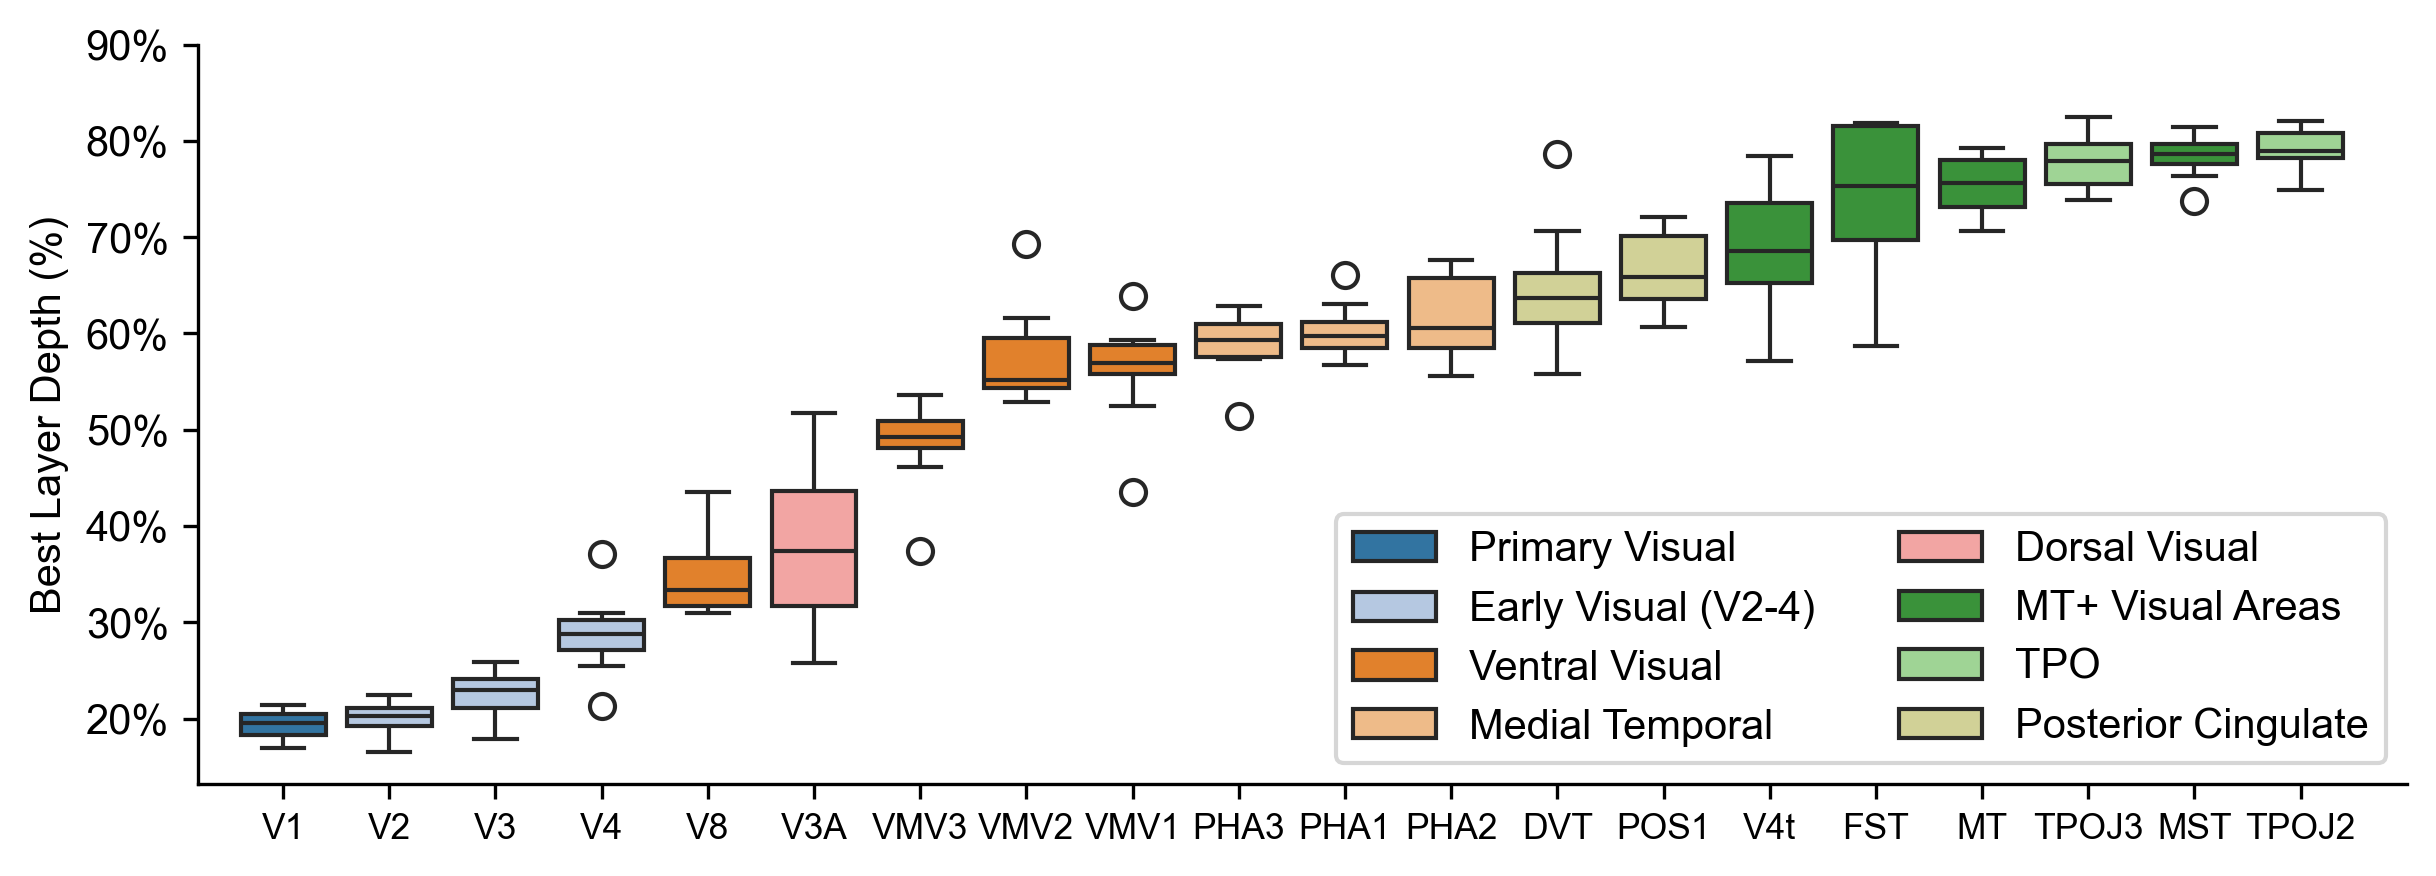

In [589]:
#df_comparison_subjects = proccess_alignment(group_subject=False)
#df_comparison = proccess_alignment(group_subject=True)
top_n = 20
top_rois = df_comparison.sort_values("intersubject_rsa", ascending=False).head(top_n).name.tolist()
top_rois = df_comparison.sort_values("vision_rsa", ascending=False).head(top_n).name.tolist()
#top_rois = order3
#x_order = df_comparison.query("name in @top_rois").sort_values("intersubject_rsa", ascending=False).sort_values("vision_depth").name.tolist()

# Sort by quantile 25
x_order = df_comparison_subjects.query("name in @top_rois").groupby("name").vision_depth.quantile().sort_values().index.tolist()

palette = df_comparison[["area", "area_color"]].drop_duplicates().set_index("area").to_dict()["area_color"]
hue_order = df_comparison.query("name in @top_rois").sort_values("area_id").drop_duplicates("area_id").area.tolist()
#hue_order = df_comparison_subjects.query("name in @order3").groupby("name").aggregate({"vision_depth": lambda x: x.quantile(0.25)}).reset_index().sort_values("vision_depth").name.tolist()
#fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
fig, ax = plt.subplots(1, 1, figsize=(9.5, 3.2), dpi=300)
sns.boxplot(data=df_comparison_subjects.query("name in @top_rois"), 
            x="name", y="vision_depth", 
        ax=ax, order=x_order, hue="area", palette=palette, hue_order=hue_order)

ax.set_xticks(np.arange(len(x_order)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8.5)
sns.despine(ax=ax)
# Remove legend title
ax.legend(title="", ncol=2, loc='lower right')
ax.set_xlabel("")
ax.set_ylabel("Best Layer Depth (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

ax.set_ylim(None, 0.9)
ax.set_xlim(-0.8, len(x_order))
#add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.42, height=0.015, text="Early Visual Cortex", y_text=0.46)
#add_pvalue_bracket(ax=ax, x1=6, x2=11, y=0.75, height=0.015, text="Ventral Hub", y_text=0.785)
#add_pvalue_bracket(ax=ax, x1=14, x2=19, y=0.53, height=-0.015, text="LOTC Hub", y_text=0.465)

#fig.savefig(output / "vision_depth_boxplot_poster.pdf", bbox_inches="tight", dpi=300, transparent=True)
# Aggregate by quantile 25



In [27]:
#df_comparison_asymmetry = proccess_alignment(joined=False, group_subject=True)
rois_significant = df_comparison_asymmetry.query("intersubject_p_value <0.001").name.tolist()

normalize = 0.2, 0.8
df_comparison_asymmetry_plot = df_comparison_asymmetry.query("name in @rois_significant").copy()

views = ["lateral", "medial", "ventral", "caudal"]
hemispheres = ["lh", "rh"]

for hemisphere in hemispheres:
    brain = plot_faverage_parcelation(df_comparison_asymmetry_plot[["name", "mne_name", "vision_depth"]],
                                  value_column="vision_depth", 
                                  cmap="PRGn_r", 
                                  default_value=None, default_color="lightgray",
                                    normalize=normalize, size=(1600, 1200), hemisphere=hemisphere)
    for view in views:
        brain.show_view(view)
        brain.save_image(output / f"depth_cortical_{hemisphere}_{view}.png", mode="rgba")
    brain.close()

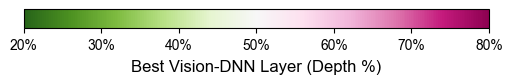

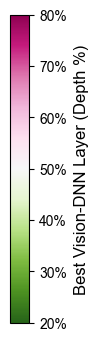

In [595]:
# Make an horizontal colorbar RdBu_r from 0.2 to 0.8
fig_cbar, ax_cbar = plot_cbar(cmap="PiYG_r", title="Best Vision-DNN Layer (Depth %)", vmin=0.2, vmax=0.8, locator=0.1, horizontal=True, percent=True, rotation=0, labelpad=5, figsize = (6, 0.25))
fig_cbar.savefig(output / f"colorbar_depth_cortical_0.2_0.8.pdf", bbox_inches="tight", dpi=300, transparent=True)

fig_cbar, ax_cbar = plot_cbar(cmap="PiYG_r", title="Best Vision-DNN Layer (Depth %)", vmin=0.2, vmax=0.8, locator=0.1, horizontal=False, percent=True, rotation=90, labelpad=5, figsize = (0.25, 4))
fig_cbar.savefig(output / f"colorbar_depth_cortical_0.2_0.8_vertical.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [56]:
significant_rois = df_comparison[df_comparison.intersubject_p_value < 0.05].name.tolist()

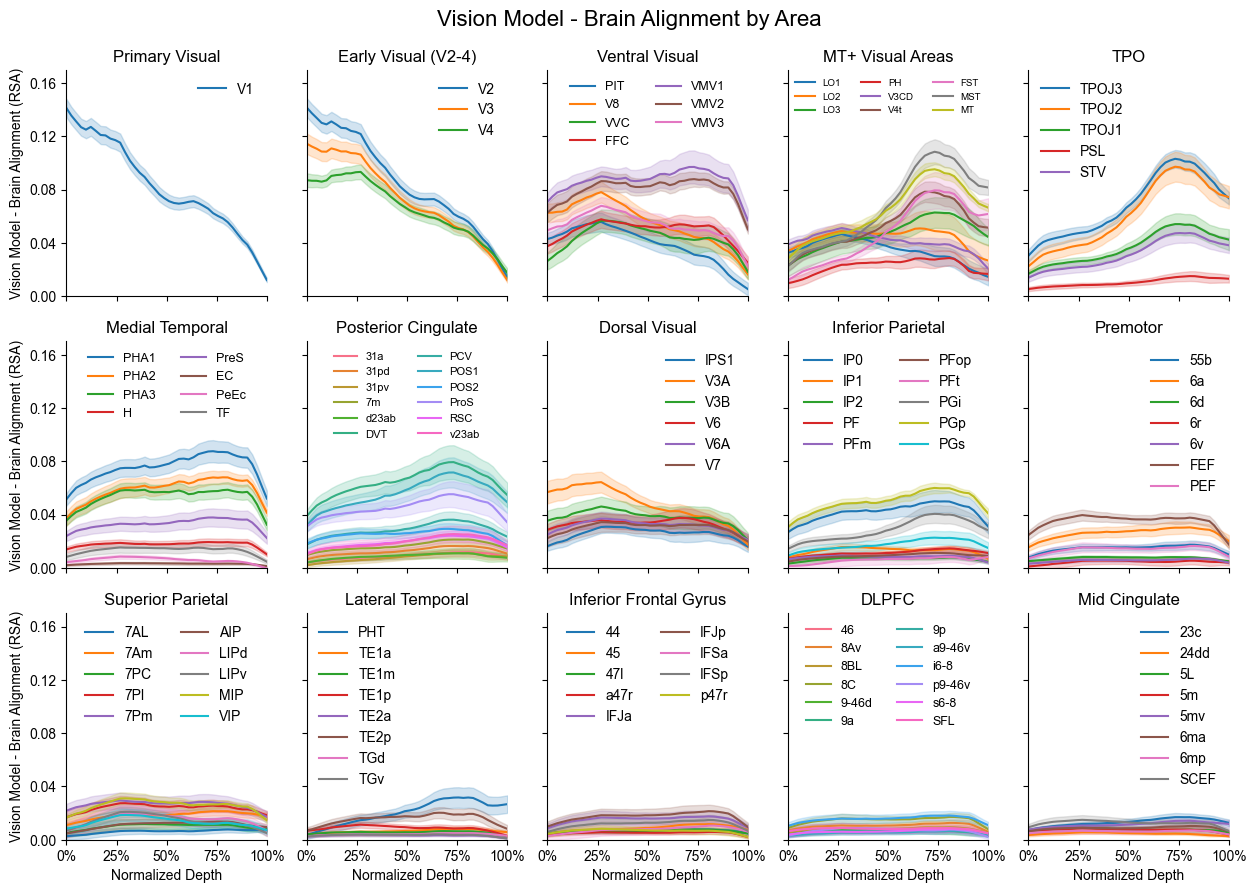

In [83]:
#df_comparison = proccess_alignment(group_subject=True)
hcp = pd.read_csv(hcp_filename).sort_values(["area_id", "roi_order"])


df_comparison_areas = df_comparison.groupby(["area"]).aggregate({"intersubject_rsa": "mean", "vision_rsa": "max", "language_rsa": "mean"}).reset_index()
area_order = df_comparison_areas.sort_values("vision_rsa", ascending=False).area.tolist()
# Shape 0 and 1 position
area_order[0], area_order[1] = area_order[1], area_order[0]


modality = "vision"
# 22 subplots -> 4 columns, 6 rows
# Add a little the height margin between subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)
axes_flatten = axes.flatten()
for i, area in enumerate(area_order[:15]):
    df_subplot = df_interpolated.query("modality==@modality and area==@area and name in @significant_rois")

    # Hue order
    hue_order = hcp.query("area==@area and name in @significant_rois and roi<=180").sort_values("roi_order").name.tolist()

    ax = axes_flatten[i]
    sns.lineplot(data=df_subplot, x="depth", y="score", hue="name", ax=ax, errorbar='se', legend=True, hue_order=hue_order)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.17)
    sns.despine(ax=ax)
    ax.set_title(area)
    # Remove title of the legend
    ax.legend(title="", loc='best', frameon=False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # Set yticks 0.04
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.04))
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Modify legends
positions = [(2,2,9), (3,3,7), (5,2,9), (6,2,8), (8,2, 10), (10,2,10), (12,2,10), (13,2,9)]
for pos, ncol, fontsize in positions:
    axes_flatten[pos].legend(title="", ncol=ncol, loc='upper center', fontsize=fontsize, frameon=False)
for pos in [0, 5, 10]:
    axes_flatten[pos].set_ylabel("Vision Model - Brain Alignment (RSA)")
for pos in [10, 11, 12, 13, 14]:
    axes_flatten[pos].set_xlabel("Normalized Depth")

fig.suptitle("Vision Model - Brain Alignment by Area", fontsize=16, y=0.94)
fig.savefig(output / "vision_depth_curves_area.pdf", bbox_inches="tight", dpi=300, transparent=True)

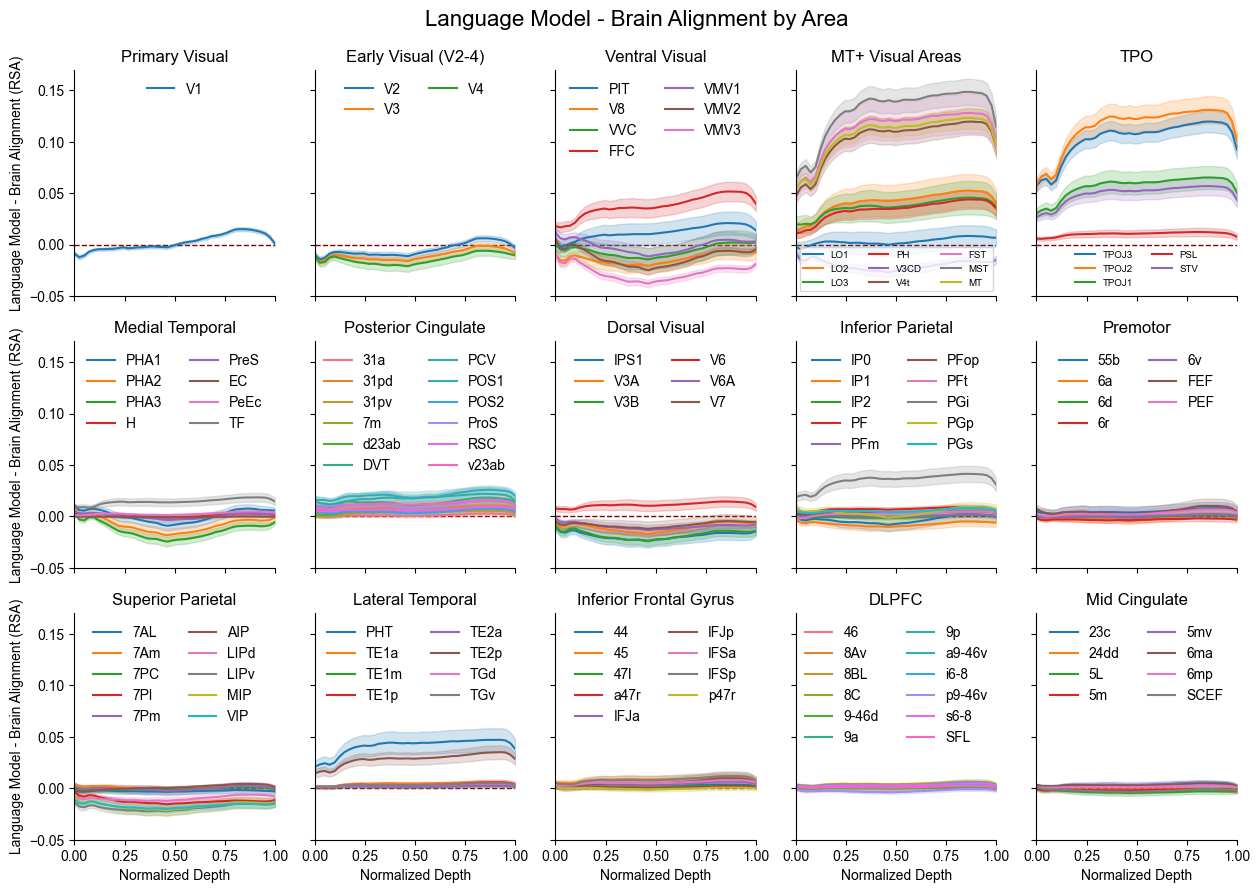

In [107]:
#df_comparison = proccess_alignment(group_subject=True)
hcp = pd.read_csv(hcp_filename).sort_values(["area_id", "roi_order"])


df_comparison_areas = df_comparison.groupby(["area"]).aggregate({"intersubject_rsa": "mean", "vision_rsa": "max", "language_rsa": "mean"}).reset_index()
area_order = df_comparison_areas.sort_values("vision_rsa", ascending=False).area.tolist()
# Shape 0 and 1 position
area_order[0], area_order[1] = area_order[1], area_order[0]

modality = "language"
fig, axes = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)
#fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_flatten = axes.flatten()
for i, area in enumerate(area_order[:15]):
    df_subplot = df_interpolated.query("modality==@modality and area==@area and name in @significant_rois")
    hue_order = hcp.query("area==@area and name in @significant_rois and roi<=180").sort_values("roi_order").name.tolist()
    ax = axes_flatten[i]
    sns.lineplot(data=df_subplot, x="depth", y="score", hue="name", ax=ax, errorbar='se', legend=True, hue_order=hue_order)
    ax.set_xlim(0, 1)
    sns.despine(ax=ax)
    ax.set_title(area)
    ax.hlines(0, 0, 1, color="maroon", linestyle="--", linewidth=1, zorder=-10)
    ax.set_ylim(-0.05, 0.17)
    ax.legend(title="", loc='upper center', frameon=False, ncol=2)

axes_flatten[4].legend(title="", loc='lower center', frameon=False, ncol=2, fontsize=7)
axes_flatten[3].legend(title="", loc='lower center', frameon=True, ncol=3, fontsize=7)

for pos in [0, 5, 10]:
    axes_flatten[pos].set_ylabel("Language Model - Brain Alignment (RSA)")
for pos in [10, 11, 12, 13, 14]:
    axes_flatten[pos].set_xlabel("Normalized Depth")

fig.suptitle("Language Model - Brain Alignment by Area", fontsize=16, y=0.94)
fig.savefig(output / "language_depth_curves_area.pdf", bbox_inches="tight", dpi=300, transparent=True)

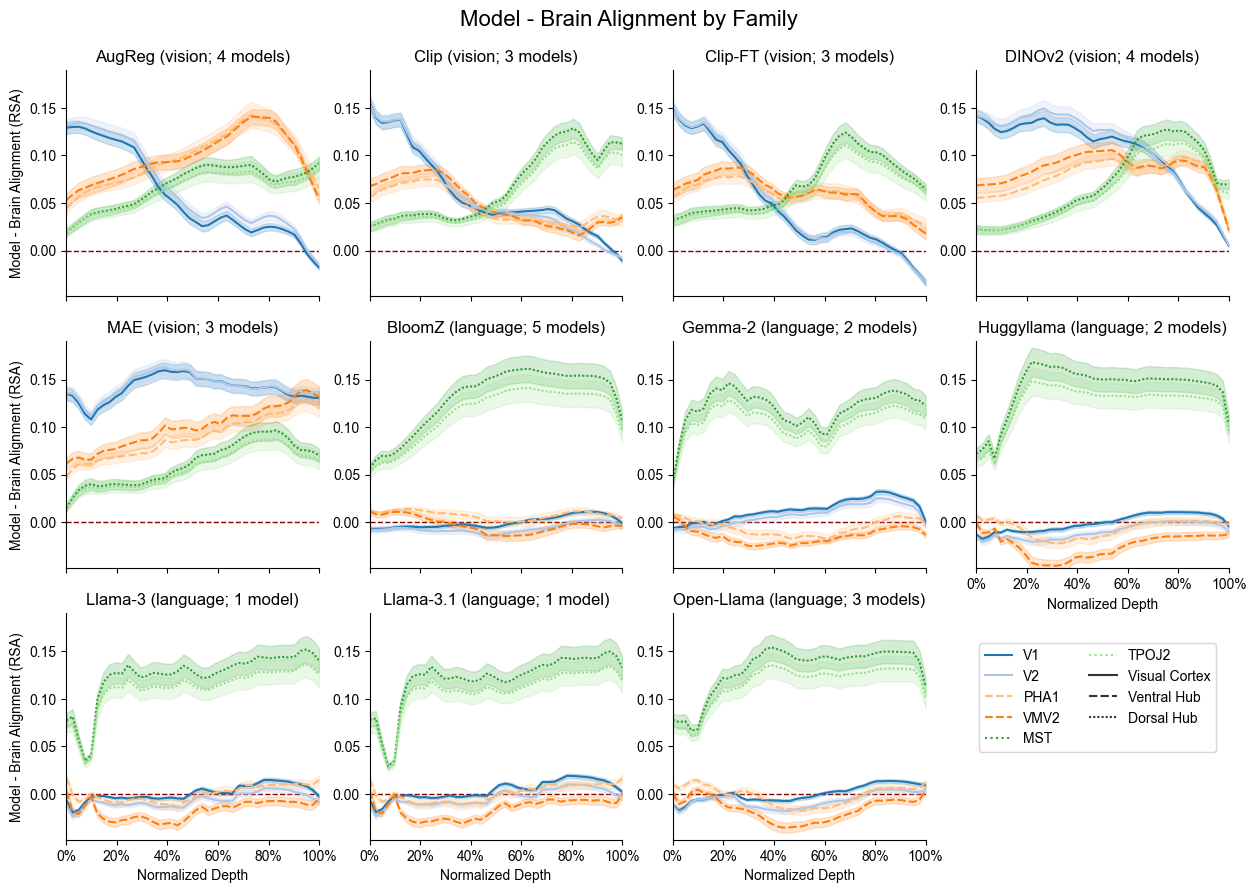

In [189]:
# hcp = pd.read_csv(hcp_filename)
# df_model_info = pd.read_csv(models_filename)
# selected_rois = ["V1", "V2", "PHA1", "VMV2", "MST", "TPOJ2"]
# roi_list= hcp[hcp.name.isin(selected_rois)].roi.unique()
# df = load_filename(modality="models", joined=True)
# df = df.query("roi in @roi_list and similarity < 1 and similarity > -1")
# df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
# df_g = df_g.rename(columns={"similarity": "score"})
# df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
# df_interpolated = unpack_scores(df_interpolated)
# df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
# df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
# df_interpolated = df_interpolated.groupby(["subject", "roi", "modality", "family", "layer"]).score.mean().reset_index()
# df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
# df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
# add_cluster(df_interpolated)
# df_interpolated.cluster = df_interpolated.cluster.str.replace("Cluster", "Hub")

style_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]

fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharex=False, sharey=False)
axes_flatten = axes.flatten()
family_order = df_interpolated[['modality', 'family']].drop_duplicates().sort_values(['modality', 'family'], ascending=[False, True]).family.tolist()

palette = hcp.query("name in @selected_rois")[["name", "area_color"]].drop_duplicates().set_index("name").to_dict()["area_color"]
n_models = df_model_info.groupby("family").model_name.count().to_dict()
for i, family in enumerate(family_order):
    df_interpolated_family = df_interpolated.query("family==@family")
    modality = df_interpolated_family.modality.iloc[0]
    hue_order = selected_rois
    n_models_family = n_models[family]
    
    ax = axes_flatten[i]
    sns.lineplot(data=df_interpolated_family,
                 x="depth", y="score", hue="name", 
                 ax=ax, errorbar='se', hue_order=hue_order, palette=palette, style="cluster", style_order=style_order)
    sns.despine(ax=ax)
    ax.set_title(f"{family} ({modality}; {n_models_family} model{'s' if n_models_family > 1 else ''})")
    ax.set_xlim(0, 1)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if i not in [7,8,9,10]:
        # Remove xticklabels
        ax.set_xticklabels([])

    # If is not the last remove the legend
    ax.set_ylim(-0.048, 0.19)
    ax.plot([0, 1], [0, 0], color="maroon", linestyle="--", linewidth=1, zorder=-10)

    if i != 10:
        ax.get_legend().remove()
    else:
        # Remove handle and legend number 0 and 4
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[1:7] + handles[8:]
        labels = labels[1:7] + labels[8:]
        # Set dashed to 2 and 3
        handles[2].set_linestyle("--")
        handles[3].set_linestyle("--")
        # Set dotted to 4 and 5
        handles[4].set_linestyle(":")
        handles[5].set_linestyle("dotted")
        ax.legend(handles=handles, labels=labels, title="", loc='upper center', ncol=2, frameon=True, bbox_to_anchor=(1.68, 0.9))
    
        
    if i >= 7:
        ax.set_xlabel("Normalized Depth")
        ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    # Format 0.00
    
    # yaxis %
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

axes_flatten[-1].axis('off')
for ax in axes_flatten[::-1]:
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    #ax.hlines(0, 0, 1, color="maroon", linestyle="--", linewidth=1, zorder=-10)
    #ax.plot([0, 1], [0, 0], color="maroon", linestyle="--", linewidth=1, zorder=-10)

axes_flatten[0].set_ylabel("Model - Brain Alignment (RSA)")
axes_flatten[4].set_ylabel("Model - Brain Alignment (RSA)")
axes_flatten[8].set_ylabel("Model - Brain Alignment (RSA)")

fig.suptitle("Model - Brain Alignment by Family", fontsize=16, y=0.94)
fig.savefig(output / "model_depth_curves_family.pdf", bbox_inches="tight", dpi=300, transparent=True)

## Connectivity

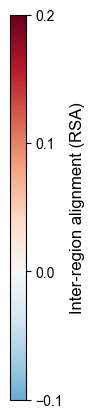

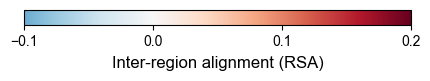

In [620]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Using the function to create a colorbar
fig, ax = plot_cbar(cmap="RdBu_r", title="Inter-region alignment (RSA)", vmin=-0.2, vmax=0.2, locator=0.1, labelpad=5, horizontal=False, percent=False, rotation=90, figsize = (0.2, 5))
ax.set_ylim(-.1, .2)
#ax.set_xlim(-0.2, 0.2)
fig.savefig(output / "colorbar_interegion_rsa_connectivity_v.pdf", bbox_inches="tight", dpi=300, transparent=True)


fig, ax = plot_cbar(cmap="RdBu_r", title="Inter-region alignment (RSA)", vmin=-0.2, vmax=0.2, locator=0.1, labelpad=5, horizontal=True, percent=False, rotation=0, figsize = (5, 0.2))
ax.set_xlim(-.1, .2)
fig.savefig(output / "colorbar_interegion_rsa_connectivity.pdf", bbox_inches="tight", dpi=300, transparent=True)

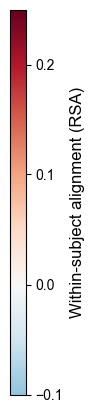

In [392]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Using the function to create a colorbar
fig, ax = plot_cbar(cmap="RdBu_r", title="Within-subject alignment (RSA)", vmin=-0.25, vmax=0.25, locator=0.1, labelpad=5, horizontal=False, percent=False, rotation=90, figsize = (0.2, 5))
ax.set_ylim(-.1, .25)
#ax.set_xlim(-0.2, 0.2)
fig.savefig(output / "colorbar_within_rsa_connectivity_v.pdf", bbox_inches="tight", dpi=300, transparent=True)


['V1', 'V2', 'V3', 'V4', 'V8', 'VVC', 'VMV1', 'VMV2', 'VMV3', 'LO2', 'LO3', 'V4t', 'FST', 'MST', 'MT', 'PHA1', 'PHA2', 'PHA3', 'TPOJ3', 'TPOJ2']


Text(95.72222222222221, 0.5, '')

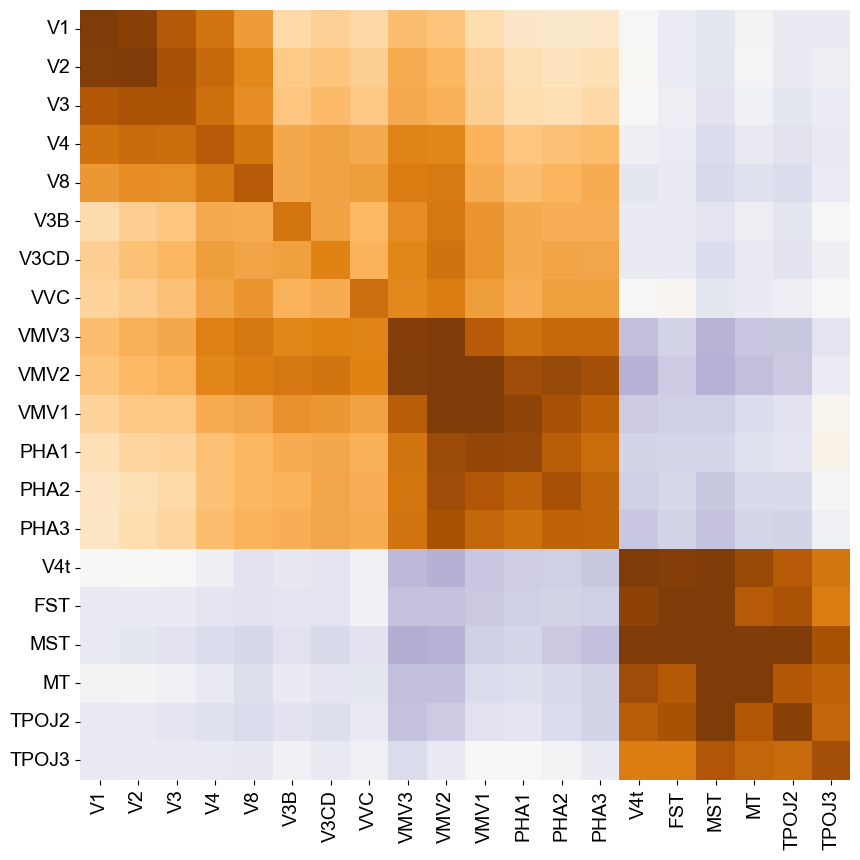

In [388]:
df_cross_subject = load_filename("cross_subject", shift=1, joined=True)
df_cross_subject = df_cross_subject.query("subject_i == subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

hcp = pd.read_csv(hcp_filename)
top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(20).roi_x.tolist()
top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
print(list(top_names.values()))
# TOP 20 vision model
order = ['V1', 'V2', 'V3', 'V4', # Early visual
         'V8',
          #'V3B', 'V3CD',
          #"V3A", 
          'VMV3',  'VMV2', 'VMV1',  # Ventral visual 
         'PHA1', 'PHA2', 'PHA3',  # Medial temporal
         
         #'VVC', 
         "DVT", "POS1",
         
         
         #'FFC', # Ventral
            # TPO
         'V4t','FST', 'MST', 'MT', 'TPOJ2', 'TPOJ3', # 'LO3', 'LO2',#'LO1',
         
         #'STV', 'TPOJ1',
         #'PH', 
         
             # MT+ visual areas
          #'IPS1', 'V3A', # 'V6A', 'V7' , # Dorsal visual
         ] 
# TOP 20 intersubject
order = ['V1', 'V2', 'V3', 'V4', # Early visual
         'V8',
          'V3B', 'V3CD',
          #"V3A", 
          'VVC', 
          'VMV3',  'VMV2', 'VMV1',  # Ventral visual 
         'PHA1', 'PHA2', 'PHA3',  # Medial temporal
         
         
         #"DVT", "POS1",
         
         
         #'FFC', # Ventral
            # TPO
         'V4t','FST', 'MST', 'MT', 'TPOJ2', 'TPOJ3', # 'LO3', 'LO2',#'LO1',
         
         #'STV', 'TPOJ1',
         #'PH', 
         
             # MT+ visual areas
          #'IPS1', 'V3A', # 'V6A', 'V7' , # Dorsal visual
         ] 

df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])

#df_cross_subject = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois")
# Pivot x rows y to columns and plot a sns.clustermap
df_cross_subject_pivotted = df_cross_subject.pivot(index="name_x", columns="name_y", values="similarity")
# Print max alignment
#print(f"Max alignment: {df_cross_subject.similarity.max():.3f}")


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(data=df_cross_subject_pivotted.loc[order, order], cmap="PuOr_r", center=0, ax=ax,  cbar=False, vmin=-0.2, vmax=0.2, cbar_kws={"shrink": 0.5})
# Increase fontsize
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_aspect('equal')
ax.set_xlabel("")
ax.set_ylabel("")

# Add p-value bracket with hub names

# Save figure
#fig.savefig(output / "cross_subject_similarity_heatmap_top_20_is.pdf", bbox_inches="tight", dpi=300, transparent=True)

[]

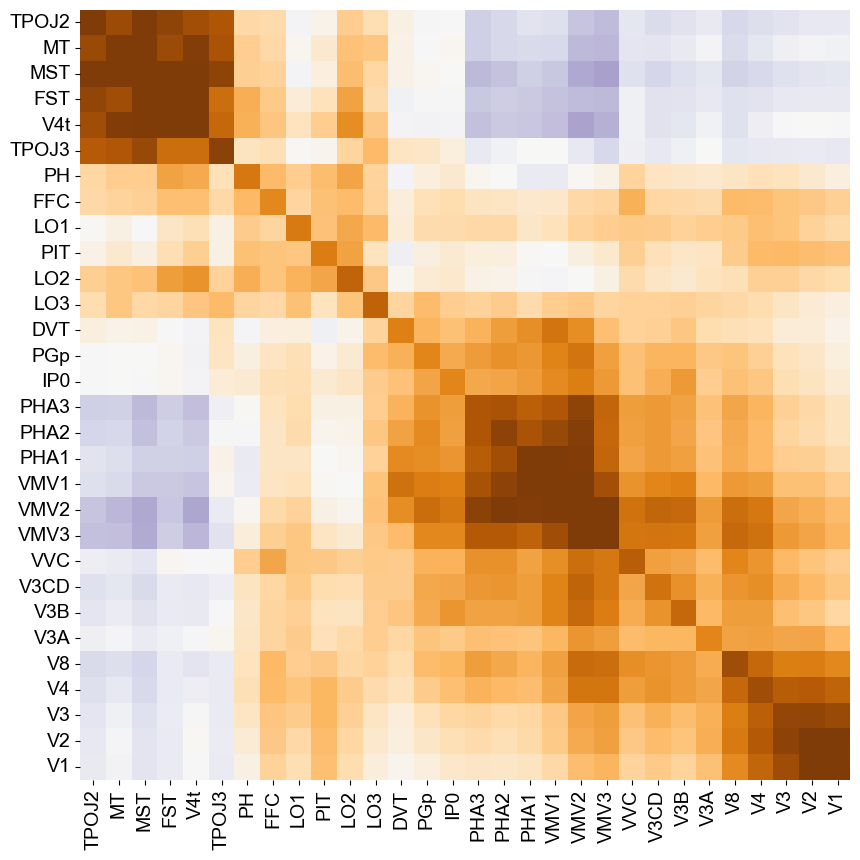

In [395]:
df_cross_subject = load_filename("cross_subject", shift=1, joined=True)
df_cross_subject = df_cross_subject.query("subject_i == subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
order3 = [
    'TPOJ2', 'MT', 'MST',   'FST',   'V4t',  'TPOJ3',
    'PH',  
    
     'FFC',  "LO1",'PIT', "LO2",   'LO3', 
    'DVT', 'PGp', 'IP0',
    'PHA3', 'PHA2', 'PHA1', 'VMV1', 'VMV2', 'VMV3', 
    'VVC', 'V3CD', 'V3B', 'V3A', 
    'V8', 'V4', 'V3', 'V2', 'V1']

hcp = pd.read_csv(hcp_filename)
top_rois = hcp[hcp.name.isin(order3)].roi.tolist()
#top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(40).roi_x.tolist()
top_names = order3 # hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
#print(list(top_names.values()))
# TOP 20 vision model
order = order3
# order = ['V1', 'V2', 'V3', 'V4', # Early visual
#          'V8',
#           #'V3B', 'V3CD',
#           #"V3A", 
#           'VMV3',  'VMV2', 'VMV1',  # Ventral visual 
#          'PHA1', 'PHA2', 'PHA3',  # Medial temporal
         
#          #'VVC', 
#          "DVT", "POS1",
         
         
#          #'FFC', # Ventral
#             # TPO
#          'V4t','FST', 'MST', 'MT', 'TPOJ2', 'TPOJ3', # 'LO3', 'LO2',#'LO1',
         
#          #'STV', 'TPOJ1',
#          #'PH', 
         
#              # MT+ visual areas
#           #'IPS1', 'V3A', # 'V6A', 'V7' , # Dorsal visual
#          ] 
# # TOP 20 intersubject
# order = ['V1', 'V2', 'V3', 'V4', # Early visual
#          'V8',
#          'V3A',
#           'V3B', 'V3CD',
#           #"V3A", 
#           'VVC', 
#           'VMV3',  'VMV2', 'VMV1',  # Ventral visual 
#          'PHA1', 'PHA2', 'PHA3',  # Medial temporal
         
         
#          #"DVT", "POS1",
         
#       'V7',
#       'IPS1',
         
#          #'FFC', # Ventral
#             # TPO
#          'V4t','FST', 'MST', 'MT', 'TPOJ2', 'TPOJ3', # 'LO3', 'LO2',#'LO1',
#          'TPOJ1',
#          #'STV', 'TPOJ1',
#          #'PH', 
         
#              # MT+ visual areas
#           #'IPS1', 'V3A', # 'V6A', 'V7' , # Dorsal visual

#           'FEF',
#  'PIT',
#  'FFC',
#  'LO3',
#  'LO1',
#  'LO2',
#  'PH',
 
#  'POS1',
#  '7Pl',
#  'LIPv',
#  'MIP',
#  'ProS',
 
 
#  'DVT',
#  'PGp',
#  'IP0',
#  'V6A',
 
#          ] 

top_names = hcp.name[hcp.roi.isin(top_rois)].tolist()

others = [name for name in top_names if name not in order]
order = order + others

df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])

#df_cross_subject = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois")
# Pivot x rows y to columns and plot a sns.clustermap
df_cross_subject_pivotted = df_cross_subject.pivot(index="name_x", columns="name_y", values="similarity")
# Print max alignment
#print(f"Max alignment: {df_cross_subject.similarity.max():.3f}")


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(data=df_cross_subject_pivotted.loc[order, order], cmap="PuOr_r", center=0, ax=ax,  cbar=False, vmin=-0.18, vmax=0.18, cbar_kws={"shrink": 0.5})
# Increase fontsize
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_aspect('equal')
ax.set_xlabel("")
ax.set_ylabel("")

# Add p-value bracket with hub names

# Save figure
#fig.savefig(output / "cross_subject_similarity_heatmap_top_20_is.pdf", bbox_inches="tight", dpi=300, transparent=True)
others

In [ ]:
df_comparison_subjects = proccess_alignment(group_subject=False)

# order2 = ['V3A',
#           'V3B', 'V3CD',
#           #"V3A", 
#           'VVC', 
#           'VMV3',  'VMV2', 'VMV1',  # Ventral visual 
#          'PHA1', 'PHA2', 'PHA3',  # Medial temporal
         
         
#          #"DVT", "POS1",
         
#       'V7',
#       'IPS1',
#          ] 
# sns.clustermap(data=df_cross_subject_pivotted.loc[order2, order2], method="ward")


In [396]:
df_depths = df_comparison_subjects[["roi", "subject", "vision_depth"]].copy()
df_depths_merged = df_depths.merge(df_depths, on="subject", suffixes=("_x", "_y"))
df_depths_merged = df_depths_merged.merge(df_edges[["roi_x", "roi_y"]], on=["roi_x", "roi_y"], how="inner")
df_depths_merged_joined = df_depths_merged.groupby(["roi_x", "roi_y"]).apply(lambda x: ttest_rel(x["vision_depth_x"], x["vision_depth_y"]), include_groups=False).reset_index()
df_depths_merged_joined = df_depths_merged_joined.rename(columns={0: "stats"})
df_depths_merged_joined["t_stat"] = df_depths_merged_joined.stats.apply(lambda x: x.statistic)
df_depths_merged_joined["p_value"] = df_depths_merged_joined.stats.apply(lambda x: x.pvalue)
df_depths_merged_joined = df_depths_merged_joined.drop(columns=["stats"])
# Correct p-values (FDR correction)
p_values = df_depths_merged_joined["p_value"].values
df_depths_merged_joined["p_corrected"] = multipletests(p_values, method="fdr_bh")[1].round(5)
# df_depths_merged_joined["significant"] = df_depths_merged_joined["p_corrected"].apply(lambda x: "*" * int(-np.log10(x)) if x < 0.05 else "n.s.")

hcp = pd.read_csv(hcp_filename)
df_depths_merged_joined = df_depths_merged_joined.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x", "roi": "roi_x"}), on="roi_x", how="left")
df_depths_merged_joined = df_depths_merged_joined.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y", "roi": "roi_y"}), on="roi_y", how="left")
df_depths_merged_joined

roi_x  roi_y      t_stat       p_value  p_corrected name_x name_y
0        1      2 -103.605087  2.056964e-12      0.00000     V1    MST
1        1      4   -2.432552  4.525076e-02      0.05660     V1     V2
2        1      5   -6.809983  2.509210e-04      0.00058     V1     V3
3        1      6   -7.756146  1.110098e-04      0.00029     V1     V4
4        1      7   -9.688535  2.634624e-05      0.00009     V1     V8
..     ...    ...         ...           ...          ...    ...    ...
788    163    156   -4.397874  3.165004e-03      0.00527    VVC    V4t
789    163    157   -4.837484  1.883195e-03      0.00333    VVC    FST
790    163    158    0.890943  4.025427e-01      0.43848    VVC   V3CD
791    163    159   -5.437619  9.687042e-04      0.00189    VVC    LO3
792    163    160   -2.193198  6.437418e-02      0.07927    VVC   VMV2

[793 rows x 7 columns]

In [397]:
# Cell 1: Function Definitions
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import laplacian, reverse_cuthill_mckee
from scipy.linalg import eigh
from scipy.sparse import csr_matrix

def reorder_matrix_spectral_simplified(df: pd.DataFrame,
                                       use_normalized_laplacian: bool = True,
                                       interpret_negative_as_weak_connection: bool = True) -> pd.DataFrame:
    node_names = df.index
    conn_matrix_original = df.to_numpy() # Keep original values for reconstruction

    if interpret_negative_as_weak_connection:
        # For Laplacian, typically non-negative weights are assumed.
        # This clips negative values to 0.
        # If your negative values have specific meaning for clustering (e.g., strong repulsion),
        # consider df.abs() or other preprocessing before calling this function,
        # and set interpret_negative_as_weak_connection=False.
        processed_conn_matrix_for_laplacian = np.maximum(conn_matrix_original, 0)
    else:
        processed_conn_matrix_for_laplacian = conn_matrix_original

    L = laplacian(processed_conn_matrix_for_laplacian, normed=use_normalized_laplacian)
    eigenvalues, eigenvectors = eigh(L) # eigh for dense symmetric matrices
    
    # Fiedler vector is the eigenvector for the 2nd smallest eigenvalue
    fiedler_vector = eigenvectors[:, 1]
    new_order_indices = np.argsort(fiedler_vector)

    # Reconstruct the DataFrame with the new order using original matrix values
    reordered_df = pd.DataFrame(
        conn_matrix_original[np.ix_(new_order_indices, new_order_indices)],
        index=node_names[new_order_indices],
        columns=node_names[new_order_indices]
    )
    return reordered_df

def reorder_matrix_rcm_simplified(df: pd.DataFrame) -> pd.DataFrame:
    node_names = df.index
    conn_matrix_np = df.to_numpy()
    
    # RCM operates on the sparsity structure of the graph
    graph_sparse = csr_matrix(conn_matrix_np)
    rcm_order_indices = reverse_cuthill_mckee(graph_sparse, symmetric_mode=True)
    
    # Reconstruct the DataFrame with the new order
    reordered_df = pd.DataFrame(
        conn_matrix_np[np.ix_(rcm_order_indices, rcm_order_indices)],
        index=node_names[rcm_order_indices],
        columns=node_names[rcm_order_indices]
    )
    return reordered_df

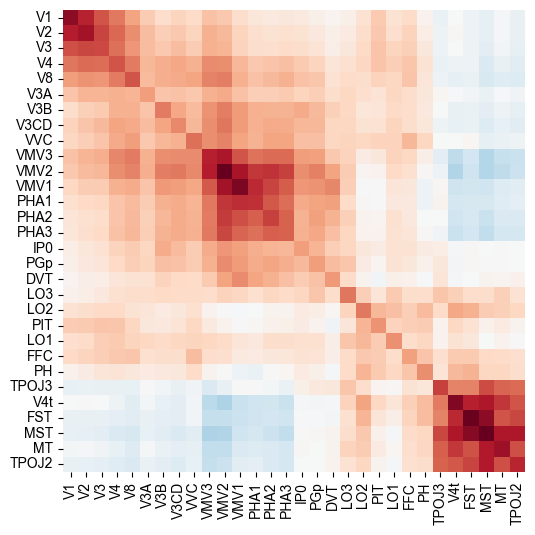

In [400]:
# --- Apply Spectral Reordering ---

# Replace in order Hipp by H
#top_rois_x = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(30).name_x.tolist()
#order3 = [name.replace("Hipp", "H") for name in order]
#order3 = [name for name in order3 if name in top_rois_x]



df_spectral_reordered = reorder_matrix_spectral_simplified(df_cross_subject_pivotted.loc[order3,order3].copy())
#


# print("DataFrame after Spectral Reordering:")
# print(df_spectral_reordered)
# print("\n" + "="*40 + "\n")

# --- Apply Reverse Cuthill-McKee Reordering ---
df_rcm_reordered = reorder_matrix_rcm_simplified(df_spectral_reordered.copy())
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#sns.heatmap(data=df_rcm_reordered, cmap="PuOr_r", center=0, vmin=-0.2, vmax=0.2, xticklabels=intermediate, yticklabels=intermediate, square=True, ax=ax, cbar=False)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
order3 = [
    'TPOJ2', 'MT', 'MST',   'FST',   'V4t',  'TPOJ3',
    'PH',  
    
     'FFC',  "LO1",'PIT', "LO2",   'LO3', 
    'DVT', 'PGp', 'IP0',
    'PHA3', 'PHA2', 'PHA1', 'VMV1', 'VMV2', 'VMV3', 
    'VVC', 'V3CD', 'V3B', 'V3A', 
    'V8', 'V4', 'V3', 'V2', 'V1']

#print([col for col in df_rcm_reordered.columns if col not in order3])

df_plot = df_rcm_reordered.loc[order3[::-1], order3[::-1]].copy()
sns.heatmap(data=df_plot, cmap="RdBu_r", center=0, vmin=-0.25, vmax=0.25, xticklabels=df_plot.columns, yticklabels=df_plot.index, square=True, ax=ax, cbar=False)
ax.set_xlabel("")
ax.set_ylabel("");
# Display all the xlables and ylabels (currently skipped values)

# print("DataFrame after RCM Reordering:")
# print(df_rcm_reordered)
#fig.savefig(output / "cross_subject_similarity_heatmap_top_30_RdBu_small.pdf", bbox_inches="tight", dpi=300, transparent=True)

fig.savefig(output / "within_subject_similarity_heatmap_top_30_RdBu_small_cross.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [263]:
# import networkx as nx
# df_cross_subject = load_filename("cross_subject", shift=1, joined=True)
# df_cross_subject = df_cross_subject.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

# hcp = pd.read_csv(hcp_filename)
# top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(20).roi_x.tolist()
# top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
# df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
# df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
# df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
# df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

# # Threshold
# threshold = 0.07522 # df_nodes.abs_similarity.min() # 
# df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
# df_nodes = df_cross_subject_top.query("roi_x == roi_y").copy().rename(columns={"similarity": "score"})
# df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
# df_edges["weight"] = df_edges.score.abs() * 100

# areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
# colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

# node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")

# vmin, vmax = -0.2, 0.2
# #cmap = custom_cmap
# # cmap a RdBu_r with vmin -0.2 and vmax 0.2
# cmap = plt.get_cmap("PuOr_r")

# G = nx.from_pandas_edgelist(
#     df_edges,
#     source="name_x",
#     target="name_y",
#     edge_attr=["score", "weight"],
#     create_using=nx.Graph(),
# )

# fig, ax = plot_graph(mst_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_merged_joined, vmin_custom=vmin, vmax_custom=vmax)
# #pos = nx.kamada_kawai_layout(G, dim=2, weight="weight", center=(0, 0))
# pos = nx.spring_layout(G, dim=2, weight="weight", center=(0, 0), iterations=100, seed=6, scale=0.5)
# # Minor visual adjustments to the layout
# # Move dorsal cluster
# dorsal_hub = ["TPOJ2", "TPOJ3", "MST", "MT", "V4t", "FST"]
# for node in dorsal_hub:
#     pos[node] += np.array([0.1, -0.25])

# pos["MT"] += np.array([-0.018, -0.063])
# pos["V8"] += np.array([0.02, 0])
# #pos["V3CD"] += np.array([0.1, -0.1])
# pos["V4t"], pos["MST"] = pos["MST"], pos["V4t"]
# pos["MT"], pos["FST"] = pos["FST"], pos["MT"]
# pos["V4t"][0] = pos["TPOJ2"][0]

# # Draw the graph
# fig, ax = plt.subplots(figsize=(6, 8))
# ax.axis("off")

# # Inver y axis
# # ax.invert_yaxis()

# #cmap = plt.get_cmap("magma")
# norm = plt.Normalize(vmin=vmin, vmax=vmax)

# # Draw nodes
# node_positions = {node: pos[node] for node in G.nodes()}
# for node, (x, y) in node_positions.items():
#     score = node_score[node]["score"]
#     norm_score = norm(score)


#     color = cmap(norm_score)
#     s = 5 + 300 * norm_score**2
#     area_color = colors[areas[node]]

#     #marker = markers.get(node, "o")
#     marker = "o"
#     ax.scatter(
#         x,
#         y,
#         s=s,
#         color=color,
#         alpha=1,
#         label=node,
#         zorder=500 + 300*norm_score,
#         edgecolors=area_color,
#         linewidths=1.5,
#         marker=marker,
#     )
#     ax.text(x, y + 0.02, node, fontsize=10, ha="center", zorder=1000)


# edge_positions = [
#     (edge[0], edge[1], pos[edge[0]], pos[edge[1]], edge[2]["score"]) for edge in G.edges(data=True)
# ]


# depths = []
# for name_x, name_y, start, end, score in edge_positions:
#     #if name_x not in node_score or name_y not in node_score or name_x in exclude or name_y in exclude:
#     #    continue
#     xs, ys = zip(start, end)
#     normalize_edge_weight = norm(score)
#     lw = 1 + 2 * (normalize_edge_weight)
#     color = cmap(normalize_edge_weight)

#     row = df_depths_merged_joined.query("name_x == @name_x and name_y == @name_y")
#     if row.empty:
#         print("HEy something strange")
#         continue
#     else:
#         row = row.iloc[0]
#         p_corrected = row["p_corrected"]
#         t_test = row["t_stat"]
    
#     #color = cmap(diff*2)

#     if p_corrected > 0.05:
#         direction = "-"
#     elif t_test < 0:
#         direction = "->"
#     else: # t_test < 0:
#         direction = "<-"
    
    
#     plot_connection(start, end, ax, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100, direction=direction, arrow_size=18)

# #fig.savefig(output / "depth_connectivity_graph.svg", bbox_inches="tight", dpi=300, transparent=True)


In [19]:
    
df_depths_cross = df_depths.merge(df_depths, on=["subject"]).query("roi_x < roi_y").copy()
# Compute t-test for each pair of rois
df_depths_cross = df_depths_cross.groupby(["roi_x", "roi_y"]).apply(lambda x: ttest_rel(x["vision_depth_x"], x["vision_depth_y"]), include_groups=False).reset_index()
df_depths_cross["p_value"] = df_depths_cross.apply(lambda x: x[0][1], axis=1)
df_depths_cross["t_stat"] = df_depths_cross.apply(lambda x: x[0][0], axis=1)

#df_depths_cross



In [66]:
selected_rows = []

hcp_name = hcp.query("roi<=180").set_index("name")
for name1, name2 in plotting_graph.edges:
    selected_rows.append({"name1": name1, "name2": name2, "roi_x": hcp_name.loc[name1, "roi"], "roi_y": hcp_name.loc[name2, "roi"]})
    selected_rows.append({"name2": name1, "name1": name2, "roi_y": hcp_name.loc[name1, "roi"], "roi_x": hcp_name.loc[name2, "roi"]})
selected_rows = pd.DataFrame(selected_rows).drop_duplicates().reset_index(drop=True)
selected_rows

df_depths_cross_selected = df_depths_cross.merge(selected_rows, on=["roi_x", "roi_y"], how="inner").drop(columns=[0])
# Apply 
df_depths_cross_selected["p_value_corrected"] = multipletests(df_depths_cross_selected["p_value"].values, method="fdr_bh")[1].round(5)
df_depths_cross_selected = df_depths_cross_selected.rename(columns={"name1": "name_x", "name2": "name_y"})
df_depths_cross_selected.query("p_value_corrected < 0.05")

roi_x  roi_y   p_value     t_stat name_x name_y  p_value_corrected
1        1      5  0.000251  -6.809983     V1     V3            0.00253
2        2     21  0.000626   5.856854    MST    LO2            0.00477
4        2     25  0.000677   5.780298    MST    PSL            0.00491
5        2     27  0.000034   9.324618    MST    PCV            0.00055
7        2     65  0.000002  14.711736    MST    10r            0.00005
..     ...    ...       ...        ...    ...    ...                ...
285    141    166  0.000001  15.417009  TPOJ3   pOFC            0.00004
290    143    160  0.003736   4.262321    PGp   VMV2            0.01821
291    143    166  0.000932   5.473600    PGp   pOFC            0.00594
301    153    155  0.007850  -3.680965   VMV1   PHA2            0.03181
309    159    178  0.000357   6.429971    LO3     PI            0.00309

[84 rows x 7 columns]

In [599]:
order3

['TPOJ2',
 'MT',
 'MST',
 'FST',
 'V4t',
 'TPOJ3',
 'PH',
 'FFC',
 'LO1',
 'PIT',
 'LO2',
 'LO3',
 'DVT',
 'PGp',
 'IP0',
 'PHA3',
 'PHA2',
 'PHA1',
 'VMV1',
 'VMV2',
 'VMV3',
 'VVC',
 'V3CD',
 'V3B',
 'V3A',
 'V8',
 'V4',
 'V3',
 'V2',
 'V1']

significant rois 30
Top names 30


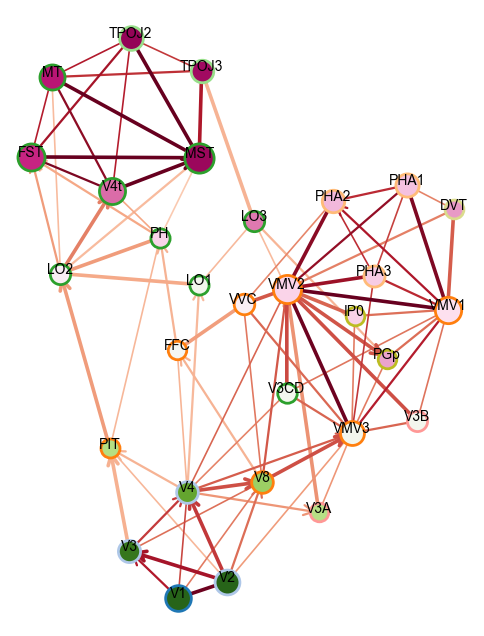

In [329]:
import networkx as nx
df_cross_subject = load_filename("cross_subject", shift=1, joined=True)
df_cross_subject = df_cross_subject.query("subject_i == subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

p_values_subject = pd.read_parquet(pvalues_filename).query("comparison=='intersubject'")
rois_significant = p_values_subject[p_values_subject.pvalue_fdr_bh < 0.05].roi

hcp = pd.read_csv(hcp_filename).query("roi <= 180")
#top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(30).roi_x.tolist()
top_rois = hcp.query("name in @order3").roi.tolist()
print("significant rois", len(top_rois))
top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
print("Top names", len(top_names))
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

# Threshold
threshold = 0.05#5#df_nodes.abs_similarity.min() # 
df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
df_nodes = df_cross_subject_top.query("roi_x == roi_y and abs_similarity > @threshold").copy().rename(columns={"similarity": "score"})
df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
df_edges["weight"] = (1 - df_edges.score)*100
areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)

#mst_graph = nx.minimum_spanning_tree(G, weight='weight')
spanning_tree = efficient_iterative_max_spanning_trees(G, num_trees=3, similarity_attr="score")
spanning_tree

plotting_graph = spanning_tree
vmin, vmax = -0.2, 0.2
seed = 2

def layout_callback(graph_to_plot):
    #layout = nx.spring_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), iterations=1000, seed=4, scale=1)
    #layout = nx.kamada_kawai_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), scale=1.5)
    #layout = nx.spring_layout(graph_to_plot, seed=4)ç
    #layout = nx.spectral_layout(graph_to_plot, dim=2, weight="weight", scale=1.5)
    layout = nx.forceatlas2_layout(graph_to_plot,  seed=seed, weight="weight", dim=2, gravity=10)
    #nodes = ["VMV3", "VMV2", "PHA1", "PHA2", ""]
    layout["V3"] += (-1, 0)
    layout["V8"] += (4, -0.5)
    layout["V4"] += (-4, 6)
    layout["MT"] += (-3, 0)
    layout["VMV2"] += (0, -2)
    layout["VVC"] += (-1, -2)
    layout["VMV3"] += (1, -1)
    layout["V3CD"] += (-1.5, 1)
    layout["V3A"] += (2, 1)
    layout["PHA3"] += (0, 3)
    layout["PGp"] += (2, 0)
    layout["V3B"] += (-1, -1)
    layout["PHA1"] += (0, 2)
    layout["PHA2"] += (0, 1)
    layout["VVC"] += (0, -1)
    layout["MST"] += (6, 0.5)
    layout["V4t"] += (3, 1)
    layout["VMV1"] += (2, 0)
    layout["PH"] += (5, -5)
    layout["FFC"] += (-2, 0)
    #layout["LO1"] += (-5, 2)
    
    return layout


df_depths_grouped = df_depths.groupby("roi").vision_depth.mean().reset_index()
df_depths_grouped = df_depths_grouped.merge(hcp[["roi", "name"]], on="roi")
df_depths_grouped = df_depths_grouped.set_index("name")

fig, ax = plot_graph(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, layout_callback=layout_callback,
                     node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
                     default_cmap_name="RdBu_r", iteration_multiplier=0.6, df_depths_grouped=df_depths_grouped)

# Flip y axis
ax.invert_yaxis()


#fig.savefig(output / "connectivity_graph_nsd_depth_rdbu.svg", bbox_inches="tight", dpi=300, transparent=True)

significant rois 30
Top names 30


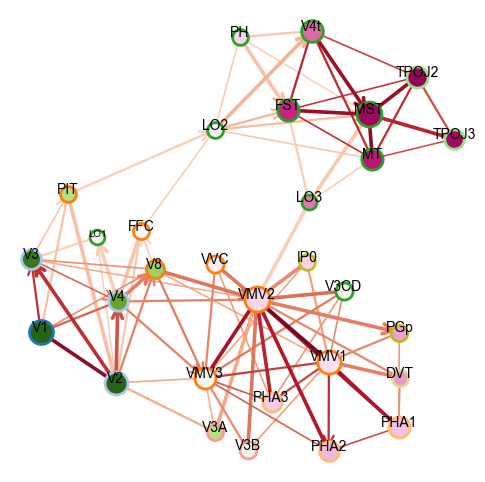

In [380]:
import networkx as nx
df_cross_subject = load_filename("cross_subject", shift=1, joined=True)
df_cross_subject = df_cross_subject.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

p_values_subject = pd.read_parquet(pvalues_filename).query("comparison=='intersubject'")
rois_significant = p_values_subject[p_values_subject.pvalue_fdr_bh < 0.05].roi

hcp = pd.read_csv(hcp_filename).query("roi <= 180")
#top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(30).roi_x.tolist()
top_rois = hcp.query("name in @order3").roi.tolist()
print("significant rois", len(top_rois))
top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
print("Top names", len(top_names))
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

# Threshold
threshold = 0.01#5#df_nodes.abs_similarity.min() # 
df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
df_nodes = df_cross_subject_top.query("roi_x == roi_y and abs_similarity > @threshold").copy().rename(columns={"similarity": "score"})
df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
df_edges["weight"] = (1 - df_edges.score)*100
areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)

#mst_graph = nx.minimum_spanning_tree(G, weight='weight')
spanning_tree = efficient_iterative_max_spanning_trees(G, num_trees=3, similarity_attr="score")
spanning_tree

plotting_graph = spanning_tree
vmin, vmax = -0.2, 0.2
seed = 4

def layout_callback(graph_to_plot):
    #layout = nx.spring_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), iterations=1000, seed=4, scale=1)
    #layout = nx.kamada_kawai_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), scale=1.5)
    #layout = nx.spring_layout(graph_to_plot, seed=4)ç
    #layout = nx.spectral_layout(graph_to_plot, dim=2, weight="weight", scale=1.5)
    layout = nx.forceatlas2_layout(graph_to_plot,  seed=seed, weight="weight", dim=2, gravity=10)
    #nodes = ["VMV3", "VMV2", "PHA1", "PHA2", ""]
    # layout["V3"] += (-1, 0)
    # layout["V8"] += (4, -0.5)
    # layout["V4"] += (-4, 6)
    # layout["MT"] += (-3, 0)
    # layout["VMV2"] += (0, -2)
    # layout["VVC"] += (-1, -2)
    # layout["VMV3"] += (1, -1)
    # layout["V3CD"] += (-1.5, 1)
    # layout["V3A"] += (2, 1)
    # layout["PHA3"] += (0, 3)
    # layout["PGp"] += (2, 0)
    # layout["V3B"] += (-1, -1)
    # layout["PHA1"] += (0, 2)
    # layout["PHA2"] += (0, 1)
    # layout["VVC"] += (0, -1)
    # layout["MST"] += (6, 0.5)
    # layout["V4t"] += (3, 1)
    # layout["VMV1"] += (2, 0)
    # layout["PH"] += (5, -5)
    # layout["FFC"] += (-2, 0)
    # layout["LO1"] += (2, -18)
    # layout["V3A"] += (-2, -2)
    layout["V1"], layout["V3"] = layout["V3"], layout["V1"]
    layout["MST"] += (-2, -2)
    layout["VMV3"] += (2, -1)
    layout["FFC"] += (6, 6)
    layout["LO1"] += (-6, 17)
    layout["V3CD"] += (-6, 3)
    layout["IP0"] += (-2, 2)
    layout["V2"], layout["V4"] = layout["V4"], layout["V2"]
    layout["FFC"] += (-2, 0)
    layout["V4"] += (-2, 0)
    layout["V3A"], layout["VVC"] = layout["VVC"], layout["V3A"]
    layout["V3B"] += (2, 0)
    layout["V3A"] += (0, 2)
    
    return layout


df_depths_grouped = df_depths.groupby("roi").vision_depth.mean().reset_index()
df_depths_grouped = df_depths_grouped.merge(hcp[["roi", "name"]], on="roi")
df_depths_grouped = df_depths_grouped.set_index("name")

fig, ax = plot_graph(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, layout_callback=layout_callback,
                     node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
                     default_cmap_name="RdBu_r", iteration_multiplier=0.6, df_depths_grouped=df_depths_grouped, figsize=(6, 6))

# Flip y axis
#ax.invert_yaxis()
ax.invert_xaxis()


fig.savefig(output / "connectivity_graph_nsd_depth_rdbu_intersubject.svg", bbox_inches="tight", dpi=300, transparent=True)

In [245]:
df_depths_grouped_areas

name  vision_depth
0    Anterior Cingulate & mPFC      0.492591
1                     Auditory      0.475904
2         Auditory Association      0.529395
3                        DLPFC      0.514466
4                Dorsal Visual      0.484260
5          Early Visual (V2-4)      0.237180
6       Inferior Frontal Gyrus      0.529559
7            Inferior Parietal      0.565573
8   Insula & Frontal Operculum      0.488817
9             Lateral Temporal      0.533301
10            MT+ Visual Areas      0.633458
11             Medial Temporal      0.561963
12               Mid Cingulate      0.508208
13         OFC & Frontal Polar      0.504419
14                   Opercular      0.471100
15         Posterior Cingulate      0.577696
16                    Premotor      0.540952
17              Primary Visual      0.192689
18                 Somatomotor      0.479991
19           Superior Parietal      0.529403
20                         TPO      0.735297
21              Ventral Visual      0.480898

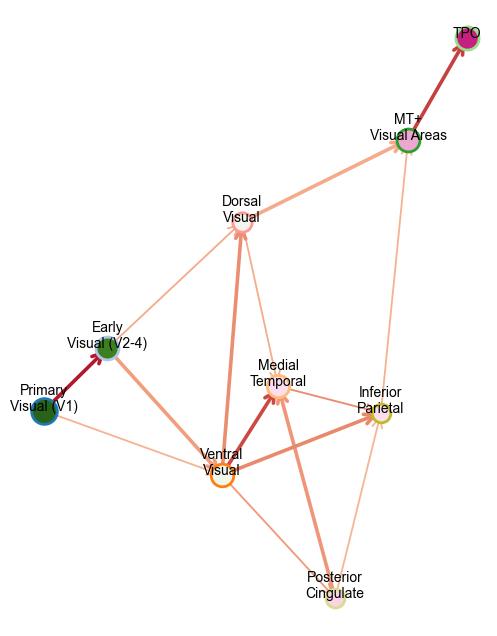

In [294]:

hcp = pd.read_csv(hcp_filename).query("roi <= 180")
hcp.area = hcp.area.replace({
    "Primary Visual": "Primary\nVisual (V1)",
    "Early Visual (V2-4)": "Early\nVisual (V2-4)",
    "Dorsal Visual": "Dorsal\nVisual",
    "Medial Temporal": "Medial\nTemporal",
    "Ventral Visual": "Ventral\nVisual",
    "Posterior Cingulate": "Posterior\nCingulate",
    "Inferior Parietal": "Inferior\nParietal",
    "MT+ Visual Areas": "MT+\nVisual Areas",
})

df_nodes_areas = df_nodes.merge(hcp[["roi", "area"]].rename(columns={"area": "area_x", "roi": "roi_x"}), on="roi_x", how="left")
df_nodes_areas = df_nodes_areas.merge(hcp[["roi", "area"]].rename(columns={"area": "area_y", "roi": "roi_y"}), on="roi_y", how="left")
df_nodes_areas = df_nodes_areas.groupby(["area_x", "area_y"]).agg({"score": "mean"}).reset_index()
df_nodes_areas = df_nodes_areas.rename(columns={"area_x": "name_x", "area_y": "name_y"})

df_edges_areas = df_edges.merge(hcp[["roi", "area"]].rename(columns={"area": "area_x", "roi": "roi_x"}), on="roi_x", how="left")
df_edges_areas = df_edges_areas.merge(hcp[["roi", "area"]].rename(columns={"area": "area_y", "roi": "roi_y"}), on="roi_y", how="left")
df_edges_areas
df_edges_areas = df_edges_areas.groupby(["area_x", "area_y"]).agg({"score": "mean", "weight": "mean"}).reset_index()
df_edges_areas = df_edges_areas.rename(columns={"area_x": "name_x", "area_y": "name_y"})
df_edges_areas = df_edges_areas.query("score>0.01")

df_depths_grouped_areas = df_depths_grouped.merge(hcp[["roi", "area"]], on="roi")
df_depths_grouped_areas = df_depths_grouped_areas.groupby("area").vision_depth.mean().reset_index()
df_depths_grouped_areas = df_depths_grouped_areas.rename(columns={"area": "name"})


G = nx.from_pandas_edgelist(
    df_edges_areas,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)
spanning_tree = efficient_iterative_max_spanning_trees(G, num_trees=2, similarity_attr="score")
spanning_tree

plotting_graph = spanning_tree
vmin, vmax = -0.2, 0.2
seed = 6

def layout_callback(graph_to_plot):
    #layout = nx.spring_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), iterations=1000, seed=4, scale=1)
    #layout = nx.kamada_kawai_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), scale=1.5)
    #layout = nx.spring_layout(graph_to_plot, seed=4)ç
    #layout = nx.spectral_layout(graph_to_plot, dim=2, weight="weight", scale=1.5)
    layout = nx.forceatlas2_layout(graph_to_plot,  seed=seed, weight="score", dim=2, gravity=1)
    return layout

fig, ax = plot_graph(plotting_graph, df_nodes_areas, df_edges_areas, hcp, vmin_custom=vmin, vmax_custom=vmax, layout_callback=layout_callback,
                     node_edge_linewidth=2, default_cmap_name="RdBu_r", iteration_multiplier=0.99,
                     default_cmap_node="PiYG_r",  node_color="depth", df_depths_info_arg=None, df_depths_grouped=df_depths_grouped_areas.set_index("name"),
                     variant="area"
)

ax.invert_yaxis()
ax.invert_xaxis()
fig.savefig(output / "connectivity_graph_nsd_depth_rdbu_areas.svg", bbox_inches="tight", dpi=300, transparent=True)

Top names 157


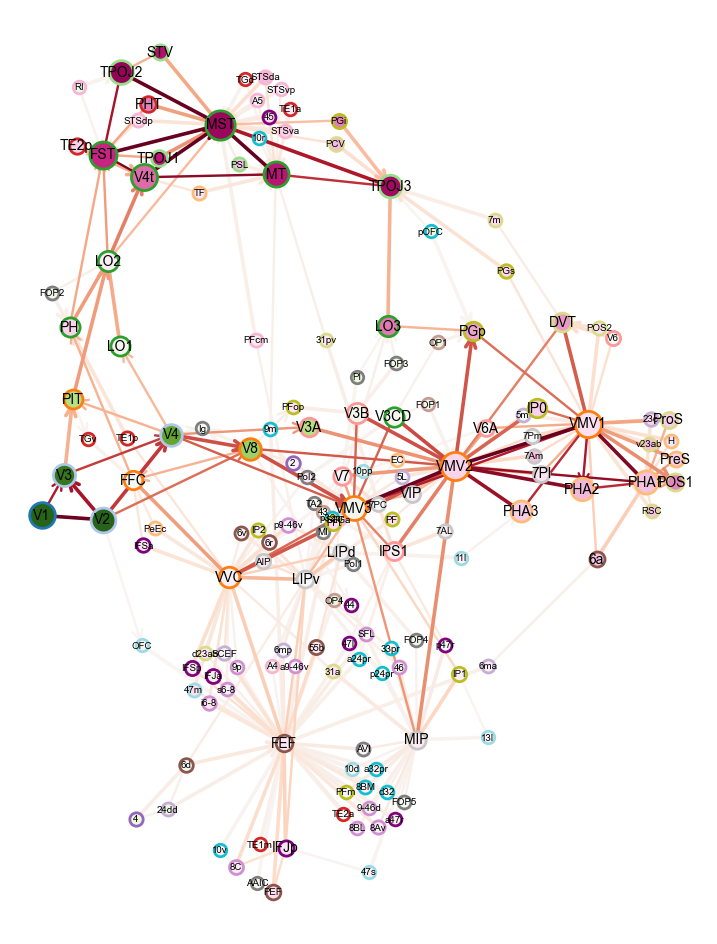

In [410]:
import networkx as nx
df_cross_subject = load_filename("cross_subject", shift=1, joined=True)

df_cross_subject = df_cross_subject.query("subject_i == subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

p_values_subject = pd.read_parquet(pvalues_filename).query("comparison=='intersubject'")

rois_significant = p_values_subject[p_values_subject.pvalue_fdr_bh < 0.05].roi


hcp = pd.read_csv(hcp_filename).query("roi <= 180")
#top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(30).roi_x.tolist()
top_rois = hcp.query("roi in @rois_significant").roi.tolist()

# print("significant rois", len(top_rois))
top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
print("Top names", len(top_names))
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

# Threshold
threshold = 0.0#1#df_nodes.abs_similarity.min() # 
df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
df_nodes = df_cross_subject_top.query("roi_x == roi_y and abs_similarity > @threshold").copy().rename(columns={"similarity": "score"})
df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
df_edges["weight"] = (1 - df_edges.score)*100
areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)

#mst_graph = nx.minimum_spanning_tree(G, weight='weight')
num_trees = 2
spanning_tree = efficient_iterative_max_spanning_trees(G, num_trees=num_trees, similarity_attr="score")
spanning_tree

plotting_graph = spanning_tree
vmin, vmax = -0.2, 0.2
seed = 5

def layout_callback(graph_to_plot):
    #layout = nx.spring_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), iterations=1000, seed=4, scale=1)
    #layout = nx.kamada_kawai_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), scale=1.5)
    #layout = nx.spring_layout(graph_to_plot, seed=4)ç
    #layout = nx.spectral_layout(graph_to_plot, dim=2, weight="weight", scale=1.5)
    layout = nx.forceatlas2_layout(graph_to_plot,  seed=seed, weight="weight", dim=2, gravity=10)
    #nodes = ["VMV3", "VMV2", "PHA1", "PHA2", ""]
    layout["TF"] -= (-2, 4)
    layout["PSL"] -= (0, -3)
    layout["pOFC"] -= (4,0)
    layout["LO2"] -= (-3,0)
    layout["PH"] -= (3,0)
    layout["V8"] += (0, 3)
    layout["TGv"] += (6, 0)
    layout["FOP3"] +=( 8, -4)
    
    return layout


df_depths_grouped = df_depths.groupby("roi").vision_depth.mean().reset_index()
df_depths_grouped = df_depths_grouped.merge(hcp[["roi", "name"]], on="roi")
df_depths_grouped = df_depths_grouped.set_index("name")

# fig, ax = plot_graph(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, iteration_multiplier=0.5, layout_callback=layout_callback,
#                      node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
#                      default_cmap_name="RdBu_r", figsize=(6*1.5, 8*1.5), node_label_dy_offset=-1, df_depths_grouped=df_depths_grouped)

fig, ax = plot_graph(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, iteration_multiplier=0.5, layout_callback=layout_callback,
                     node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
                     default_cmap_name="RdBu_r", figsize=(6*1.5, 8*1.5), node_label_dy_offset=-1, df_depths_grouped=df_depths_grouped)


# Flip y axis
#ax.invert_yaxis()


#fig.savefig(output / f"connectivity_graph_nsd_depth_full_{num_trees}.svg", bbox_inches="tight", dpi=300, transparent=True)

Top names 157


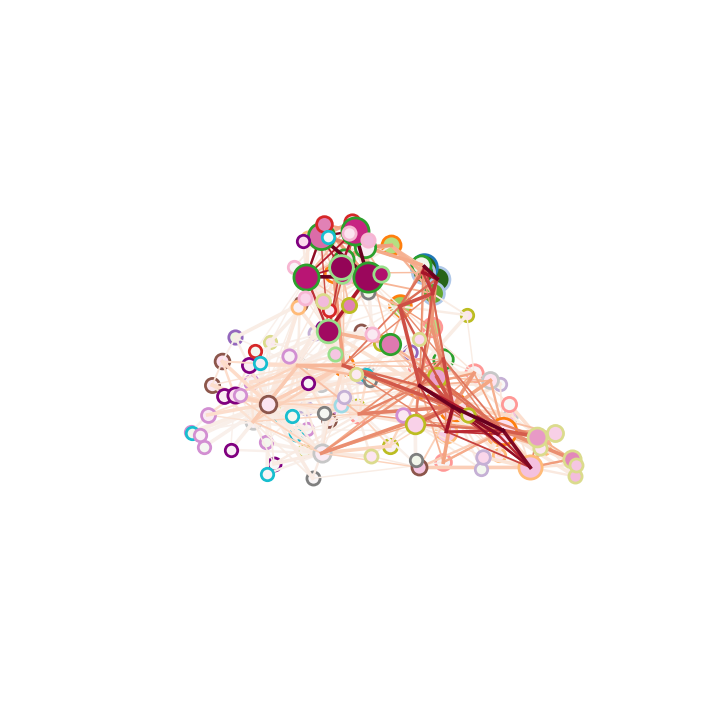

In [460]:
import networkx as nx
df_cross_subject = load_filename("cross_subject", shift=1, joined=True)

df_cross_subject = df_cross_subject.query("subject_i == subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

p_values_subject = pd.read_parquet(pvalues_filename).query("comparison=='intersubject'")

rois_significant = p_values_subject[p_values_subject.pvalue_fdr_bh < 0.05].roi


hcp = pd.read_csv(hcp_filename).query("roi <= 180")
#top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(30).roi_x.tolist()
top_rois = hcp.query("roi in @rois_significant").roi.tolist()

# print("significant rois", len(top_rois))
top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
print("Top names", len(top_names))
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

# Threshold
threshold = 0.01#1#df_nodes.abs_similarity.min() # 
df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
df_nodes = df_cross_subject_top.query("roi_x == roi_y and abs_similarity > @threshold").copy().rename(columns={"similarity": "score"})
df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
df_edges["weight"] = (1 - df_edges.score)*100
areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


G = nx.from_pandas_edgelist(
    df_edges,
    source="name_x",
    target="name_y",
    edge_attr=["score", "weight"],
    create_using=nx.Graph(),
)

#mst_graph = nx.minimum_spanning_tree(G, weight='weight')
num_trees = 4
spanning_tree = efficient_iterative_max_spanning_trees(G, num_trees=num_trees, similarity_attr="score")
spanning_tree

plotting_graph = spanning_tree
vmin, vmax = -0.2, 0.2
seed = 5

def layout_callback(graph_to_plot):
    #layout = nx.spring_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), iterations=1000, seed=4, scale=1)
    #layout = nx.kamada_kawai_layout(graph_to_plot, dim=2, weight="weight", center=(0, 0), scale=1.5)
    #layout = nx.spring_layout(graph_to_plot, seed=4)ç
    #layout = nx.spectral_layout(graph_to_plot, dim=2, weight="weight", scale=1.5)
    layout = nx.forceatlas2_layout(graph_to_plot,  seed=seed, weight="weight", dim=3, gravity=10)
    #nodes = ["VMV3", "VMV2", "PHA1", "PHA2", ""]
    # layout["TF"] -= (-2, 4)
    # layout["PSL"] -= (0, -3)
    # layout["pOFC"] -= (4,0)
    # layout["LO2"] -= (-3,0)
    # layout["PH"] -= (3,0)
    # layout["V8"] += (0, 3)
    # layout["TGv"] += (6, 0)
    # layout["FOP3"] +=( 8, -4)
    
    return layout


df_depths_grouped = df_depths.groupby("roi").vision_depth.mean().reset_index()
df_depths_grouped = df_depths_grouped.merge(hcp[["roi", "name"]], on="roi")
df_depths_grouped = df_depths_grouped.set_index("name")

# fig, ax = plot_graph(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, iteration_multiplier=0.5, layout_callback=layout_callback,
#                      node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
#                      default_cmap_name="RdBu_r", figsize=(6*1.5, 8*1.5), node_label_dy_offset=-1, df_depths_grouped=df_depths_grouped)


# Set interactive mode for 3D plotting 


fig, ax = plot_graph_3d(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, iteration_multiplier=0.5, layout_callback=layout_callback,
                     node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
                     default_cmap_name="RdBu_r", figsize=(6*1.5, 8*1.5), node_label_dy_offset=-1, df_depths_grouped=df_depths_grouped)

# fig/ax change view
ax.view_init(elev=10, azim=30)  # Adjust the elevation and azimuthal angle for better visibility
# Flip y axis
#ax.invert_yaxis()

# fig 


#fig.savefig(output / f"connectivity_graph_nsd_depth_full_{num_trees}.svg", bbox_inches="tight", dpi=300, transparent=True)

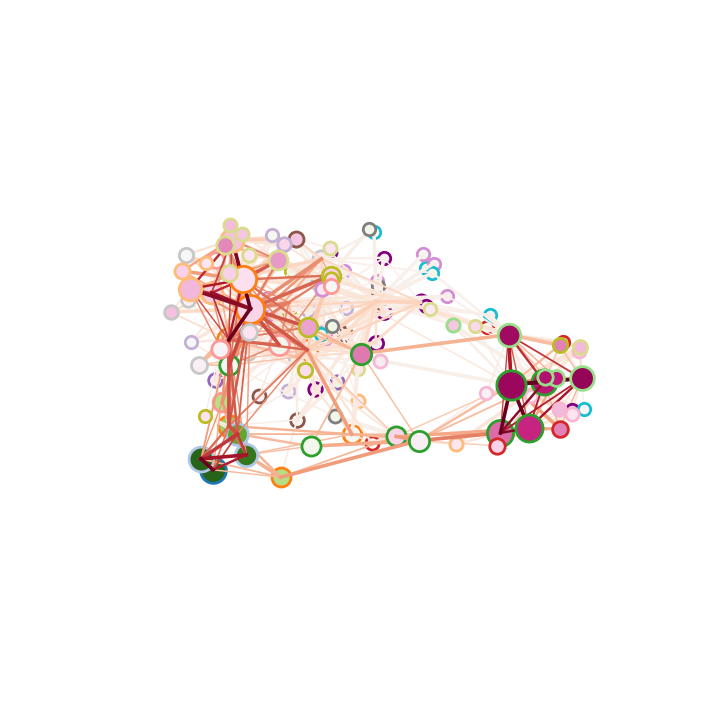

In [461]:

ax.view_init(elev=10, azim=90, roll=200)  # Adjust the elevation and azimuthal angle for better visibility
fig

similarity metric  subject_i  subject_j  roi_x  roi_y  shift  \
0          1.000000    rsa          1          1      1      1      0   
1          0.090013    rsa          1          1      1      2      0   
2          0.219608    rsa          1          1      1      3      0   
3          0.829790    rsa          1          1      1      4      0   
4          0.753486    rsa          1          1      1      5      0   
...             ...    ...        ...        ...    ...    ...    ...   
2073595    0.140462    rsa          8          8    180    176      0   
2073596    0.171002    rsa          8          8    180    177      0   
2073597    0.259336    rsa          8          8    180    178      0   
2073598    0.538102    rsa          8          8    180    179      0   
2073599    1.000000    rsa          8          8    180    180      0   

         join_hemispheres  
0                    True  
1                    True  
2                    True  
3                    True  
4                    True  
...                   ...  
2073595              True  
2073596              True  
2073597              True  
2073598              True  
2073599              True  

[2073600 rows x 8 columns]

similarity metric  subject_i  subject_j  roi_x  roi_y  shift  \
0          0.344380    rsa          1          1      1      1      1   
1         -0.037459    rsa          1          1      1      2      1   
2          0.044941    rsa          1          1      1      3      1   
3          0.321830    rsa          1          1      1      4      1   
4          0.272379    rsa          1          1      1      5      1   
...             ...    ...        ...        ...    ...    ...    ...   
2073595    0.003031    rsa          8          8    180    176      1   
2073596    0.001384    rsa          8          8    180    177      1   
2073597   -0.001194    rsa          8          8    180    178      1   
2073598    0.002186    rsa          8          8    180    179      1   
2073599    0.000894    rsa          8          8    180    180      1   

         join_hemispheres  
0                    True  
1                    True  
2                    True  
3                    True  
4                    True  
...                   ...  
2073595              True  
2073596              True  
2073597              True  
2073598              True  
2073599              True  

[2073600 rows x 8 columns]

similarity metric  subject_i  subject_j  roi_x  roi_y  shift  \
0          1.000000    rsa          1          1      1      1      0   
1          0.090013    rsa          1          1      1      2      0   
2          0.219608    rsa          1          1      1      3      0   
3          0.829790    rsa          1          1      1      4      0   
4          0.753486    rsa          1          1      1      5      0   
...             ...    ...        ...        ...    ...    ...    ...   
2073595    0.140462    rsa          8          8    180    176      0   
2073596    0.171002    rsa          8          8    180    177      0   
2073597    0.259336    rsa          8          8    180    178      0   
2073598    0.538102    rsa          8          8    180    179      0   
2073599    1.000000    rsa          8          8    180    180      0   

         join_hemispheres  
0                    True  
1                    True  
2                    True  
3                    True  
4                    True  
...                   ...  
2073595              True  
2073596              True  
2073597              True  
2073598              True  
2073599              True  

[2073600 rows x 8 columns]

similarity metric  subject_i  subject_j  roi_x  roi_y  shift  \
0          0.344380    rsa          1          1      1      1      1   
1         -0.037459    rsa          1          1      1      2      1   
2          0.044941    rsa          1          1      1      3      1   
3          0.321830    rsa          1          1      1      4      1   
4          0.272379    rsa          1          1      1      5      1   
...             ...    ...        ...        ...    ...    ...    ...   
2073595    0.003031    rsa          8          8    180    176      1   
2073596    0.001384    rsa          8          8    180    177      1   
2073597   -0.001194    rsa          8          8    180    178      1   
2073598    0.002186    rsa          8          8    180    179      1   
2073599    0.000894    rsa          8          8    180    180      1   

         join_hemispheres  
0                    True  
1                    True  
2                    True  
3                    True  
4                    True  
...                   ...  
2073595              True  
2073596              True  
2073597              True  
2073598              True  
2073599              True  

[2073600 rows x 8 columns]

Text(0.5, 1.0, 'Inter-subject (shifted)')

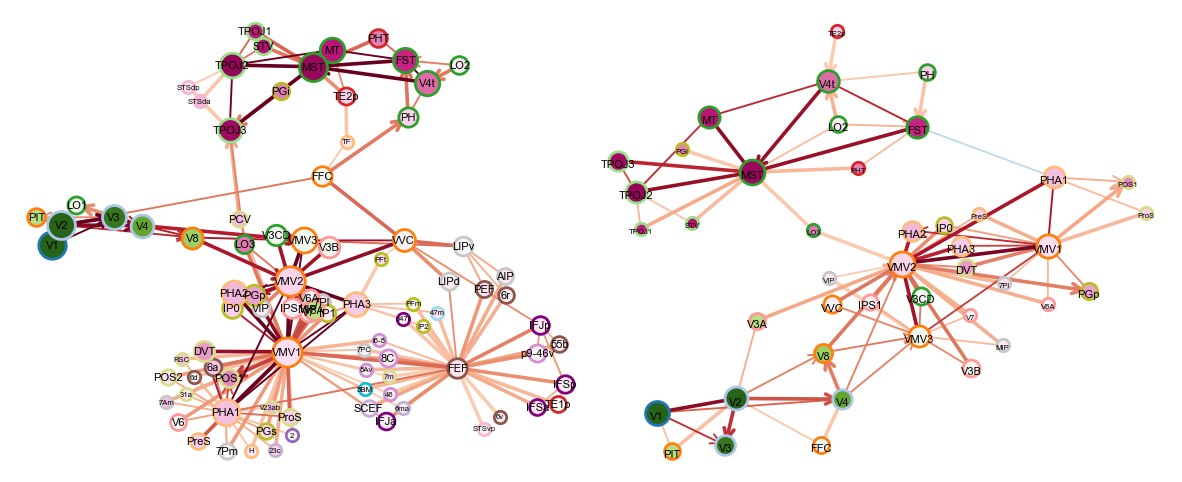

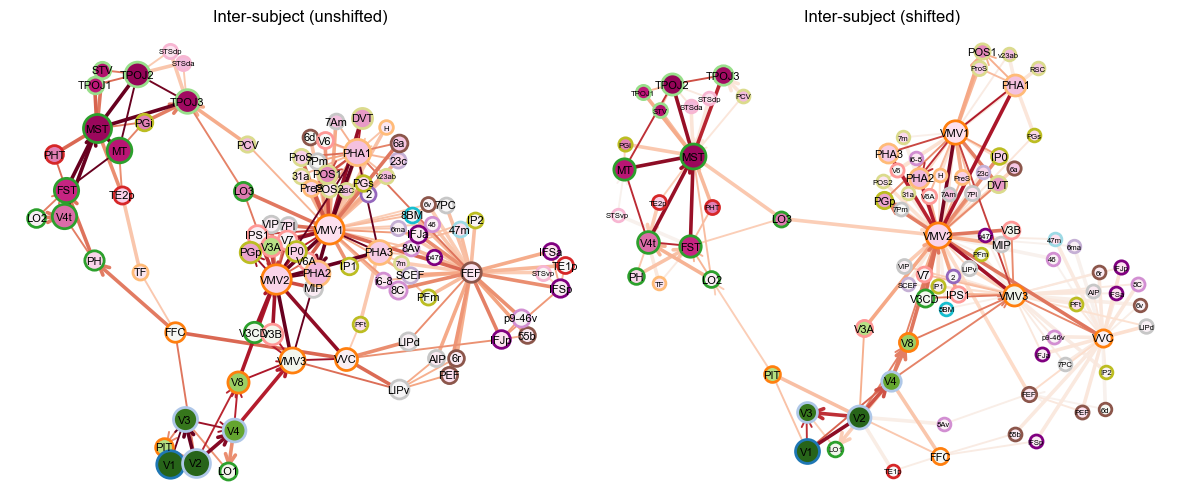

In [588]:
import networkx as nx



#1#df_nodes.abs_similarity.min() # 
vmin, vmax = -0.2, 0.2
seed = 5
num_trees = 2
threshold_rois = False

for threshold_rois in [True, False]: # Change ratios of axis columns plots to 1,1,0.3
    fig, axes = plt.subplots(1, 2, figsize=(10*1.5, 4*1.5), gridspec_kw={"wspace": 0}) 
    if threshold_rois:
        unique_rois = []
        threshold = 0.05
    else:
        threshold = 0
        
    for ax, shift in zip(axes,  (0, 1)):
        #df_cross_subject = load_filename("cross_subject", shift=1, joined=True)
        filename_shift_0 = data_folder / f"nsd_cross_subject_shift_{shift}_rsa_joined.parquet"
        df_cross_subject = pd.read_parquet(filename_shift_0).rename(columns={"score": "similarity"})
        display(df_cross_subject)
        df_cross_subject = df_cross_subject.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

        p_values_subject = pd.read_parquet(pvalues_filename).query("comparison=='intersubject'")

        rois_significant = p_values_subject[p_values_subject.pvalue_fdr_bh < 0.05].roi


        hcp = pd.read_csv(hcp_filename).query("roi <= 180")
        #top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(30).roi_x.tolist()
        
        
        top_rois = hcp.query("roi in @rois_significant").roi.tolist()
        # print("significant rois", len(top_rois))
        top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
        df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
        df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
        df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
        df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

        # Threshold
        if not threshold_rois:    
            df_cross_subject_top = df_cross_subject_top.query("roi_x in @unique_rois and roi_y in @unique_rois").copy()
            df_nodes = df_cross_subject_top.query("roi_x == roi_y").copy().rename(columns={"similarity": "score"})
        else:
            df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
            unique_r = list(set(list(df_cross_subject_top.roi_x.astype(int).unique()) + list(df_cross_subject_top.roi_y.astype(int).unique())))
            unique_r = [int(r) for r in unique_r if r in top_rois]
            unique_rois = list(set(unique_rois + unique_r))
        
            df_nodes = df_cross_subject_top.query("roi_x == roi_y and abs_similarity > @threshold").copy().rename(columns={"similarity": "score"})
        df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
        df_edges["weight"] = (1 - df_edges.score)*100
        areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
        colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

        node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


        G = nx.from_pandas_edgelist(
            df_edges,
            source="name_x",
            target="name_y",
            edge_attr=["score", "weight"],
            create_using=nx.Graph(),
        )

        spanning_tree = efficient_iterative_max_spanning_trees(G, num_trees=num_trees, similarity_attr="score")
        plotting_graph = spanning_tree
        
        def layout_callback(graph_to_plot):
            layout = nx.forceatlas2_layout(graph_to_plot,  seed=seed, weight="weight", dim=2, gravity=10)
            if shift == 1:
                layout["V1"], layout["V3"] = layout["V3"], layout["V1"]
            if shift == 0:
                layout["V2"], layout["V3"] = layout["V3"], layout["V2"]
            return layout

        df_depths_grouped = df_depths.groupby("roi").vision_depth.mean().reset_index()
        df_depths_grouped = df_depths_grouped.merge(hcp[["roi", "name"]], on="roi")
        df_depths_grouped = df_depths_grouped.set_index("name")

        fig, ax = plot_graph(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, iteration_multiplier=0.9, layout_callback=layout_callback,
                            node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
                            default_cmap_name="RdBu_r", ax=ax, node_label_dy_offset=-1, df_depths_grouped=df_depths_grouped,
                            node_label_fontsize=8)
                    


        # Flip y axis


    #axes[1].invert_yaxis()

axes[0].set_title("Inter-subject (unshifted)")
axes[1].set_title("Inter-subject (shifted)")

#fig.savefig(output / "connectivity_graph_shifting_comparison.pdf", bbox_inches="tight", transparent=True)
    #fig.savefig(output / f"connectivity_graph_nsd_depth_full_{num_trees}_shift_1.pdf", bbox_inches="tight", dpi=300, transparent=True)


['TPOJ2', 'MT', 'MST', 'FST', 'V4t', 'TPOJ3', 'PH', 'FFC', 'LO1', 'PIT', 'LO2', 'LO3', 'DVT', 'PGp', 'IP0', 'PHA3', 'PHA2', 'PHA1', 'VMV1', 'VMV2', 'VMV3', 'VVC', 'V3CD', 'V3B', 'V3A', 'V8', 'V4', 'V3', 'V2', 'V1']


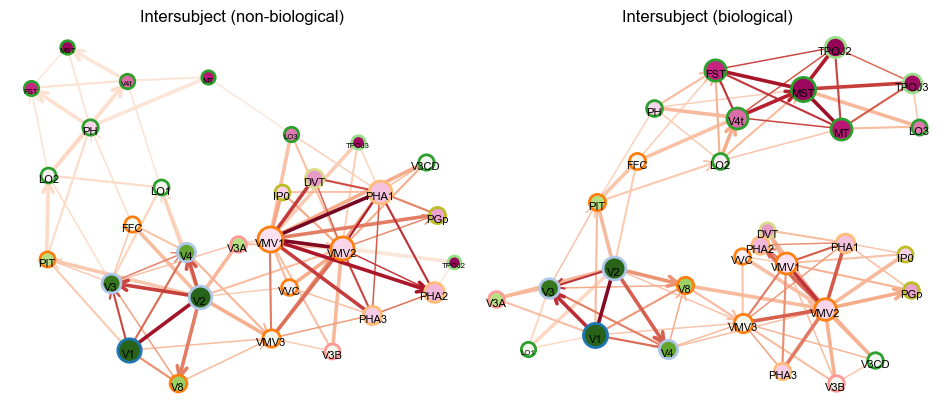

In [599]:
import networkx as nx



#1#df_nodes.abs_similarity.min() # 
vmin, vmax = -0.2, 0.2
seed = 6
num_trees = 3
threshold_rois = False

for i, threshold_rois in enumerate([True, False]): # Change ratios of axis columns plots to 1,1,0.3
    fig, axes = plt.subplots(1, 2, figsize=(10*1.2, 4*1.2), gridspec_kw={"wspace": 0}) 
    if threshold_rois:
        #unique_rois = []
        print(order3)
        unique_rois = hcp[hcp.name.isin(order3)].query("roi <= 180").roi.tolist()
        plt.close(fig)
        continue
        threshold = 0.00
    else:
        threshold = 0

    for ax, shift in zip(axes,  (0, 1)):
        filename_shift_0 = "/Users/pablomm/Desktop/derivatives/subject_subject_rsa_optimized_partitions.parquet"
        subset = "animate" if shift == 1 else "inanimate"
        df_cross_subject = pd.read_parquet(filename_shift_0).query("subset == @subset")
        # display(df_cross_subject)
        df_cross_subject = df_cross_subject.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

        p_values_subject = pd.read_parquet(pvalues_filename).query("comparison=='intersubject'")

        rois_significant = p_values_subject[p_values_subject.pvalue_fdr_bh < 0.05].roi


        hcp = pd.read_csv(hcp_filename).query("roi <= 180")
        #top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(30).roi_x.tolist()
        
        
        top_rois = hcp.query("roi in @rois_significant").roi.tolist()
        # print("significant rois", len(top_rois))
        top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
        df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
        df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
        df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
        df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

        # Threshold
        if not threshold_rois:    
            df_cross_subject_top = df_cross_subject_top.query("roi_x in @unique_rois and roi_y in @unique_rois").copy()
            df_nodes = df_cross_subject_top.query("roi_x == roi_y").copy().rename(columns={"similarity": "score"})
        else:
            df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
            unique_r = list(set(list(df_cross_subject_top.roi_x.astype(int).unique()) + list(df_cross_subject_top.roi_y.astype(int).unique())))
            unique_r = [int(r) for r in unique_r if r in top_rois]
            unique_rois = list(set(unique_rois + unique_r))
        
            df_nodes = df_cross_subject_top.query("roi_x == roi_y and abs_similarity > @threshold").copy().rename(columns={"similarity": "score"})
        df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
        df_edges["weight"] = (1 - df_edges.score)*100
        areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
        colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

        node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


        G = nx.from_pandas_edgelist(
            df_edges,
            source="name_x",
            target="name_y",
            edge_attr=["score", "weight"],
            create_using=nx.Graph(),
        )

        spanning_tree = efficient_iterative_max_spanning_trees(G, num_trees=num_trees, similarity_attr="score")
        plotting_graph = spanning_tree
        
        def layout_callback(graph_to_plot):
            layout = nx.forceatlas2_layout(graph_to_plot,  seed=seed, weight="weight", dim=2, gravity=10)
            # if shift == 1:
            #     layout["V1"], layout["V3"] = layout["V3"], layout["V1"]
            # if shift == 0:
            #     layout["V2"], layout["V3"] = layout["V3"], layout["V2"]
            return layout

        df_depths_grouped = df_depths.groupby("roi").vision_depth.mean().reset_index()
        df_depths_grouped = df_depths_grouped.merge(hcp[["roi", "name"]], on="roi")
        df_depths_grouped = df_depths_grouped.set_index("name")

        if i != 0:
            fig, ax = plot_graph(plotting_graph, df_nodes, df_edges, hcp, df_depths_info_arg=df_depths_cross_selected, vmin_custom=vmin, vmax_custom=vmax, iteration_multiplier=0.7, layout_callback=layout_callback,
                                node_edge_linewidth=2, node_color="depth", default_cmap_node="PiYG_r",
                                default_cmap_name="RdBu_r", ax=ax, node_label_dy_offset=-1, df_depths_grouped=df_depths_grouped,
                                node_label_fontsize=8)
        else:
            plt.close(fig)       
        

        # Flip y axis


    #axes[1].invert_yaxis()

axes[1].set_title("Intersubject (biological)")
axes[0].set_title("Intersubject (non-biological)")
axes[0].invert_xaxis()
axes[1].invert_xaxis()
fig.savefig(output / "connectivity_graph_biological_split_graph.pdf", bbox_inches="tight", transparent=True)
    #fig.savefig(output / f"connectivity_graph_nsd_depth_full_{num_trees}_shift_1.pdf", bbox_inches="tight", dpi=300, transparent=True)

#fig.savefig(output / "connectivity_graph_shifting_comparison.pdf", bbox_inches="tight", transparent=True)
    #fig.savefig(output / f"connectivity_graph_nsd_depth_full_{num_trees}_shift_1.pdf", bbox_inches="tight", dpi=300, transparent=True)


roi_x  roi_y  similarity  subject_i  subject_j  join_hemispheres  \
0            1      1    0.327874          1          1              True   
1            1      2   -0.052133          1          1              True   
2            1      3    0.049220          1          1              True   
3            1      4    0.312493          1          1              True   
4            1      5    0.268636          1          1              True   
...        ...    ...         ...        ...        ...               ...   
4147195    180    176    0.012363          8          8              True   
4147196    180    177    0.006145          8          8              True   
4147197    180    178   -0.005040          8          8              True   
4147198    180    179    0.001732          8          8              True   
4147199    180    180    0.000214          8          8              True   

         rep_shift     subset  
0                1    animate  
1                1    animate  
2                1    animate  
3                1    animate  
4                1    animate  
...            ...        ...  
4147195          1  inanimate  
4147196          1  inanimate  
4147197          1  inanimate  
4147198          1  inanimate  
4147199          1  inanimate  

[4147200 rows x 8 columns]

In [493]:
# df_cross_subject_cross_0 = df_cross_subject.copy()
df_shift1 = df_cross_subject.query("roi_x == roi_y").similarity

df_shift0 = df_cross_subject_cross_0.query("roi_x == roi_y").similarity

spearmanr(df_shift0, df_shift1)

SignificanceResult(statistic=np.float64(0.957762070845808), pvalue=np.float64(2.8106722376115112e-98))

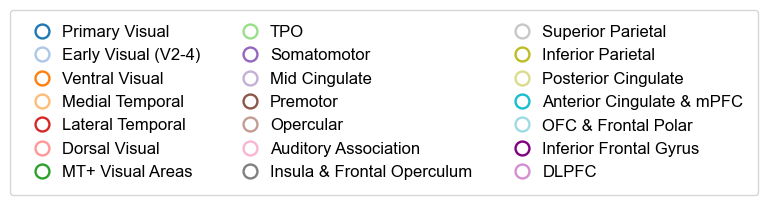

In [119]:
df_areas_to_legend = hcp[hcp.roi.isin(df_nodes.roi_x.unique())][["area", "area_id", "area_color"]].drop_duplicates().sort_values("area_id")
areas_to_legend = df_areas_to_legend.reset_index(drop=True).set_index("area").drop(columns=["area_id"]).to_dict(orient="index")

fig, ax = plt.subplots(figsize=(2, 1))
ax.axis("off")
# Use labels and handles
handles = []
labels = []
for area, color in areas_to_legend.items():
    color = color["area_color"]
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor="white", markersize=10, markeredgecolor=color, markeredgewidth=1.7))
    labels.append(area)

# Add space between labels and the right side
ax.legend(handles=handles, labels=labels, loc='center', fontsize=12, ncol=3, borderpad=0.9, handletextpad=0.2)

fig.savefig(output / "connectivity_graph_nsd_depth_full_legend.pdf", bbox_inches="tight", dpi=300, transparent=True);

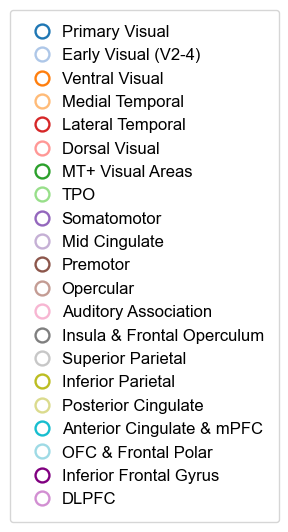

In [122]:
df_areas_to_legend = hcp[hcp.roi.isin(df_nodes.roi_x.unique())][["area", "area_id", "area_color"]].drop_duplicates().sort_values("area_id")
areas_to_legend = df_areas_to_legend.reset_index(drop=True).set_index("area").drop(columns=["area_id"]).to_dict(orient="index")

fig, ax = plt.subplots(figsize=(2, 1))
ax.axis("off")
# Use labels and handles
handles = []
labels = []
for area, color in areas_to_legend.items():
    color = color["area_color"]
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor="white", markersize=10, markeredgecolor=color, markeredgewidth=1.7))
    labels.append(area)

# Add space between labels and the right side
ax.legend(handles=handles, labels=labels, loc='center', fontsize=12, ncol=1, borderpad=0.9, handletextpad=0.2)

fig.savefig(output / "connectivity_graph_nsd_depth_full_legend_1.pdf", bbox_inches="tight", dpi=300, transparent=True);

In [ ]:
colors = {'Primary Visual': '#1f77b4',
 'Early Visual (V2-4)': '#aec7e8',
 'Ventral Visual': '#ff7f0e',
'Medial Temporal': '#ffbb78',
 'Dorsal Visual': '#ff9896',
 "Inferior Parietal": '#bcbd22',
 'MT+ Visual Areas': '#2ca02c',
 'TPO': '#98df8a'}

# Make a legend with the areas (white circle, edge color)
fig, ax = plt.subplots(figsize=(2, 1))
ax.axis("off")
# Use labels and handles
handles = []
labels = []
for area, color in colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor="white", markersize=10, markeredgecolor=color))
    labels.append(area)

# Add space between labels and the right side
ax.legend(handles=handles, labels=labels, loc='center', fontsize=12, ncol=2, borderpad=0.9, handletextpad=0.2)
fig.savefig(output / "legend_areas_connectivity.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [278]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# --- Assume 'plot_connection' is defined elsewhere by the user ---
# def plot_connection(start_pos, end_pos, ax, color, alpha, linewidth, zorder,
#                     direction="-", arrow_size=18, **kwargs):
#     # User's custom implementation for drawing edges/arrows
#     pass

# --- Main plotting function ---
def plot_graph(
    graph_to_plot: nx.Graph,
    df_nodes_arg: pd.DataFrame,      # Original df_nodes for node scores
    df_edges_arg: pd.DataFrame,      # Original df_edges for HCP filtering scope
    hcp_arg: pd.DataFrame,           # Original hcp DataFrame
    df_depths_info_arg: pd.DataFrame = None, # Original df_depths_merged_joined
    # Optional custom vmin/vmax for normalization
    vmin_custom: float = None,
    vmax_custom: float = None,
    # Optional general plotting parameters (can be expanded)
    ax: plt.Axes = None,
    figsize: tuple = (6, 8),
    figure_title: str = None,
    # Layout parameters (defaults from original snippet)
    layout_seed: int = 6,
    layout_iterations: int = 100,
    layout_scale: float = 0.5,
    layout_weight_attr: str = 'weight', # Edge attr for spring layout
    # Node plotting parameters (defaults from original snippet)
    node_size_base: float = 5.0,
    node_size_multiplier: float = 300.0,
    node_label_fontsize: int = 10,
    node_label_dy_offset: float = 0.02,
    node_edge_linewidth: float = 1.5,
    # Edge plotting parameters (defaults from original snippet)
    edge_lw_base: float = 1.0,
    edge_lw_multiplier: float = 2.0,
    arrow_size: int = 18,
    # Colormap and Normalization (internal defaults, can be made params)
    default_cmap_name: str = 'PuOr_r',
    default_node_color: str = 'grey',
    default_area_color: str = 'lightgrey',
    default_edge_color: str = 'grey',
    default_cmap_node: str = None,
    iteration_multiplier: int = 1, # Used to adjust edge width based on iteration
    layout_callback = None,  # Optional callback for custom layout logic
    node_color="similarity",
    df_depths_grouped=None,
    variant=None,
):
    """
    Plots a network graph, deriving necessary attributes from input DataFrames
    to match the user's original notebook cell logic.
    Allows custom vmin and vmax for color normalization.
    """

    if ax is None:
        fig, current_ax = plt.subplots(figsize=figsize)
    else:
        current_ax = ax
        fig = current_ax.figure

    current_ax.axis("off")
    if figure_title:
        current_ax.set_title(figure_title)

    if graph_to_plot.number_of_nodes() == 0:
        return fig, current_ax

    # 1. Derive node_score_map from df_nodes_arg
    try:
        node_score_map = df_nodes_arg.set_index("name_x")[["score"]].to_dict(orient="index")
    except KeyError:
        node_score_map = {}

    default_cmap_node = default_cmap_node or default_cmap_name
    # 2. Derive node_to_area_direct_map and area_to_color_direct_map
    relevant_node_names_for_hcp = pd.unique(df_edges_arg[['name_x', 'name_y']].values.ravel('K'))
    hcp_filtered = hcp_arg[hcp_arg['name'].isin(relevant_node_names_for_hcp)]

    node_to_area_direct_map = hcp_filtered.drop_duplicates(subset=['name']).set_index('name')['area'].to_dict()
    area_to_color_direct_map = hcp_filtered.drop_duplicates(subset=['area']).set_index('area')['area_color'].to_dict()

    # 3. Define norm_func and cmap
    node_scores_list = [data.get('score', 0) for data in node_score_map.values()]
    edge_scores_list = [data.get('score', 0) for _, _, data in graph_to_plot.edges(data=True)]

    all_scores_for_norm = node_scores_list + edge_scores_list
    
    # Determine vmin and vmax
    if vmin_custom is not None:
        vmin = vmin_custom
    elif all_scores_for_norm:
        vmin = min(all_scores_for_norm)
    else:
        vmin = 0.0

    if vmax_custom is not None:
        vmax = vmax_custom
    elif all_scores_for_norm:
        vmax = max(all_scores_for_norm)
    else:
        vmax = 1.0
    
    if vmin == vmax: # Avoid error in Normalize if all scores are the same or only one value
        vmin = vmin - 0.5 if vmin != 0 else -0.5
        vmax = vmax + 0.5 if vmax != 0 else 0.5
        if vmin == vmax: # Final fallback if still identical (e.g. vmin_custom = vmax_custom = 0)
             vmin, vmax = 0.0, 1.0

    norm_func = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(default_cmap_name)
    cmap_node = plt.get_cmap(default_cmap_node) if default_cmap_node else cmap
    norm_func_node = mcolors.Normalize(vmin=0.2, vmax=0.8)
    

    # Calculate layout
    effective_weight_attr = None
    if graph_to_plot.number_of_edges() > 0:
        # Check if the first edge has the weight attribute
        first_edge_data = next(iter(graph_to_plot.edges(data=True)))[2]
        if layout_weight_attr in first_edge_data:
            effective_weight_attr = layout_weight_attr
    
    if layout_callback is None:
        layout = nx.spring_layout(
            graph_to_plot, dim=2, weight=effective_weight_attr, center=(0, 0),
            iterations=layout_iterations, seed=layout_seed, scale=layout_scale
        )
    else:
        layout = layout_callback(graph_to_plot)
    # layout = nx.kamada_kawai_layout(
        # graph_to_plot, dim=2, weight=effective_weight_attr, center=(0, 0))

    # Plot nodes
    for node_name, (x, y) in layout.items():
        node_data = node_score_map.get(node_name)
        score = node_data.get("score", 0.0) if node_data else 0.0

        norm_score = norm_func(score)
        node_s = node_size_base + node_size_multiplier * (norm_score**2)
        if node_color != "similarity":
            v = df_depths_grouped.loc[node_name]["vision_depth"]
            node_display_color = cmap_node(norm_func_node(v))
        else:
            node_display_color = cmap_node(norm_score)

        area_name = node_to_area_direct_map.get(node_name, "Unknown Area")
        node_border_color = area_to_color_direct_map.get(area_name, default_area_color)
        if variant == "area":
            
            node_border_color = hcp_arg.query("area == @node_name").area_color.values[0] #if area_name in hcp_arg.area.values else default_area_color
            
        current_ax.scatter(
            x, y, s=node_s, color=node_display_color, alpha=1,
            zorder=int(500 + 300 * norm_score),
            edgecolors=node_border_color, linewidths=node_edge_linewidth, marker="o",
        )
        # node_label_fontsize_node = node_label_fontsize
        coef = 0.7
        node_label_fontsize_node = node_label_fontsize if norm_score > 0.6 else coef * node_label_fontsize
        node_label_dy_offset_node = node_label_dy_offset if norm_score > 0.6 else coef * node_label_dy_offset
        current_ax.text(x, y + node_label_dy_offset_node, node_name,
                        fontsize=node_label_fontsize_node, ha="center", zorder=1000)

    # Plot edges
    for node1, node2, edge_data in graph_to_plot.edges(data=True):
        start_pos = layout[node1]
        end_pos = layout[node2]
        edge_score = edge_data.get("score", 0.0)
        iteration_added = edge_data.get('iteration_added', 1)

        norm_edge_score = norm_func(edge_score)
        # lw = (edge_lw_base + edge_lw_multiplier * norm_edge_score) / (1+iteration_multiplier*(iteration_added-1))
        lw = (edge_lw_base+edge_lw_multiplier*0.8) / (1+iteration_multiplier*(iteration_added-1)) # Patch
        edge_color = cmap(norm_edge_score)
        direction = "-"

        if variant == "area":
            depth1 = df_depths_grouped.loc[node1]["vision_depth"]
            depth2 = df_depths_grouped.loc[node2]["vision_depth"]
            diff_depth = depth2 - depth1
            threshold_depth = 0.05  # Threshold for depth difference to determine direction
            if diff_depth < threshold_depth:
                direction = "<-"
            elif diff_depth > threshold_depth:
                direction = "->"

        elif df_depths_info_arg is not None:
            row_found = False
            row = df_depths_info_arg.query("name_x == @node1 and name_y == @node2")
            t_stat_sign = 1
            if not row.empty:
                row_found = True
            else:
                row = df_depths_info_arg.query("name_x == @node2 and name_y == @node1")
                t_stat_sign = -1
                if not row.empty:
                    row_found = True
                else:
                    pass #print("HEUYEHEHEHEHE")
            
            if row_found:
                entry = row.iloc[0]
                p_corrected = entry["p_value_corrected"]
                t_test = entry["t_stat"] * t_stat_sign
                
                if p_corrected <= 0.05:
                    if t_test < 0: direction = "->"
                    elif t_test > 0: direction = "<-"
            

        plot_connection(
            start_pos, end_pos, current_ax,
            color=edge_color, alpha=1, linewidth=lw,
            zorder=int(norm_edge_score * 100),
            direction=direction, arrow_size=arrow_size
        )
        
    return fig, current_ax

In [447]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# --- Assume 'plot_connection' is defined elsewhere by the user ---
# def plot_connection(start_pos, end_pos, ax, color, alpha, linewidth, zorder,
#                     direction="-", arrow_size=18, **kwargs):
#     # User's custom implementation for drawing edges/arrows
#     pass

# --- Main plotting function ---
def plot_graph_3d(
    graph_to_plot: nx.Graph,
    df_nodes_arg: pd.DataFrame,      # Original df_nodes for node scores
    df_edges_arg: pd.DataFrame,      # Original df_edges for HCP filtering scope
    hcp_arg: pd.DataFrame,           # Original hcp DataFrame
    df_depths_info_arg: pd.DataFrame = None, # Original df_depths_merged_joined
    # Optional custom vmin/vmax for normalization
    vmin_custom: float = None,
    vmax_custom: float = None,
    # Optional general plotting parameters (can be expanded)
    ax: plt.Axes = None,
    figsize: tuple = (6, 8),
    figure_title: str = None,
    # Layout parameters (defaults from original snippet)
    layout_seed: int = 6,
    layout_iterations: int = 100,
    layout_scale: float = 0.5,
    layout_weight_attr: str = 'weight', # Edge attr for spring layout
    # Node plotting parameters (defaults from original snippet)
    node_size_base: float = 5.0,
    node_size_multiplier: float = 300.0,
    node_label_fontsize: int = 10,
    node_label_dy_offset: float = 0.02,
    node_edge_linewidth: float = 1.5,
    # Edge plotting parameters (defaults from original snippet)
    edge_lw_base: float = 1.0,
    edge_lw_multiplier: float = 2.0,
    arrow_size: int = 18,
    # Colormap and Normalization (internal defaults, can be made params)
    default_cmap_name: str = 'PuOr_r',
    default_node_color: str = 'grey',
    default_area_color: str = 'lightgrey',
    default_edge_color: str = 'grey',
    default_cmap_node: str = None,
    iteration_multiplier: int = 1, # Used to adjust edge width based on iteration
    layout_callback = None,  # Optional callback for custom layout logic
    node_color="similarity",
    df_depths_grouped=None,
    variant=None,
):
    """
    Plots a network graph, deriving necessary attributes from input DataFrames
    to match the user's original notebook cell logic.
    Allows custom vmin and vmax for color normalization.
    """

    if ax is None:
        # Generate a 3d axis
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=figsize)
        current_ax = fig.add_subplot(111, projection='3d')
        #fig, current_ax = plt.subplots(figsize=figsize)

    else:
        current_ax = ax
        fig = current_ax.figure

    current_ax.axis("off")
    if figure_title:
        current_ax.set_title(figure_title)

    if graph_to_plot.number_of_nodes() == 0:
        return fig, current_ax

    # 1. Derive node_score_map from df_nodes_arg
    try:
        node_score_map = df_nodes_arg.set_index("name_x")[["score"]].to_dict(orient="index")
    except KeyError:
        node_score_map = {}

    default_cmap_node = default_cmap_node or default_cmap_name
    # 2. Derive node_to_area_direct_map and area_to_color_direct_map
    relevant_node_names_for_hcp = pd.unique(df_edges_arg[['name_x', 'name_y']].values.ravel('K'))
    hcp_filtered = hcp_arg[hcp_arg['name'].isin(relevant_node_names_for_hcp)]

    node_to_area_direct_map = hcp_filtered.drop_duplicates(subset=['name']).set_index('name')['area'].to_dict()
    area_to_color_direct_map = hcp_filtered.drop_duplicates(subset=['area']).set_index('area')['area_color'].to_dict()

    # 3. Define norm_func and cmap
    node_scores_list = [data.get('score', 0) for data in node_score_map.values()]
    edge_scores_list = [data.get('score', 0) for _, _, data in graph_to_plot.edges(data=True)]

    all_scores_for_norm = node_scores_list + edge_scores_list
    
    # Determine vmin and vmax
    if vmin_custom is not None:
        vmin = vmin_custom
    elif all_scores_for_norm:
        vmin = min(all_scores_for_norm)
    else:
        vmin = 0.0

    if vmax_custom is not None:
        vmax = vmax_custom
    elif all_scores_for_norm:
        vmax = max(all_scores_for_norm)
    else:
        vmax = 1.0
    
    if vmin == vmax: # Avoid error in Normalize if all scores are the same or only one value
        vmin = vmin - 0.5 if vmin != 0 else -0.5
        vmax = vmax + 0.5 if vmax != 0 else 0.5
        if vmin == vmax: # Final fallback if still identical (e.g. vmin_custom = vmax_custom = 0)
             vmin, vmax = 0.0, 1.0

    norm_func = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(default_cmap_name)
    cmap_node = plt.get_cmap(default_cmap_node) if default_cmap_node else cmap
    norm_func_node = mcolors.Normalize(vmin=0.2, vmax=0.8)
    

    # Calculate layout
    effective_weight_attr = None
    if graph_to_plot.number_of_edges() > 0:
        # Check if the first edge has the weight attribute
        first_edge_data = next(iter(graph_to_plot.edges(data=True)))[2]
        if layout_weight_attr in first_edge_data:
            effective_weight_attr = layout_weight_attr
    
    if layout_callback is None:
        layout = nx.spring_layout(
            graph_to_plot, dim=2, weight=effective_weight_attr, center=(0, 0),
            iterations=layout_iterations, seed=layout_seed, scale=layout_scale
        )
    else:
        layout = layout_callback(graph_to_plot)
    # layout = nx.kamada_kawai_layout(
        # graph_to_plot, dim=2, weight=effective_weight_attr, center=(0, 0))

    # Plot nodes
    for node_name, (x, y, z) in layout.items():
        node_data = node_score_map.get(node_name)
        score = node_data.get("score", 0.0) if node_data else 0.0

        norm_score = norm_func(score)
        node_s = node_size_base + node_size_multiplier * (norm_score**2)
        if node_color != "similarity":
            v = df_depths_grouped.loc[node_name]["vision_depth"]
            node_display_color = cmap_node(norm_func_node(v))
        else:
            node_display_color = cmap_node(norm_score)

        area_name = node_to_area_direct_map.get(node_name, "Unknown Area")
        node_border_color = area_to_color_direct_map.get(area_name, default_area_color)
        if variant == "area":
            
            node_border_color = hcp_arg.query("area == @node_name").area_color.values[0] #if area_name in hcp_arg.area.values else default_area_color
            
        current_ax.scatter(
            x, y,z, s=node_s, color=node_display_color, alpha=1,
            zorder=int(500 + 300 * norm_score),
            edgecolors=node_border_color, linewidths=node_edge_linewidth, marker="o",
        )
        # node_label_fontsize_node = node_label_fontsize
        coef = 0.7
        node_label_fontsize_node = node_label_fontsize if norm_score > 0.6 else coef * node_label_fontsize
        node_label_dy_offset_node = node_label_dy_offset if norm_score > 0.6 else coef * node_label_dy_offset
        #current_ax.text(x, y + node_label_dy_offset_node, z, node_name,
        #                fontsize=node_label_fontsize_node, ha="center", zorder=1000)

    # Plot edges
    for node1, node2, edge_data in graph_to_plot.edges(data=True):
        start_pos = layout[node1]
        end_pos = layout[node2]
        edge_score = edge_data.get("score", 0.0)
        iteration_added = edge_data.get('iteration_added', 1)

        norm_edge_score = norm_func(edge_score)
        # lw = (edge_lw_base + edge_lw_multiplier * norm_edge_score) / (1+iteration_multiplier*(iteration_added-1))
        lw = (edge_lw_base+edge_lw_multiplier*0.8) / (1+iteration_multiplier*(iteration_added-1)) # Patch
        edge_color = cmap(norm_edge_score)
        direction = "-"

        if variant == "area":
            depth1 = df_depths_grouped.loc[node1]["vision_depth"]
            depth2 = df_depths_grouped.loc[node2]["vision_depth"]
            diff_depth = depth2 - depth1
            threshold_depth = 0.05  # Threshold for depth difference to determine direction
            if diff_depth < threshold_depth:
                direction = "<-"
            elif diff_depth > threshold_depth:
                direction = "->"

        elif df_depths_info_arg is not None:
            row_found = False
            row = df_depths_info_arg.query("name_x == @node1 and name_y == @node2")
            t_stat_sign = 1
            if not row.empty:
                row_found = True
            else:
                row = df_depths_info_arg.query("name_x == @node2 and name_y == @node1")
                t_stat_sign = -1
                if not row.empty:
                    row_found = True
                else:
                    pass #print("HEUYEHEHEHEHE")
            
            if row_found:
                entry = row.iloc[0]
                p_corrected = entry["p_value_corrected"]
                t_test = entry["t_stat"] * t_stat_sign
                
                if p_corrected <= 0.05:
                    if t_test < 0: direction = "->"
                    elif t_test > 0: direction = "<-"
            

        current_ax.plot(
            [start_pos[0], end_pos[0]], 
            [start_pos[1], end_pos[1]], 
            zs=[start_pos[2], end_pos[2]],
            color=edge_color, alpha=1, linewidth=lw,
            zorder=int(norm_edge_score * 100),
        )
        # plot_connection(
        #     start_pos, end_pos, current_ax,
        #     color=edge_color, alpha=1, linewidth=lw,
        #     zorder=int(norm_edge_score * 100),
        #     direction=direction, arrow_size=arrow_size
        # )
        
    return fig, current_ax

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # For Normalize and Colormap
import numpy as np # For placeholder plot_connection, spring_layout uses it too


In [ ]:
import networkx as nx
df_cross_subject = load_filename("cross_subject", shift=1, joined=True)
df_cross_subject = df_cross_subject.query("subject_i != subject_j").groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

hcp = pd.read_csv(hcp_filename)
top_rois = df_cross_subject.query("roi_x == roi_y").sort_values("similarity", ascending=False).head(20).roi_x.tolist()
top_names = hcp.query("roi in @top_rois").drop_duplicates("roi").sort_values("roi_order")[["roi", "name"]].set_index("roi").to_dict()["name"]
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_x"}), left_on="roi_x", right_on="roi").drop(columns=["roi"])
df_cross_subject = df_cross_subject.merge(hcp[["roi", "name"]].rename(columns={"name": "name_y"}), left_on="roi_y", right_on="roi").drop(columns=["roi"])
df_cross_subject_top = df_cross_subject.query("roi_x in @top_rois and roi_y in @top_rois").copy()
df_cross_subject_top["abs_similarity"] = df_cross_subject_top.similarity.abs()

# Threshold
threshold = 0.07522 # df_nodes.abs_similarity.min() # 
df_cross_subject_top = df_cross_subject_top.query("abs_similarity > @threshold").copy()
df_nodes = df_cross_subject_top.query("roi_x == roi_y and abs_similarity > @threshold").copy().rename(columns={"similarity": "score"})
df_edges = df_cross_subject_top.query("roi_x != roi_y").copy().rename(columns={"similarity": "score"})
df_edges["weight"] = 1 - df_edges.score.abs()

areas = hcp[hcp.name.isin(df_edges.name_x)].set_index("name")["area"].to_dict()
colors = hcp[hcp.name.isin(df_edges.name_x)].drop_duplicates("area").set_index("area")["area_color"].to_dict()

node_score = df_nodes.set_index("name_x")[["score"]].to_dict(orient="index")


G = pfnet_graph

mst_graph = nx.minimum_spanning_tree(G, weight='weight')

# Plot the graph
fig, ax = plt.subplots(figsize=(6, 8))
ax.axis("off")

layout = nx.spring_layout(mst_graph, dim=2, weight="weight", center=(0, 0), iterations=100, seed=6, scale=0.5)

# Plot nodes
for node, (x, y) in layout.items():
    score = node_score[node]["score"]
    norm_score = norm(score)

    color = cmap(norm_score)
    s = 5 + 300 * norm_score**2
    area_color = colors[areas[node]]

    #marker = markers.get(node, "o")
    marker = "o"
    ax.scatter(
        x,
        y,
        s=s,
        color=color,
        alpha=1,
        label=node,
        zorder=500 + 300*norm_score,
        edgecolors=area_color,
        linewidths=1.5,
        marker=marker,
    )
    ax.text(x, y + 0.02, node, fontsize=10, ha="center", zorder=1000)


# Plot edges
edge_positions = [
    (edge[0], edge[1], layout[edge[0]], layout[edge[1]], edge[2]["score"]) for edge in mst_graph.edges(data=True)
]
depths = []

for name_x, name_y, start, end, score in edge_positions:
    #if name_x not in node_score or name_y not in node_score or name_x in exclude or name_y in exclude:
    #    continue
    xs, ys = zip(start, end)
    normalize_edge_weight = norm(score)
    lw = 1 + 2 * (normalize_edge_weight)
    color = cmap(normalize_edge_weight)

    row = df_depths_merged_joined.query("name_x == @name_x and name_y == @name_y")
    if row.empty:
        print("HEy something strange")
        continue
    else:
        row = row.iloc[0]
        p_corrected = row["p_corrected"]
        t_test = row["t_stat"]
    
    #color = cmap(diff*2)

    if p_corrected > 0.05:
        direction = "-"
    elif t_test < 0:
        direction = "->"
    else: # t_test < 0:
        direction = "<-"
    
    ax.plot
    #plot_connection(start, end, ax, color=color, alpha=1, linewidth=lw, zorder=normalize_edge_weight * 100, direction=direction, arrow_size=18)


NameError: name 'pfnet_graph' is not defined

In [496]:
hcp.query("name=='PGp'")

Unnamed: 0  roi name description             full_name other_names  \
142         142  143  PGp    Area PGp   Left Area PGp (PGp)       39,PG   
322         322  323  PGp    Area PGp  Right Area PGp (PGp)       39,PG   

                                    studies        atlas hemisphere  \
142  Caspers et al 2006, Caspers et al 2008  lh.HCP_MMP1         lh   
322  Caspers et al 2006, Caspers et al 2008  rh.HCP_MMP1         rh   

         mne_name  area_id               area  roi_order area_color  
142  L_PGp_ROI-lh       16  Inferior Parietal        118    #bcbd22  
322  R_PGp_ROI-rh       16  Inferior Parietal        118    #bcbd22

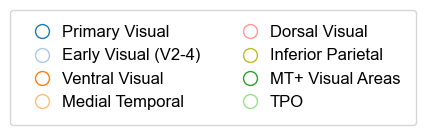

In [499]:
colors = {'Primary Visual': '#1f77b4',
 'Early Visual (V2-4)': '#aec7e8',
 'Ventral Visual': '#ff7f0e',
'Medial Temporal': '#ffbb78',
 'Dorsal Visual': '#ff9896',
 "Inferior Parietal": '#bcbd22',
 'MT+ Visual Areas': '#2ca02c',
 'TPO': '#98df8a'}

# Make a legend with the areas (white circle, edge color)
fig, ax = plt.subplots(figsize=(2, 1))
ax.axis("off")
# Use labels and handles
handles = []
labels = []
for area, color in colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor="white", markersize=10, markeredgecolor=color))
    labels.append(area)

# Add space between labels and the right side
ax.legend(handles=handles, labels=labels, loc='center', fontsize=12, ncol=2, borderpad=0.9, handletextpad=0.2)
fig.savefig(output / "legend_areas_connectivity.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [147]:
df_0 = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_separated_0.parquet")
df_0 = df.query("subject_i != subject_j and roi_x == roi_y").groupby(["roi_x"]).similarity.mean().reset_index()
df_0 = df_0.rename(columns={"roi_x": "roi", "similarity": "similarity"})
df_0 = df_0.merge(hcp[["roi", "name", "mne_name"]], on="roi")
df_0.similarity.max() # 0.2735301

df_1 = load_filename("cross_subject", shift=1, joined=False)
df_1 = df_1.query("subject_i != subject_j and roi_x == roi_y").groupby(["roi_x"]).similarity.mean().reset_index()
df_1 = df_1.rename(columns={"roi_x": "roi", "similarity": "similarity"})
df_1 = df_1.merge(hcp[["roi", "name", "mne_name"]], on="roi")
df_1.similarity.max() # 0.216566

vmax = 0.27
shifts = ((0, df_0), (1, df_1))
views = ["lateral", "medial", "ventral", "caudal"]
for shift, df_shift in shifts:
    for hemisphere in ["lh", "rh"]:
        brain = plot_faverage_parcelation(df_shift[["name", "mne_name", "similarity"]],
                                          value_column="similarity", 
                                          cmap="RdBu_r", 
                                          default_value=None, default_color="lightgray",
                                          normalize=(-vmax, vmax), hemisphere=hemisphere)
        for view in views:
            brain.show_view(view)
            brain.save_image(output / f"rsa_shift_strategy_comparison_{hemisphere}_{view}_shift_{shift}.png", mode="rgba")


In [208]:
df_0 = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_separated_0.parquet")

df_0 = df.query("subject_i != subject_j and roi_x == roi_y").groupby(["roi_x"]).similarity.mean().reset_index()
df_0 = df_0.rename(columns={"roi_x": "roi", "similarity": "similarity_0"})
df_0 = df_0.merge(hcp[["roi", "name", "mne_name"]], on="roi")
df_0.similarity_0.max() # 0.2735301

#df_1 = pd.read_parquet("data/data_rsa/nsd_cross_subject_shift_1_rsa_joined.parquet")
#df_1 = pd.read_parquet("data/data_rsa/rsa_subject_model_alignment_separated.parquet")
#df_1 = pd.read_parquet("data/data_rsa/nsd_cross_subject_shift_1_rsa_joined.parquet")
df_1 = load_filename("cross_subject", shift=1, joined=False)
df_1 = df_1.query("subject_i != subject_j and roi_x == roi_y").groupby(["roi_x"]).similarity.mean().reset_index()

df_1 = df_1.rename(columns={"roi_x": "roi", "similarity": "similarity_1"})
df_1 = df_1.merge(hcp[["roi", "name", "mne_name"]], on="roi")
df_1.similarity_1.max() # 0.216566


df_strategy = df_0.merge(df_1[["similarity_1", "roi"]], on="roi")
df_strategy["ratio"] = df_strategy.similarity_1 / df_strategy.similarity_0
df_strategy
brain = plot_faverage_parcelation(df_strategy, value_column="ratio",  cmap="hot", normalize=(0, 1))
                                  


In [3]:
df_comparison = proccess_alignment(group_subject=True)
brain = plot_faverage_parcelation(df_comparison,
                                  value_column="vision_rsa", normalize=(-0.2, 0.2), cmap="RdBu_r",
                                  default_value=None, default_color="lightgray",
                                    hemisphere="lh")
brain.show_view("lateral")
brain.save_image(output / "rsa_vision_comparison_lh_joined.png", mode="rgba")
brain.show_view("ventral")
brain.save_image(output / "rsa_vision_comparison_lh_ventral_joined.png", mode="rgba")

In [4]:
brain.close()